# Urban Air Pollution Challenge:

The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. PM2.5 refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. PM2.5 is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [85]:
# Utility error function
def rmse(y,x):
    return np.sqrt(mean_squared_error(x,y))

In [359]:
# Load the data
train_df = pd.read_csv('./raw_data/Train.csv')
test = pd.read_csv('./raw_data/Test.csv')
sub = pd.read_csv('./raw_data/SampleSubmission.csv')

In [360]:
train_df.head(3)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.4,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [361]:
def check_missing_data(data: pd.DataFrame) -> pd.DataFrame:
  """Checks a given dataframe for missing values and
  types of the data features.
  """
  total = data.isna().sum()
  percent = (data.isna().sum()/data.isna().count()*100)
  tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  types = []
  for col in data.columns:
      dtype = str(data[col].dtype)
      types.append(dtype)
  tt['Types'] = types
  return(np.transpose(tt))

check_missing_data(train_df)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
Total,0,0,0,0,0,0,0,0,0,0,...,7237,7237,7237,24765,24765,24765,24765,24765,24765,24765
Percent,0,0,0,0,0,0,0,0,0,0,...,23.6836,23.6836,23.6836,81.0453,81.0453,81.0453,81.0453,81.0453,81.0453,81.0453
Types,object,object,object,float64,float64,float64,float64,int64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [362]:
train_df.describe()

,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
count,30557.000000,30557.000000,30557.000000,3.055700e+04,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,30557.000000,...,23320.000000,23320.000000,23320.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,61.148045,29.025866,117.992234,7.983756e+03,125.831135,15.302326,70.552747,0.006004,9.321342,0.416886,...,35.590916,-123.697777,46.533951,923.231949,1711.793613,0.016227,1.254703,13.849040,-69.098594,23.100630
std,46.861309,33.119775,100.417713,4.863090e+04,146.581856,10.688573,18.807884,0.003787,9.343226,2.707990,...,18.955228,71.916036,14.594267,929.633988,1741.299304,0.027016,55.101250,18.004375,84.702355,24.786350
min,1.000000,1.000000,1.000000,0.000000e+00,2.000000,0.420044,5.128572,0.000139,-34.647879,-15.559646,...,0.000000,-179.880630,0.000000,0.000000,0.000000,0.000000,-105.367363,0.000000,-179.947422,0.000000
25%,25.000000,5.000000,60.000000,1.064920e+03,44.000000,7.666667,58.600002,0.003403,3.123071,-1.097864,...,19.451524,-165.882624,36.693094,0.000000,0.000000,0.000000,0.000000,0.000000,-161.726937,0.000000
50%,50.000000,15.000000,91.000000,2.395350e+03,72.000000,12.200000,74.099998,0.004912,8.478424,0.222092,...,37.918838,-156.637162,47.445010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,44.000000,155.000000,5.882550e+03,150.000000,19.900000,85.450001,0.007562,16.201563,1.772925,...,52.270055,-118.453598,57.438181,1861.674119,3393.541633,0.023829,62.245728,27.412303,0.000000,47.090635
max,815.000000,438.000000,999.000000,1.841490e+06,1552.000000,72.599998,100.000000,0.021615,37.437921,17.955124,...,66.111289,179.776125,79.631711,2112.522949,6478.550544,0.210483,77.355232,59.972710,179.813344,69.992363


In [363]:
# 75% of target observations in the train set fall within 80.
# This means that there exist outliers since the max value of the target feature
# is 815 as seen from train.describe().
print(f'with outliers: {len(train_df)}')
train = train_df[train_df['target'] <= 500]
print(f'Without outliers: {len(train)}')

with outliers: 30557
Without outliers: 30552


In [364]:
# Dropping too many missing value columns plus target related features in the train set
#drop_cols = ['L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth', 'L3_CH4_sensor_azimuth_angle',
#             'L3_CH4_sensor_zenith_angle', 'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle',
#             'L3_CH4_CH4_column_volume_mixing_ratio_dry_air']
drop_cols = ['target_min', 'target_max', 'target_variance', 'target_count']

train.drop(drop_cols, axis=1, inplace=True)
#test.drop(drop_cols[:7], axis=1, inplace=True)

In [365]:
encoder = LabelEncoder()
train['Place_ID'] = encoder.fit_transform(train.Place_ID).astype('int32')
test['Place_ID'] = encoder.fit_transform(test.Place_ID).astype('int32')

In [366]:
train['day'] = pd.to_datetime(train['Date']).dt.day.astype('int32')
train['month'] = pd.to_datetime(train['Date']).dt.month.astype('int32')

test['day'] = pd.to_datetime(test['Date']).dt.day.astype('int32')
test['month'] = pd.to_datetime(test['Date']).dt.month.astype('int32')

In [367]:
# Correlation analysis
corr = train.corr()

Text(0.5, 1.0, 'correlation bar_hist')

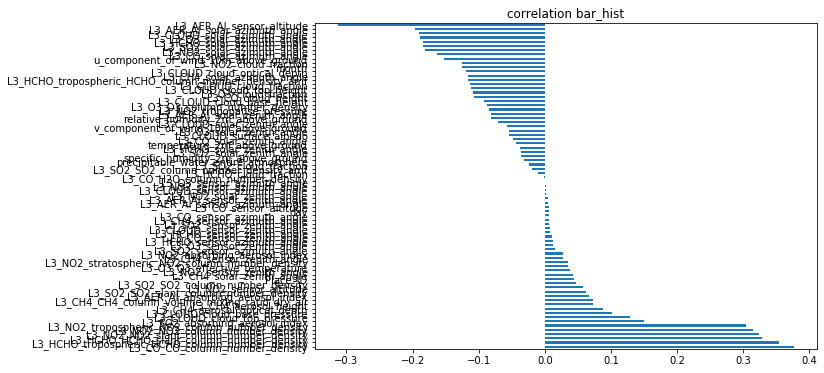

In [409]:
# barhistogram of correlations to the target variable
(corr
     .target
     .drop("target") # can't compare the variable under study to itself
     .sort_values(ascending=False)
     .plot
     .barh(figsize=(9,6)))
plt.title("correlation bar_hist")

In [369]:
drop = ['target', 'Date', 'Place_ID X Date', 'Place_ID', 'L3_AER_AI_sensor_altitude']

y = train['target']
X = train.drop(drop, axis=1)

ids = test['Place_ID X Date']
test = test.drop(drop[1:], axis=1)

X = X.fillna(value=X.median()).astype('float32')
test = test.fillna(value=test.median()).astype('float32')


In [410]:
# LGBM model
lgb_params = {
    'metric' : 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.025, #0.025 (32.3533)
    'max_depth': 11, 
    'num_leaves': 80,
    'objective': 'regression',
    #'subsample': 0.9,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    #'lambda_l2': 0.2,
    'max_bin': 1000 }

# split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#train_data = lgbm.Dataset(X_train, label=y_train)
#test_data = lgbm.Dataset(X_val, label=y_val)

#lgb_model = lgbm.train(lgb_params, train_data, valid_sets=[train_data, test_data],
#                       num_boost_round=9000, early_stopping_rounds=100
#                      ) #0.03lr

#lgb_df = lgbm.Dataset(X, y)
#lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=5000)

In [411]:
# LGBM with 8-fold CV
folds = KFold(n_splits=8, shuffle=False, random_state=42)

scores = []
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    trn_x, trn_y = X.iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    tr_data = lgbm.Dataset(trn_x, label=trn_y)
    val_data = lgbm.Dataset(val_x, label=val_y)

    lgb_model = lgbm.train(lgb_params, tr_data, valid_sets=[tr_data, val_data],
                           num_boost_round=5000, early_stopping_rounds=100
                          ) 
    #model = RandomForestRegressor(n_estimators=250, max_depth=11, n_jobs=-1,
    #                            max_features='sqrt', random_state=42)
    #model.fit(trn_x, trn_y)
    root_mse = rmse(val_y, lgb_model.predict(val_x))
    scores.append(root_mse)
    print(root_mse)

print("Average score in 5-fold CV:", np.mean(scores))

[1]	training's rmse: 46.0486	valid_1's rmse: 41.4168
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 45.6045	valid_1's rmse: 41.0684
[3]	training's rmse: 45.1379	valid_1's rmse: 40.7191
[4]	training's rmse: 44.7007	valid_1's rmse: 40.3591
[5]	training's rmse: 44.2561	valid_1's rmse: 39.9964
[6]	training's rmse: 43.8607	valid_1's rmse: 39.727
[7]	training's rmse: 43.4758	valid_1's rmse: 39.4427
[8]	training's rmse: 43.0415	valid_1's rmse: 39.1201
[9]	training's rmse: 42.6539	valid_1's rmse: 38.8204
[10]	training's rmse: 42.2675	valid_1's rmse: 38.528
[11]	training's rmse: 41.9378	valid_1's rmse: 38.2973
[12]	training's rmse: 41.5867	valid_1's rmse: 38.0647
[13]	training's rmse: 41.2454	valid_1's rmse: 37.7738
[14]	training's rmse: 40.915	valid_1's rmse: 37.5362
[15]	training's rmse: 40.5942	valid_1's rmse: 37.3223
[16]	training's rmse: 40.3057	valid_1's rmse: 37.0935
[17]	training's rmse: 39.9825	valid_1's rmse: 36.8248
[18]	training's rmse: 39.6918	va

[153]	training's rmse: 25.4748	valid_1's rmse: 28.2027
[154]	training's rmse: 25.4348	valid_1's rmse: 28.1922
[155]	training's rmse: 25.3927	valid_1's rmse: 28.1772
[156]	training's rmse: 25.3457	valid_1's rmse: 28.1621
[157]	training's rmse: 25.3101	valid_1's rmse: 28.1426
[158]	training's rmse: 25.2718	valid_1's rmse: 28.1311
[159]	training's rmse: 25.2252	valid_1's rmse: 28.1085
[160]	training's rmse: 25.184	valid_1's rmse: 28.092
[161]	training's rmse: 25.1461	valid_1's rmse: 28.0864
[162]	training's rmse: 25.1109	valid_1's rmse: 28.0818
[163]	training's rmse: 25.076	valid_1's rmse: 28.0684
[164]	training's rmse: 25.0373	valid_1's rmse: 28.0599
[165]	training's rmse: 25.0049	valid_1's rmse: 28.0403
[166]	training's rmse: 24.9597	valid_1's rmse: 28.0157
[167]	training's rmse: 24.925	valid_1's rmse: 28.0033
[168]	training's rmse: 24.8908	valid_1's rmse: 27.99
[169]	training's rmse: 24.8547	valid_1's rmse: 27.9753
[170]	training's rmse: 24.8177	valid_1's rmse: 27.9603
[171]	training's

[303]	training's rmse: 21.4867	valid_1's rmse: 27.0524
[304]	training's rmse: 21.468	valid_1's rmse: 27.0542
[305]	training's rmse: 21.4463	valid_1's rmse: 27.0497
[306]	training's rmse: 21.4305	valid_1's rmse: 27.0486
[307]	training's rmse: 21.4118	valid_1's rmse: 27.0454
[308]	training's rmse: 21.3941	valid_1's rmse: 27.0418
[309]	training's rmse: 21.3729	valid_1's rmse: 27.0332
[310]	training's rmse: 21.353	valid_1's rmse: 27.0305
[311]	training's rmse: 21.335	valid_1's rmse: 27.0309
[312]	training's rmse: 21.3207	valid_1's rmse: 27.0239
[313]	training's rmse: 21.3011	valid_1's rmse: 27.0239
[314]	training's rmse: 21.2861	valid_1's rmse: 27.0194
[315]	training's rmse: 21.2742	valid_1's rmse: 27.0154
[316]	training's rmse: 21.2595	valid_1's rmse: 27.0115
[317]	training's rmse: 21.2401	valid_1's rmse: 27.011
[318]	training's rmse: 21.222	valid_1's rmse: 27.0084
[319]	training's rmse: 21.2047	valid_1's rmse: 27.0064
[320]	training's rmse: 21.1886	valid_1's rmse: 27.0006
[321]	training'

[456]	training's rmse: 19.1506	valid_1's rmse: 26.6454
[457]	training's rmse: 19.1369	valid_1's rmse: 26.6429
[458]	training's rmse: 19.125	valid_1's rmse: 26.6398
[459]	training's rmse: 19.1134	valid_1's rmse: 26.6313
[460]	training's rmse: 19.1083	valid_1's rmse: 26.6305
[461]	training's rmse: 19.0979	valid_1's rmse: 26.6288
[462]	training's rmse: 19.0852	valid_1's rmse: 26.629
[463]	training's rmse: 19.077	valid_1's rmse: 26.6274
[464]	training's rmse: 19.0694	valid_1's rmse: 26.6261
[465]	training's rmse: 19.0583	valid_1's rmse: 26.6239
[466]	training's rmse: 19.0429	valid_1's rmse: 26.6267
[467]	training's rmse: 19.0321	valid_1's rmse: 26.6247
[468]	training's rmse: 19.0243	valid_1's rmse: 26.6226
[469]	training's rmse: 19.0053	valid_1's rmse: 26.6133
[470]	training's rmse: 18.9922	valid_1's rmse: 26.6126
[471]	training's rmse: 18.9852	valid_1's rmse: 26.6128
[472]	training's rmse: 18.9757	valid_1's rmse: 26.6135
[473]	training's rmse: 18.9632	valid_1's rmse: 26.6134
[474]	trainin

[608]	training's rmse: 17.4166	valid_1's rmse: 26.4369
[609]	training's rmse: 17.4076	valid_1's rmse: 26.4366
[610]	training's rmse: 17.3947	valid_1's rmse: 26.4332
[611]	training's rmse: 17.3809	valid_1's rmse: 26.4337
[612]	training's rmse: 17.3697	valid_1's rmse: 26.4336
[613]	training's rmse: 17.3614	valid_1's rmse: 26.4354
[614]	training's rmse: 17.35	valid_1's rmse: 26.4334
[615]	training's rmse: 17.3434	valid_1's rmse: 26.4334
[616]	training's rmse: 17.3298	valid_1's rmse: 26.4336
[617]	training's rmse: 17.3161	valid_1's rmse: 26.4337
[618]	training's rmse: 17.3056	valid_1's rmse: 26.4335
[619]	training's rmse: 17.2896	valid_1's rmse: 26.4325
[620]	training's rmse: 17.2833	valid_1's rmse: 26.4318
[621]	training's rmse: 17.2766	valid_1's rmse: 26.4303
[622]	training's rmse: 17.2662	valid_1's rmse: 26.4317
[623]	training's rmse: 17.255	valid_1's rmse: 26.4307
[624]	training's rmse: 17.2434	valid_1's rmse: 26.4294
[625]	training's rmse: 17.237	valid_1's rmse: 26.4295
[626]	training

[758]	training's rmse: 15.9476	valid_1's rmse: 26.2871
[759]	training's rmse: 15.9432	valid_1's rmse: 26.2879
[760]	training's rmse: 15.9365	valid_1's rmse: 26.287
[761]	training's rmse: 15.9263	valid_1's rmse: 26.2858
[762]	training's rmse: 15.9126	valid_1's rmse: 26.285
[763]	training's rmse: 15.9047	valid_1's rmse: 26.2838
[764]	training's rmse: 15.8971	valid_1's rmse: 26.2821
[765]	training's rmse: 15.8892	valid_1's rmse: 26.283
[766]	training's rmse: 15.8867	valid_1's rmse: 26.2827
[767]	training's rmse: 15.8733	valid_1's rmse: 26.2762
[768]	training's rmse: 15.8626	valid_1's rmse: 26.2731
[769]	training's rmse: 15.8554	valid_1's rmse: 26.2739
[770]	training's rmse: 15.847	valid_1's rmse: 26.2736
[771]	training's rmse: 15.8386	valid_1's rmse: 26.2731
[772]	training's rmse: 15.8349	valid_1's rmse: 26.2725
[773]	training's rmse: 15.8296	valid_1's rmse: 26.2719
[774]	training's rmse: 15.8227	valid_1's rmse: 26.2716
[775]	training's rmse: 15.8174	valid_1's rmse: 26.2712
[776]	training

[911]	training's rmse: 14.7207	valid_1's rmse: 26.1597
[912]	training's rmse: 14.7197	valid_1's rmse: 26.1584
[913]	training's rmse: 14.7131	valid_1's rmse: 26.1585
[914]	training's rmse: 14.703	valid_1's rmse: 26.1579
[915]	training's rmse: 14.6911	valid_1's rmse: 26.157
[916]	training's rmse: 14.6834	valid_1's rmse: 26.1532
[917]	training's rmse: 14.6738	valid_1's rmse: 26.1513
[918]	training's rmse: 14.6645	valid_1's rmse: 26.1522
[919]	training's rmse: 14.6531	valid_1's rmse: 26.1509
[920]	training's rmse: 14.6466	valid_1's rmse: 26.1502
[921]	training's rmse: 14.6369	valid_1's rmse: 26.1461
[922]	training's rmse: 14.631	valid_1's rmse: 26.145
[923]	training's rmse: 14.6224	valid_1's rmse: 26.1447
[924]	training's rmse: 14.6144	valid_1's rmse: 26.1435
[925]	training's rmse: 14.6072	valid_1's rmse: 26.1446
[926]	training's rmse: 14.6	valid_1's rmse: 26.1424
[927]	training's rmse: 14.594	valid_1's rmse: 26.142
[928]	training's rmse: 14.5879	valid_1's rmse: 26.1405
[929]	training's rm

[1062]	training's rmse: 13.6456	valid_1's rmse: 26.0421
[1063]	training's rmse: 13.6397	valid_1's rmse: 26.0402
[1064]	training's rmse: 13.6337	valid_1's rmse: 26.0391
[1065]	training's rmse: 13.6262	valid_1's rmse: 26.0413
[1066]	training's rmse: 13.6207	valid_1's rmse: 26.0417
[1067]	training's rmse: 13.6143	valid_1's rmse: 26.0417
[1068]	training's rmse: 13.6067	valid_1's rmse: 26.04
[1069]	training's rmse: 13.601	valid_1's rmse: 26.0379
[1070]	training's rmse: 13.5948	valid_1's rmse: 26.0386
[1071]	training's rmse: 13.5886	valid_1's rmse: 26.0395
[1072]	training's rmse: 13.5872	valid_1's rmse: 26.0389
[1073]	training's rmse: 13.5851	valid_1's rmse: 26.0394
[1074]	training's rmse: 13.5775	valid_1's rmse: 26.0386
[1075]	training's rmse: 13.5708	valid_1's rmse: 26.0385
[1076]	training's rmse: 13.5654	valid_1's rmse: 26.0368
[1077]	training's rmse: 13.5565	valid_1's rmse: 26.0372
[1078]	training's rmse: 13.5493	valid_1's rmse: 26.0344
[1079]	training's rmse: 13.5439	valid_1's rmse: 26.

[1210]	training's rmse: 12.758	valid_1's rmse: 25.9581
[1211]	training's rmse: 12.7557	valid_1's rmse: 25.9566
[1212]	training's rmse: 12.7537	valid_1's rmse: 25.9565
[1213]	training's rmse: 12.7476	valid_1's rmse: 25.9517
[1214]	training's rmse: 12.7403	valid_1's rmse: 25.9509
[1215]	training's rmse: 12.7353	valid_1's rmse: 25.9495
[1216]	training's rmse: 12.7301	valid_1's rmse: 25.9524
[1217]	training's rmse: 12.7231	valid_1's rmse: 25.9503
[1218]	training's rmse: 12.7157	valid_1's rmse: 25.9494
[1219]	training's rmse: 12.7085	valid_1's rmse: 25.9462
[1220]	training's rmse: 12.7032	valid_1's rmse: 25.9446
[1221]	training's rmse: 12.7007	valid_1's rmse: 25.9454
[1222]	training's rmse: 12.6986	valid_1's rmse: 25.9452
[1223]	training's rmse: 12.6937	valid_1's rmse: 25.9451
[1224]	training's rmse: 12.6868	valid_1's rmse: 25.9449
[1225]	training's rmse: 12.6821	valid_1's rmse: 25.9447
[1226]	training's rmse: 12.6771	valid_1's rmse: 25.9456
[1227]	training's rmse: 12.6702	valid_1's rmse: 2

[1358]	training's rmse: 11.9218	valid_1's rmse: 25.8881
[1359]	training's rmse: 11.9159	valid_1's rmse: 25.8872
[1360]	training's rmse: 11.9112	valid_1's rmse: 25.8862
[1361]	training's rmse: 11.9103	valid_1's rmse: 25.8862
[1362]	training's rmse: 11.9038	valid_1's rmse: 25.8863
[1363]	training's rmse: 11.8954	valid_1's rmse: 25.8854
[1364]	training's rmse: 11.8914	valid_1's rmse: 25.8849
[1365]	training's rmse: 11.8858	valid_1's rmse: 25.8859
[1366]	training's rmse: 11.879	valid_1's rmse: 25.8849
[1367]	training's rmse: 11.8747	valid_1's rmse: 25.8847
[1368]	training's rmse: 11.8686	valid_1's rmse: 25.8839
[1369]	training's rmse: 11.8606	valid_1's rmse: 25.8832
[1370]	training's rmse: 11.8559	valid_1's rmse: 25.8822
[1371]	training's rmse: 11.8523	valid_1's rmse: 25.8817
[1372]	training's rmse: 11.8483	valid_1's rmse: 25.8819
[1373]	training's rmse: 11.8407	valid_1's rmse: 25.8805
[1374]	training's rmse: 11.8364	valid_1's rmse: 25.8797
[1375]	training's rmse: 11.8294	valid_1's rmse: 2

[1505]	training's rmse: 11.1346	valid_1's rmse: 25.8532
[1506]	training's rmse: 11.1306	valid_1's rmse: 25.8531
[1507]	training's rmse: 11.1228	valid_1's rmse: 25.8527
[1508]	training's rmse: 11.1147	valid_1's rmse: 25.8512
[1509]	training's rmse: 11.1104	valid_1's rmse: 25.8504
[1510]	training's rmse: 11.1061	valid_1's rmse: 25.8502
[1511]	training's rmse: 11.0983	valid_1's rmse: 25.8502
[1512]	training's rmse: 11.0936	valid_1's rmse: 25.8501
[1513]	training's rmse: 11.0893	valid_1's rmse: 25.8498
[1514]	training's rmse: 11.0843	valid_1's rmse: 25.8499
[1515]	training's rmse: 11.0778	valid_1's rmse: 25.849
[1516]	training's rmse: 11.0734	valid_1's rmse: 25.849
[1517]	training's rmse: 11.0688	valid_1's rmse: 25.8487
[1518]	training's rmse: 11.0649	valid_1's rmse: 25.8463
[1519]	training's rmse: 11.0605	valid_1's rmse: 25.8466
[1520]	training's rmse: 11.0561	valid_1's rmse: 25.846
[1521]	training's rmse: 11.0483	valid_1's rmse: 25.8464
[1522]	training's rmse: 11.0419	valid_1's rmse: 25.

[1654]	training's rmse: 10.3764	valid_1's rmse: 25.815
[1655]	training's rmse: 10.374	valid_1's rmse: 25.8153
[1656]	training's rmse: 10.369	valid_1's rmse: 25.8154
[1657]	training's rmse: 10.3646	valid_1's rmse: 25.8152
[1658]	training's rmse: 10.3607	valid_1's rmse: 25.8159
[1659]	training's rmse: 10.3572	valid_1's rmse: 25.8174
[1660]	training's rmse: 10.3538	valid_1's rmse: 25.8182
[1661]	training's rmse: 10.35	valid_1's rmse: 25.818
[1662]	training's rmse: 10.3419	valid_1's rmse: 25.8175
[1663]	training's rmse: 10.3343	valid_1's rmse: 25.8157
[1664]	training's rmse: 10.3295	valid_1's rmse: 25.8144
[1665]	training's rmse: 10.325	valid_1's rmse: 25.814
[1666]	training's rmse: 10.3216	valid_1's rmse: 25.8138
[1667]	training's rmse: 10.3161	valid_1's rmse: 25.8135
[1668]	training's rmse: 10.3087	valid_1's rmse: 25.8128
[1669]	training's rmse: 10.303	valid_1's rmse: 25.8132
[1670]	training's rmse: 10.2996	valid_1's rmse: 25.8128
[1671]	training's rmse: 10.2958	valid_1's rmse: 25.812
[1

[1802]	training's rmse: 9.68836	valid_1's rmse: 25.7631
[1803]	training's rmse: 9.68116	valid_1's rmse: 25.7612
[1804]	training's rmse: 9.67689	valid_1's rmse: 25.7613
[1805]	training's rmse: 9.67235	valid_1's rmse: 25.7618
[1806]	training's rmse: 9.66859	valid_1's rmse: 25.762
[1807]	training's rmse: 9.66556	valid_1's rmse: 25.7622
[1808]	training's rmse: 9.66243	valid_1's rmse: 25.7624
[1809]	training's rmse: 9.65815	valid_1's rmse: 25.7622
[1810]	training's rmse: 9.65238	valid_1's rmse: 25.7608
[1811]	training's rmse: 9.64999	valid_1's rmse: 25.7612
[1812]	training's rmse: 9.64654	valid_1's rmse: 25.76
[1813]	training's rmse: 9.6429	valid_1's rmse: 25.7595
[1814]	training's rmse: 9.63953	valid_1's rmse: 25.7568
[1815]	training's rmse: 9.63591	valid_1's rmse: 25.7566
[1816]	training's rmse: 9.6315	valid_1's rmse: 25.757
[1817]	training's rmse: 9.62994	valid_1's rmse: 25.7572
[1818]	training's rmse: 9.62564	valid_1's rmse: 25.7573
[1819]	training's rmse: 9.61875	valid_1's rmse: 25.756

[1951]	training's rmse: 9.12654	valid_1's rmse: 25.7258
[1952]	training's rmse: 9.12184	valid_1's rmse: 25.724
[1953]	training's rmse: 9.11731	valid_1's rmse: 25.7241
[1954]	training's rmse: 9.11337	valid_1's rmse: 25.7234
[1955]	training's rmse: 9.11053	valid_1's rmse: 25.7235
[1956]	training's rmse: 9.10536	valid_1's rmse: 25.7238
[1957]	training's rmse: 9.10177	valid_1's rmse: 25.723
[1958]	training's rmse: 9.09838	valid_1's rmse: 25.7233
[1959]	training's rmse: 9.09554	valid_1's rmse: 25.7227
[1960]	training's rmse: 9.09247	valid_1's rmse: 25.7235
[1961]	training's rmse: 9.08913	valid_1's rmse: 25.7222
[1962]	training's rmse: 9.08661	valid_1's rmse: 25.7232
[1963]	training's rmse: 9.08193	valid_1's rmse: 25.7228
[1964]	training's rmse: 9.07751	valid_1's rmse: 25.7233
[1965]	training's rmse: 9.07431	valid_1's rmse: 25.7239
[1966]	training's rmse: 9.072	valid_1's rmse: 25.7241
[1967]	training's rmse: 9.06832	valid_1's rmse: 25.7239
[1968]	training's rmse: 9.06533	valid_1's rmse: 25.7

[2098]	training's rmse: 8.59798	valid_1's rmse: 25.6976
[2099]	training's rmse: 8.5927	valid_1's rmse: 25.6962
[2100]	training's rmse: 8.58932	valid_1's rmse: 25.696
[2101]	training's rmse: 8.58577	valid_1's rmse: 25.6964
[2102]	training's rmse: 8.58186	valid_1's rmse: 25.6956
[2103]	training's rmse: 8.57589	valid_1's rmse: 25.6949
[2104]	training's rmse: 8.57246	valid_1's rmse: 25.6947
[2105]	training's rmse: 8.56787	valid_1's rmse: 25.6942
[2106]	training's rmse: 8.56401	valid_1's rmse: 25.6946
[2107]	training's rmse: 8.56108	valid_1's rmse: 25.6938
[2108]	training's rmse: 8.55694	valid_1's rmse: 25.6937
[2109]	training's rmse: 8.55401	valid_1's rmse: 25.6941
[2110]	training's rmse: 8.55059	valid_1's rmse: 25.6943
[2111]	training's rmse: 8.54723	valid_1's rmse: 25.6944
[2112]	training's rmse: 8.54417	valid_1's rmse: 25.6944
[2113]	training's rmse: 8.53968	valid_1's rmse: 25.6929
[2114]	training's rmse: 8.53657	valid_1's rmse: 25.6928
[2115]	training's rmse: 8.53322	valid_1's rmse: 25

[2245]	training's rmse: 8.07598	valid_1's rmse: 25.6607
[2246]	training's rmse: 8.07288	valid_1's rmse: 25.6603
[2247]	training's rmse: 8.06956	valid_1's rmse: 25.66
[2248]	training's rmse: 8.06556	valid_1's rmse: 25.66
[2249]	training's rmse: 8.06176	valid_1's rmse: 25.6607
[2250]	training's rmse: 8.05794	valid_1's rmse: 25.6593
[2251]	training's rmse: 8.05174	valid_1's rmse: 25.6564
[2252]	training's rmse: 8.04833	valid_1's rmse: 25.656
[2253]	training's rmse: 8.04417	valid_1's rmse: 25.6558
[2254]	training's rmse: 8.03971	valid_1's rmse: 25.6547
[2255]	training's rmse: 8.03713	valid_1's rmse: 25.6551
[2256]	training's rmse: 8.03311	valid_1's rmse: 25.6543
[2257]	training's rmse: 8.03031	valid_1's rmse: 25.655
[2258]	training's rmse: 8.02865	valid_1's rmse: 25.6544
[2259]	training's rmse: 8.02517	valid_1's rmse: 25.6546
[2260]	training's rmse: 8.02238	valid_1's rmse: 25.6546
[2261]	training's rmse: 8.0201	valid_1's rmse: 25.6545
[2262]	training's rmse: 8.01545	valid_1's rmse: 25.6552

[2393]	training's rmse: 7.61915	valid_1's rmse: 25.623
[2394]	training's rmse: 7.618	valid_1's rmse: 25.623
[2395]	training's rmse: 7.61585	valid_1's rmse: 25.6231
[2396]	training's rmse: 7.60935	valid_1's rmse: 25.6217
[2397]	training's rmse: 7.60596	valid_1's rmse: 25.621
[2398]	training's rmse: 7.60294	valid_1's rmse: 25.6207
[2399]	training's rmse: 7.60014	valid_1's rmse: 25.6209
[2400]	training's rmse: 7.5985	valid_1's rmse: 25.6204
[2401]	training's rmse: 7.59428	valid_1's rmse: 25.62
[2402]	training's rmse: 7.59241	valid_1's rmse: 25.6199
[2403]	training's rmse: 7.58985	valid_1's rmse: 25.6196
[2404]	training's rmse: 7.58705	valid_1's rmse: 25.6187
[2405]	training's rmse: 7.58277	valid_1's rmse: 25.6179
[2406]	training's rmse: 7.58038	valid_1's rmse: 25.6179
[2407]	training's rmse: 7.57681	valid_1's rmse: 25.6186
[2408]	training's rmse: 7.57293	valid_1's rmse: 25.6182
[2409]	training's rmse: 7.57021	valid_1's rmse: 25.6181
[2410]	training's rmse: 7.56877	valid_1's rmse: 25.6183


[2541]	training's rmse: 7.18402	valid_1's rmse: 25.5985
[2542]	training's rmse: 7.18261	valid_1's rmse: 25.5988
[2543]	training's rmse: 7.18056	valid_1's rmse: 25.5986
[2544]	training's rmse: 7.1769	valid_1's rmse: 25.5981
[2545]	training's rmse: 7.1748	valid_1's rmse: 25.5976
[2546]	training's rmse: 7.17189	valid_1's rmse: 25.5976
[2547]	training's rmse: 7.16993	valid_1's rmse: 25.5974
[2548]	training's rmse: 7.16923	valid_1's rmse: 25.5972
[2549]	training's rmse: 7.16473	valid_1's rmse: 25.5966
[2550]	training's rmse: 7.16328	valid_1's rmse: 25.5962
[2551]	training's rmse: 7.15971	valid_1's rmse: 25.5965
[2552]	training's rmse: 7.15667	valid_1's rmse: 25.5969
[2553]	training's rmse: 7.15279	valid_1's rmse: 25.5961
[2554]	training's rmse: 7.15146	valid_1's rmse: 25.5959
[2555]	training's rmse: 7.1496	valid_1's rmse: 25.5954
[2556]	training's rmse: 7.14725	valid_1's rmse: 25.5958
[2557]	training's rmse: 7.14589	valid_1's rmse: 25.5955
[2558]	training's rmse: 7.14279	valid_1's rmse: 25.

[2689]	training's rmse: 6.81304	valid_1's rmse: 25.5707
[2690]	training's rmse: 6.81163	valid_1's rmse: 25.5709
[2691]	training's rmse: 6.80924	valid_1's rmse: 25.5711
[2692]	training's rmse: 6.80628	valid_1's rmse: 25.571
[2693]	training's rmse: 6.80471	valid_1's rmse: 25.5719
[2694]	training's rmse: 6.80259	valid_1's rmse: 25.5716
[2695]	training's rmse: 6.80143	valid_1's rmse: 25.5716
[2696]	training's rmse: 6.79991	valid_1's rmse: 25.5717
[2697]	training's rmse: 6.79849	valid_1's rmse: 25.5716
[2698]	training's rmse: 6.79765	valid_1's rmse: 25.5714
[2699]	training's rmse: 6.79596	valid_1's rmse: 25.5719
[2700]	training's rmse: 6.79343	valid_1's rmse: 25.5719
[2701]	training's rmse: 6.79118	valid_1's rmse: 25.5716
[2702]	training's rmse: 6.79082	valid_1's rmse: 25.5716
[2703]	training's rmse: 6.78639	valid_1's rmse: 25.571
[2704]	training's rmse: 6.78403	valid_1's rmse: 25.5709
[2705]	training's rmse: 6.78061	valid_1's rmse: 25.5706
[2706]	training's rmse: 6.77831	valid_1's rmse: 25

[2841]	training's rmse: 6.44776	valid_1's rmse: 25.5652
[2842]	training's rmse: 6.44439	valid_1's rmse: 25.5646
[2843]	training's rmse: 6.44179	valid_1's rmse: 25.5643
[2844]	training's rmse: 6.43804	valid_1's rmse: 25.5639
[2845]	training's rmse: 6.43634	valid_1's rmse: 25.5639
[2846]	training's rmse: 6.43367	valid_1's rmse: 25.5642
[2847]	training's rmse: 6.43191	valid_1's rmse: 25.5639
[2848]	training's rmse: 6.42878	valid_1's rmse: 25.5639
[2849]	training's rmse: 6.42794	valid_1's rmse: 25.5644
[2850]	training's rmse: 6.42542	valid_1's rmse: 25.5653
[2851]	training's rmse: 6.42251	valid_1's rmse: 25.5655
[2852]	training's rmse: 6.41777	valid_1's rmse: 25.5648
[2853]	training's rmse: 6.41708	valid_1's rmse: 25.565
[2854]	training's rmse: 6.41527	valid_1's rmse: 25.5648
[2855]	training's rmse: 6.41204	valid_1's rmse: 25.5648
[2856]	training's rmse: 6.40958	valid_1's rmse: 25.5648
[2857]	training's rmse: 6.40702	valid_1's rmse: 25.5648
[2858]	training's rmse: 6.40427	valid_1's rmse: 2

[2990]	training's rmse: 6.0782	valid_1's rmse: 25.5478
[2991]	training's rmse: 6.0745	valid_1's rmse: 25.5477
[2992]	training's rmse: 6.07284	valid_1's rmse: 25.5479
[2993]	training's rmse: 6.06946	valid_1's rmse: 25.5469
[2994]	training's rmse: 6.06672	valid_1's rmse: 25.5469
[2995]	training's rmse: 6.06497	valid_1's rmse: 25.5469
[2996]	training's rmse: 6.06181	valid_1's rmse: 25.5471
[2997]	training's rmse: 6.05966	valid_1's rmse: 25.5476
[2998]	training's rmse: 6.05769	valid_1's rmse: 25.5479
[2999]	training's rmse: 6.05525	valid_1's rmse: 25.5472
[3000]	training's rmse: 6.0542	valid_1's rmse: 25.5469
[3001]	training's rmse: 6.05161	valid_1's rmse: 25.546
[3002]	training's rmse: 6.04966	valid_1's rmse: 25.5455
[3003]	training's rmse: 6.04773	valid_1's rmse: 25.5456
[3004]	training's rmse: 6.04226	valid_1's rmse: 25.5443
[3005]	training's rmse: 6.04029	valid_1's rmse: 25.5447
[3006]	training's rmse: 6.03856	valid_1's rmse: 25.5446
[3007]	training's rmse: 6.03583	valid_1's rmse: 25.5

[3141]	training's rmse: 5.75136	valid_1's rmse: 25.5304
[3142]	training's rmse: 5.74987	valid_1's rmse: 25.53
[3143]	training's rmse: 5.74632	valid_1's rmse: 25.5299
[3144]	training's rmse: 5.74461	valid_1's rmse: 25.5301
[3145]	training's rmse: 5.74264	valid_1's rmse: 25.5305
[3146]	training's rmse: 5.74167	valid_1's rmse: 25.5305
[3147]	training's rmse: 5.73982	valid_1's rmse: 25.5306
[3148]	training's rmse: 5.73708	valid_1's rmse: 25.5299
[3149]	training's rmse: 5.73498	valid_1's rmse: 25.5298
[3150]	training's rmse: 5.73272	valid_1's rmse: 25.5295
[3151]	training's rmse: 5.73032	valid_1's rmse: 25.5289
[3152]	training's rmse: 5.72819	valid_1's rmse: 25.5288
[3153]	training's rmse: 5.72734	valid_1's rmse: 25.5283
[3154]	training's rmse: 5.72515	valid_1's rmse: 25.5284
[3155]	training's rmse: 5.72314	valid_1's rmse: 25.5292
[3156]	training's rmse: 5.72096	valid_1's rmse: 25.5292
[3157]	training's rmse: 5.7197	valid_1's rmse: 25.5293
[3158]	training's rmse: 5.71832	valid_1's rmse: 25.

[3290]	training's rmse: 5.44864	valid_1's rmse: 25.5155
[3291]	training's rmse: 5.44595	valid_1's rmse: 25.5156
[3292]	training's rmse: 5.44361	valid_1's rmse: 25.515
[3293]	training's rmse: 5.44142	valid_1's rmse: 25.5144
[3294]	training's rmse: 5.43965	valid_1's rmse: 25.5146
[3295]	training's rmse: 5.43853	valid_1's rmse: 25.5142
[3296]	training's rmse: 5.436	valid_1's rmse: 25.5147
[3297]	training's rmse: 5.43253	valid_1's rmse: 25.5142
[3298]	training's rmse: 5.43026	valid_1's rmse: 25.5141
[3299]	training's rmse: 5.42884	valid_1's rmse: 25.5135
[3300]	training's rmse: 5.42656	valid_1's rmse: 25.5139
[3301]	training's rmse: 5.42454	valid_1's rmse: 25.514
[3302]	training's rmse: 5.42221	valid_1's rmse: 25.514
[3303]	training's rmse: 5.42036	valid_1's rmse: 25.514
[3304]	training's rmse: 5.41763	valid_1's rmse: 25.5144
[3305]	training's rmse: 5.4151	valid_1's rmse: 25.5142
[3306]	training's rmse: 5.41348	valid_1's rmse: 25.5141
[3307]	training's rmse: 5.4111	valid_1's rmse: 25.5139


[3437]	training's rmse: 5.14664	valid_1's rmse: 25.4958
[3438]	training's rmse: 5.14486	valid_1's rmse: 25.4955
[3439]	training's rmse: 5.14349	valid_1's rmse: 25.4953
[3440]	training's rmse: 5.14167	valid_1's rmse: 25.4951
[3441]	training's rmse: 5.14122	valid_1's rmse: 25.4949
[3442]	training's rmse: 5.13851	valid_1's rmse: 25.4956
[3443]	training's rmse: 5.13613	valid_1's rmse: 25.4958
[3444]	training's rmse: 5.13455	valid_1's rmse: 25.4954
[3445]	training's rmse: 5.13197	valid_1's rmse: 25.4946
[3446]	training's rmse: 5.12984	valid_1's rmse: 25.4946
[3447]	training's rmse: 5.12828	valid_1's rmse: 25.4945
[3448]	training's rmse: 5.12534	valid_1's rmse: 25.495
[3449]	training's rmse: 5.12382	valid_1's rmse: 25.495
[3450]	training's rmse: 5.12219	valid_1's rmse: 25.4952
[3451]	training's rmse: 5.11995	valid_1's rmse: 25.4946
[3452]	training's rmse: 5.1185	valid_1's rmse: 25.4943
[3453]	training's rmse: 5.11671	valid_1's rmse: 25.4944
[3454]	training's rmse: 5.11545	valid_1's rmse: 25.

[3588]	training's rmse: 4.88145	valid_1's rmse: 25.483
[3589]	training's rmse: 4.88015	valid_1's rmse: 25.4828
[3590]	training's rmse: 4.87842	valid_1's rmse: 25.483
[3591]	training's rmse: 4.87765	valid_1's rmse: 25.4826
[3592]	training's rmse: 4.87637	valid_1's rmse: 25.4822
[3593]	training's rmse: 4.87453	valid_1's rmse: 25.482
[3594]	training's rmse: 4.87318	valid_1's rmse: 25.4819
[3595]	training's rmse: 4.87238	valid_1's rmse: 25.4817
[3596]	training's rmse: 4.87114	valid_1's rmse: 25.4819
[3597]	training's rmse: 4.87017	valid_1's rmse: 25.482
[3598]	training's rmse: 4.86835	valid_1's rmse: 25.482
[3599]	training's rmse: 4.86667	valid_1's rmse: 25.482
[3600]	training's rmse: 4.86542	valid_1's rmse: 25.4821
[3601]	training's rmse: 4.86398	valid_1's rmse: 25.4823
[3602]	training's rmse: 4.86331	valid_1's rmse: 25.4823
[3603]	training's rmse: 4.86046	valid_1's rmse: 25.4822
[3604]	training's rmse: 4.85825	valid_1's rmse: 25.4829
[3605]	training's rmse: 4.85643	valid_1's rmse: 25.482

[3737]	training's rmse: 4.64116	valid_1's rmse: 25.4743
[3738]	training's rmse: 4.63994	valid_1's rmse: 25.4746
[3739]	training's rmse: 4.63896	valid_1's rmse: 25.474
[3740]	training's rmse: 4.63852	valid_1's rmse: 25.4742
[3741]	training's rmse: 4.63765	valid_1's rmse: 25.4743
[3742]	training's rmse: 4.63662	valid_1's rmse: 25.4742
[3743]	training's rmse: 4.63521	valid_1's rmse: 25.4744
[3744]	training's rmse: 4.6339	valid_1's rmse: 25.4746
[3745]	training's rmse: 4.63325	valid_1's rmse: 25.4744
[3746]	training's rmse: 4.63189	valid_1's rmse: 25.4743
[3747]	training's rmse: 4.63085	valid_1's rmse: 25.4743
[3748]	training's rmse: 4.63043	valid_1's rmse: 25.4744
[3749]	training's rmse: 4.62869	valid_1's rmse: 25.4752
[3750]	training's rmse: 4.62633	valid_1's rmse: 25.4751
[3751]	training's rmse: 4.62489	valid_1's rmse: 25.4749
[3752]	training's rmse: 4.62382	valid_1's rmse: 25.4749
[3753]	training's rmse: 4.62244	valid_1's rmse: 25.4748
[3754]	training's rmse: 4.61966	valid_1's rmse: 25

[3888]	training's rmse: 4.41271	valid_1's rmse: 25.4729
[3889]	training's rmse: 4.4101	valid_1's rmse: 25.4734
[3890]	training's rmse: 4.40792	valid_1's rmse: 25.4731
[3891]	training's rmse: 4.40658	valid_1's rmse: 25.4734
[3892]	training's rmse: 4.40573	valid_1's rmse: 25.4733
[3893]	training's rmse: 4.4048	valid_1's rmse: 25.4735
[3894]	training's rmse: 4.40288	valid_1's rmse: 25.4735
[3895]	training's rmse: 4.40189	valid_1's rmse: 25.4737
[3896]	training's rmse: 4.40053	valid_1's rmse: 25.473
[3897]	training's rmse: 4.39829	valid_1's rmse: 25.4731
[3898]	training's rmse: 4.39722	valid_1's rmse: 25.4727
[3899]	training's rmse: 4.39581	valid_1's rmse: 25.4728
[3900]	training's rmse: 4.3948	valid_1's rmse: 25.4732
[3901]	training's rmse: 4.39367	valid_1's rmse: 25.4732
[3902]	training's rmse: 4.39197	valid_1's rmse: 25.4734
[3903]	training's rmse: 4.39059	valid_1's rmse: 25.4733
[3904]	training's rmse: 4.38878	valid_1's rmse: 25.4736
[3905]	training's rmse: 4.38635	valid_1's rmse: 25.4

[73]	training's rmse: 29.6744	valid_1's rmse: 34.1296
[74]	training's rmse: 29.5713	valid_1's rmse: 34.0534
[75]	training's rmse: 29.4901	valid_1's rmse: 34.0289
[76]	training's rmse: 29.4032	valid_1's rmse: 33.9795
[77]	training's rmse: 29.3146	valid_1's rmse: 33.9241
[78]	training's rmse: 29.2302	valid_1's rmse: 33.8814
[79]	training's rmse: 29.1584	valid_1's rmse: 33.8509
[80]	training's rmse: 29.0713	valid_1's rmse: 33.7993
[81]	training's rmse: 28.9963	valid_1's rmse: 33.7683
[82]	training's rmse: 28.9226	valid_1's rmse: 33.7353
[83]	training's rmse: 28.8394	valid_1's rmse: 33.7101
[84]	training's rmse: 28.7507	valid_1's rmse: 33.664
[85]	training's rmse: 28.6714	valid_1's rmse: 33.6143
[86]	training's rmse: 28.5938	valid_1's rmse: 33.5834
[87]	training's rmse: 28.5172	valid_1's rmse: 33.5576
[88]	training's rmse: 28.4357	valid_1's rmse: 33.5204
[89]	training's rmse: 28.3557	valid_1's rmse: 33.499
[90]	training's rmse: 28.268	valid_1's rmse: 33.4733
[91]	training's rmse: 28.1963	v

[223]	training's rmse: 22.6999	valid_1's rmse: 31.5104
[224]	training's rmse: 22.6794	valid_1's rmse: 31.4988
[225]	training's rmse: 22.6572	valid_1's rmse: 31.4953
[226]	training's rmse: 22.6305	valid_1's rmse: 31.4872
[227]	training's rmse: 22.6066	valid_1's rmse: 31.4729
[228]	training's rmse: 22.5816	valid_1's rmse: 31.4666
[229]	training's rmse: 22.5592	valid_1's rmse: 31.4595
[230]	training's rmse: 22.5359	valid_1's rmse: 31.4544
[231]	training's rmse: 22.5109	valid_1's rmse: 31.4534
[232]	training's rmse: 22.4835	valid_1's rmse: 31.4428
[233]	training's rmse: 22.4628	valid_1's rmse: 31.4392
[234]	training's rmse: 22.4344	valid_1's rmse: 31.436
[235]	training's rmse: 22.4106	valid_1's rmse: 31.4307
[236]	training's rmse: 22.3851	valid_1's rmse: 31.4249
[237]	training's rmse: 22.3657	valid_1's rmse: 31.4333
[238]	training's rmse: 22.3369	valid_1's rmse: 31.4294
[239]	training's rmse: 22.3143	valid_1's rmse: 31.4291
[240]	training's rmse: 22.2899	valid_1's rmse: 31.4233
[241]	train

[374]	training's rmse: 19.8162	valid_1's rmse: 31.0116
[375]	training's rmse: 19.7992	valid_1's rmse: 31.0131
[376]	training's rmse: 19.7838	valid_1's rmse: 31.0129
[377]	training's rmse: 19.7648	valid_1's rmse: 31.0136
[378]	training's rmse: 19.7523	valid_1's rmse: 31.0128
[379]	training's rmse: 19.736	valid_1's rmse: 31.0149
[380]	training's rmse: 19.7225	valid_1's rmse: 31.0126
[381]	training's rmse: 19.7057	valid_1's rmse: 31.0113
[382]	training's rmse: 19.6925	valid_1's rmse: 31.0138
[383]	training's rmse: 19.6777	valid_1's rmse: 31.0117
[384]	training's rmse: 19.6639	valid_1's rmse: 31.0097
[385]	training's rmse: 19.654	valid_1's rmse: 31.0096
[386]	training's rmse: 19.6405	valid_1's rmse: 31.0065
[387]	training's rmse: 19.6259	valid_1's rmse: 31.0056
[388]	training's rmse: 19.6111	valid_1's rmse: 30.9968
[389]	training's rmse: 19.5947	valid_1's rmse: 30.9972
[390]	training's rmse: 19.5766	valid_1's rmse: 30.9917
[391]	training's rmse: 19.563	valid_1's rmse: 30.9927
[392]	trainin

[527]	training's rmse: 17.811	valid_1's rmse: 30.7787
[528]	training's rmse: 17.799	valid_1's rmse: 30.7792
[529]	training's rmse: 17.785	valid_1's rmse: 30.7784
[530]	training's rmse: 17.7716	valid_1's rmse: 30.7786
[531]	training's rmse: 17.762	valid_1's rmse: 30.7787
[532]	training's rmse: 17.7522	valid_1's rmse: 30.7789
[533]	training's rmse: 17.7407	valid_1's rmse: 30.7774
[534]	training's rmse: 17.7307	valid_1's rmse: 30.7761
[535]	training's rmse: 17.7194	valid_1's rmse: 30.7756
[536]	training's rmse: 17.701	valid_1's rmse: 30.7713
[537]	training's rmse: 17.6879	valid_1's rmse: 30.7699
[538]	training's rmse: 17.6756	valid_1's rmse: 30.7696
[539]	training's rmse: 17.6635	valid_1's rmse: 30.7712
[540]	training's rmse: 17.6501	valid_1's rmse: 30.7713
[541]	training's rmse: 17.6393	valid_1's rmse: 30.7698
[542]	training's rmse: 17.626	valid_1's rmse: 30.7686
[543]	training's rmse: 17.6161	valid_1's rmse: 30.769
[544]	training's rmse: 17.6076	valid_1's rmse: 30.769
[545]	training's r

[679]	training's rmse: 16.2269	valid_1's rmse: 30.6275
[680]	training's rmse: 16.2163	valid_1's rmse: 30.628
[681]	training's rmse: 16.2069	valid_1's rmse: 30.6275
[682]	training's rmse: 16.1969	valid_1's rmse: 30.6266
[683]	training's rmse: 16.1872	valid_1's rmse: 30.626
[684]	training's rmse: 16.1775	valid_1's rmse: 30.6272
[685]	training's rmse: 16.1661	valid_1's rmse: 30.6262
[686]	training's rmse: 16.1558	valid_1's rmse: 30.6241
[687]	training's rmse: 16.1467	valid_1's rmse: 30.622
[688]	training's rmse: 16.138	valid_1's rmse: 30.6218
[689]	training's rmse: 16.1295	valid_1's rmse: 30.6233
[690]	training's rmse: 16.1191	valid_1's rmse: 30.6233
[691]	training's rmse: 16.1119	valid_1's rmse: 30.6188
[692]	training's rmse: 16.1055	valid_1's rmse: 30.6178
[693]	training's rmse: 16.0943	valid_1's rmse: 30.6164
[694]	training's rmse: 16.091	valid_1's rmse: 30.6159
[695]	training's rmse: 16.0873	valid_1's rmse: 30.6159
[696]	training's rmse: 16.0756	valid_1's rmse: 30.6129
[697]	training'

[830]	training's rmse: 14.8875	valid_1's rmse: 30.4972
[831]	training's rmse: 14.8807	valid_1's rmse: 30.4976
[832]	training's rmse: 14.8712	valid_1's rmse: 30.4975
[833]	training's rmse: 14.8615	valid_1's rmse: 30.4969
[834]	training's rmse: 14.8516	valid_1's rmse: 30.497
[835]	training's rmse: 14.841	valid_1's rmse: 30.4955
[836]	training's rmse: 14.8317	valid_1's rmse: 30.4971
[837]	training's rmse: 14.8216	valid_1's rmse: 30.4937
[838]	training's rmse: 14.8129	valid_1's rmse: 30.4955
[839]	training's rmse: 14.8055	valid_1's rmse: 30.4951
[840]	training's rmse: 14.7947	valid_1's rmse: 30.4974
[841]	training's rmse: 14.7866	valid_1's rmse: 30.4989
[842]	training's rmse: 14.7781	valid_1's rmse: 30.5
[843]	training's rmse: 14.7643	valid_1's rmse: 30.4983
[844]	training's rmse: 14.7551	valid_1's rmse: 30.4979
[845]	training's rmse: 14.7475	valid_1's rmse: 30.4984
[846]	training's rmse: 14.7394	valid_1's rmse: 30.4984
[847]	training's rmse: 14.7314	valid_1's rmse: 30.5001
[848]	training'

[981]	training's rmse: 13.7275	valid_1's rmse: 30.4272
[982]	training's rmse: 13.719	valid_1's rmse: 30.428
[983]	training's rmse: 13.7122	valid_1's rmse: 30.4284
[984]	training's rmse: 13.7066	valid_1's rmse: 30.4285
[985]	training's rmse: 13.7002	valid_1's rmse: 30.4311
[986]	training's rmse: 13.693	valid_1's rmse: 30.4308
[987]	training's rmse: 13.6861	valid_1's rmse: 30.4292
[988]	training's rmse: 13.6801	valid_1's rmse: 30.4294
[989]	training's rmse: 13.6732	valid_1's rmse: 30.4293
[990]	training's rmse: 13.6662	valid_1's rmse: 30.4302
[991]	training's rmse: 13.6539	valid_1's rmse: 30.4295
[992]	training's rmse: 13.6478	valid_1's rmse: 30.4288
[993]	training's rmse: 13.6433	valid_1's rmse: 30.4291
[994]	training's rmse: 13.6373	valid_1's rmse: 30.4287
[995]	training's rmse: 13.6324	valid_1's rmse: 30.4276
[996]	training's rmse: 13.625	valid_1's rmse: 30.4272
[997]	training's rmse: 13.6215	valid_1's rmse: 30.4287
[998]	training's rmse: 13.6132	valid_1's rmse: 30.4293
[999]	training

[1131]	training's rmse: 12.7484	valid_1's rmse: 30.3819
[1132]	training's rmse: 12.7416	valid_1's rmse: 30.3831
[1133]	training's rmse: 12.7346	valid_1's rmse: 30.3822
[1134]	training's rmse: 12.7282	valid_1's rmse: 30.3815
[1135]	training's rmse: 12.7171	valid_1's rmse: 30.3818
[1136]	training's rmse: 12.7065	valid_1's rmse: 30.3787
[1137]	training's rmse: 12.6971	valid_1's rmse: 30.3774
[1138]	training's rmse: 12.6856	valid_1's rmse: 30.3731
[1139]	training's rmse: 12.6794	valid_1's rmse: 30.3745
[1140]	training's rmse: 12.6724	valid_1's rmse: 30.3744
[1141]	training's rmse: 12.6651	valid_1's rmse: 30.3731
[1142]	training's rmse: 12.6573	valid_1's rmse: 30.3728
[1143]	training's rmse: 12.6515	valid_1's rmse: 30.3725
[1144]	training's rmse: 12.6436	valid_1's rmse: 30.3719
[1145]	training's rmse: 12.6341	valid_1's rmse: 30.3701
[1146]	training's rmse: 12.6239	valid_1's rmse: 30.37
[1147]	training's rmse: 12.6197	valid_1's rmse: 30.3706
[1148]	training's rmse: 12.6131	valid_1's rmse: 30

[1278]	training's rmse: 11.8163	valid_1's rmse: 30.3115
[1279]	training's rmse: 11.8105	valid_1's rmse: 30.3125
[1280]	training's rmse: 11.8049	valid_1's rmse: 30.3129
[1281]	training's rmse: 11.7996	valid_1's rmse: 30.3106
[1282]	training's rmse: 11.7934	valid_1's rmse: 30.3097
[1283]	training's rmse: 11.7881	valid_1's rmse: 30.3097
[1284]	training's rmse: 11.7831	valid_1's rmse: 30.309
[1285]	training's rmse: 11.7767	valid_1's rmse: 30.308
[1286]	training's rmse: 11.7714	valid_1's rmse: 30.3071
[1287]	training's rmse: 11.7653	valid_1's rmse: 30.3061
[1288]	training's rmse: 11.7607	valid_1's rmse: 30.3068
[1289]	training's rmse: 11.7538	valid_1's rmse: 30.3073
[1290]	training's rmse: 11.7493	valid_1's rmse: 30.3072
[1291]	training's rmse: 11.7478	valid_1's rmse: 30.3077
[1292]	training's rmse: 11.7421	valid_1's rmse: 30.3094
[1293]	training's rmse: 11.7354	valid_1's rmse: 30.3075
[1294]	training's rmse: 11.7311	valid_1's rmse: 30.3071
[1295]	training's rmse: 11.7252	valid_1's rmse: 30

[1426]	training's rmse: 11.0395	valid_1's rmse: 30.2521
[1427]	training's rmse: 11.0351	valid_1's rmse: 30.2518
[1428]	training's rmse: 11.0292	valid_1's rmse: 30.2516
[1429]	training's rmse: 11.0243	valid_1's rmse: 30.251
[1430]	training's rmse: 11.0171	valid_1's rmse: 30.2519
[1431]	training's rmse: 11.0127	valid_1's rmse: 30.2525
[1432]	training's rmse: 11.009	valid_1's rmse: 30.2531
[1433]	training's rmse: 11.0036	valid_1's rmse: 30.2529
[1434]	training's rmse: 10.998	valid_1's rmse: 30.2513
[1435]	training's rmse: 10.9935	valid_1's rmse: 30.251
[1436]	training's rmse: 10.9887	valid_1's rmse: 30.2504
[1437]	training's rmse: 10.9847	valid_1's rmse: 30.2516
[1438]	training's rmse: 10.979	valid_1's rmse: 30.2523
[1439]	training's rmse: 10.9743	valid_1's rmse: 30.2518
[1440]	training's rmse: 10.9689	valid_1's rmse: 30.2513
[1441]	training's rmse: 10.9615	valid_1's rmse: 30.2497
[1442]	training's rmse: 10.9576	valid_1's rmse: 30.2502
[1443]	training's rmse: 10.9539	valid_1's rmse: 30.25

[1576]	training's rmse: 10.3392	valid_1's rmse: 30.2145
[1577]	training's rmse: 10.3322	valid_1's rmse: 30.2135
[1578]	training's rmse: 10.3275	valid_1's rmse: 30.2124
[1579]	training's rmse: 10.3213	valid_1's rmse: 30.2118
[1580]	training's rmse: 10.3192	valid_1's rmse: 30.2118
[1581]	training's rmse: 10.3139	valid_1's rmse: 30.2104
[1582]	training's rmse: 10.3088	valid_1's rmse: 30.2112
[1583]	training's rmse: 10.3025	valid_1's rmse: 30.2109
[1584]	training's rmse: 10.3005	valid_1's rmse: 30.2113
[1585]	training's rmse: 10.2977	valid_1's rmse: 30.2121
[1586]	training's rmse: 10.293	valid_1's rmse: 30.2122
[1587]	training's rmse: 10.288	valid_1's rmse: 30.2121
[1588]	training's rmse: 10.2847	valid_1's rmse: 30.2113
[1589]	training's rmse: 10.278	valid_1's rmse: 30.2117
[1590]	training's rmse: 10.2721	valid_1's rmse: 30.211
[1591]	training's rmse: 10.265	valid_1's rmse: 30.2086
[1592]	training's rmse: 10.261	valid_1's rmse: 30.2079
[1593]	training's rmse: 10.2565	valid_1's rmse: 30.207

[1725]	training's rmse: 9.68262	valid_1's rmse: 30.1894
[1726]	training's rmse: 9.67596	valid_1's rmse: 30.1881
[1727]	training's rmse: 9.6717	valid_1's rmse: 30.1882
[1728]	training's rmse: 9.66792	valid_1's rmse: 30.188
[1729]	training's rmse: 9.66302	valid_1's rmse: 30.1877
[1730]	training's rmse: 9.66188	valid_1's rmse: 30.188
[1731]	training's rmse: 9.6561	valid_1's rmse: 30.1873
[1732]	training's rmse: 9.64974	valid_1's rmse: 30.1896
[1733]	training's rmse: 9.64328	valid_1's rmse: 30.1888
[1734]	training's rmse: 9.63984	valid_1's rmse: 30.1889
[1735]	training's rmse: 9.63437	valid_1's rmse: 30.1887
[1736]	training's rmse: 9.63059	valid_1's rmse: 30.1887
[1737]	training's rmse: 9.6241	valid_1's rmse: 30.19
[1738]	training's rmse: 9.62217	valid_1's rmse: 30.1904
[1739]	training's rmse: 9.61558	valid_1's rmse: 30.1888
[1740]	training's rmse: 9.61224	valid_1's rmse: 30.1884
[1741]	training's rmse: 9.60721	valid_1's rmse: 30.1876
[1742]	training's rmse: 9.60342	valid_1's rmse: 30.1876

[1872]	training's rmse: 9.05125	valid_1's rmse: 30.1623
[1873]	training's rmse: 9.0484	valid_1's rmse: 30.1627
[1874]	training's rmse: 9.0445	valid_1's rmse: 30.1618
[1875]	training's rmse: 9.03985	valid_1's rmse: 30.1605
[1876]	training's rmse: 9.03694	valid_1's rmse: 30.1603
[1877]	training's rmse: 9.034	valid_1's rmse: 30.1596
[1878]	training's rmse: 9.03095	valid_1's rmse: 30.1592
[1879]	training's rmse: 9.02616	valid_1's rmse: 30.161
[1880]	training's rmse: 9.02289	valid_1's rmse: 30.1604
[1881]	training's rmse: 9.01792	valid_1's rmse: 30.1601
[1882]	training's rmse: 9.01563	valid_1's rmse: 30.1597
[1883]	training's rmse: 9.01062	valid_1's rmse: 30.1589
[1884]	training's rmse: 9.00575	valid_1's rmse: 30.1578
[1885]	training's rmse: 9.00128	valid_1's rmse: 30.1572
[1886]	training's rmse: 8.99749	valid_1's rmse: 30.1569
[1887]	training's rmse: 8.99449	valid_1's rmse: 30.1573
[1888]	training's rmse: 8.99351	valid_1's rmse: 30.1576
[1889]	training's rmse: 8.98737	valid_1's rmse: 30.15

[11]	training's rmse: 42.184	valid_1's rmse: 36.0383
[12]	training's rmse: 41.8212	valid_1's rmse: 35.816
[13]	training's rmse: 41.4721	valid_1's rmse: 35.5925
[14]	training's rmse: 41.1292	valid_1's rmse: 35.3647
[15]	training's rmse: 40.8105	valid_1's rmse: 35.1685
[16]	training's rmse: 40.5022	valid_1's rmse: 34.9886
[17]	training's rmse: 40.1683	valid_1's rmse: 34.7789
[18]	training's rmse: 39.8725	valid_1's rmse: 34.6227
[19]	training's rmse: 39.56	valid_1's rmse: 34.4341
[20]	training's rmse: 39.2853	valid_1's rmse: 34.2694
[21]	training's rmse: 38.9967	valid_1's rmse: 34.0871
[22]	training's rmse: 38.6996	valid_1's rmse: 33.9186
[23]	training's rmse: 38.444	valid_1's rmse: 33.7644
[24]	training's rmse: 38.1503	valid_1's rmse: 33.5936
[25]	training's rmse: 37.8655	valid_1's rmse: 33.4057
[26]	training's rmse: 37.6182	valid_1's rmse: 33.2701
[27]	training's rmse: 37.3925	valid_1's rmse: 33.1365
[28]	training's rmse: 37.1468	valid_1's rmse: 32.9893
[29]	training's rmse: 36.876	vali

[164]	training's rmse: 24.9893	valid_1's rmse: 28.439
[165]	training's rmse: 24.9539	valid_1's rmse: 28.4242
[166]	training's rmse: 24.9115	valid_1's rmse: 28.4172
[167]	training's rmse: 24.8779	valid_1's rmse: 28.403
[168]	training's rmse: 24.8473	valid_1's rmse: 28.3986
[169]	training's rmse: 24.8081	valid_1's rmse: 28.3914
[170]	training's rmse: 24.7684	valid_1's rmse: 28.3835
[171]	training's rmse: 24.7359	valid_1's rmse: 28.3701
[172]	training's rmse: 24.7069	valid_1's rmse: 28.3612
[173]	training's rmse: 24.6776	valid_1's rmse: 28.3581
[174]	training's rmse: 24.6377	valid_1's rmse: 28.3441
[175]	training's rmse: 24.6043	valid_1's rmse: 28.3377
[176]	training's rmse: 24.5703	valid_1's rmse: 28.3218
[177]	training's rmse: 24.5397	valid_1's rmse: 28.3141
[178]	training's rmse: 24.5089	valid_1's rmse: 28.3106
[179]	training's rmse: 24.477	valid_1's rmse: 28.3087
[180]	training's rmse: 24.4428	valid_1's rmse: 28.296
[181]	training's rmse: 24.4149	valid_1's rmse: 28.2914
[182]	training

[316]	training's rmse: 21.1362	valid_1's rmse: 27.7251
[317]	training's rmse: 21.1191	valid_1's rmse: 27.7193
[318]	training's rmse: 21.0899	valid_1's rmse: 27.7085
[319]	training's rmse: 21.0711	valid_1's rmse: 27.7061
[320]	training's rmse: 21.0571	valid_1's rmse: 27.7072
[321]	training's rmse: 21.0363	valid_1's rmse: 27.7044
[322]	training's rmse: 21.0248	valid_1's rmse: 27.7089
[323]	training's rmse: 21.0069	valid_1's rmse: 27.7086
[324]	training's rmse: 20.9914	valid_1's rmse: 27.7077
[325]	training's rmse: 20.973	valid_1's rmse: 27.7029
[326]	training's rmse: 20.9539	valid_1's rmse: 27.7013
[327]	training's rmse: 20.9308	valid_1's rmse: 27.6972
[328]	training's rmse: 20.9074	valid_1's rmse: 27.6985
[329]	training's rmse: 20.8961	valid_1's rmse: 27.6956
[330]	training's rmse: 20.8752	valid_1's rmse: 27.6935
[331]	training's rmse: 20.8597	valid_1's rmse: 27.6919
[332]	training's rmse: 20.8433	valid_1's rmse: 27.6864
[333]	training's rmse: 20.8269	valid_1's rmse: 27.6837
[334]	train

[468]	training's rmse: 18.8327	valid_1's rmse: 27.3509
[469]	training's rmse: 18.8178	valid_1's rmse: 27.3501
[470]	training's rmse: 18.8021	valid_1's rmse: 27.343
[471]	training's rmse: 18.7888	valid_1's rmse: 27.3383
[472]	training's rmse: 18.775	valid_1's rmse: 27.3381
[473]	training's rmse: 18.7641	valid_1's rmse: 27.3392
[474]	training's rmse: 18.7478	valid_1's rmse: 27.3369
[475]	training's rmse: 18.7341	valid_1's rmse: 27.3391
[476]	training's rmse: 18.7154	valid_1's rmse: 27.3351
[477]	training's rmse: 18.7034	valid_1's rmse: 27.3322
[478]	training's rmse: 18.6901	valid_1's rmse: 27.3301
[479]	training's rmse: 18.6712	valid_1's rmse: 27.33
[480]	training's rmse: 18.6638	valid_1's rmse: 27.3285
[481]	training's rmse: 18.6467	valid_1's rmse: 27.3262
[482]	training's rmse: 18.6327	valid_1's rmse: 27.3264
[483]	training's rmse: 18.6173	valid_1's rmse: 27.3219
[484]	training's rmse: 18.6046	valid_1's rmse: 27.321
[485]	training's rmse: 18.5923	valid_1's rmse: 27.3162
[486]	training'

[618]	training's rmse: 17.0758	valid_1's rmse: 27.1041
[619]	training's rmse: 17.0642	valid_1's rmse: 27.101
[620]	training's rmse: 17.0515	valid_1's rmse: 27.0972
[621]	training's rmse: 17.042	valid_1's rmse: 27.097
[622]	training's rmse: 17.0315	valid_1's rmse: 27.0971
[623]	training's rmse: 17.0224	valid_1's rmse: 27.0967
[624]	training's rmse: 17.0124	valid_1's rmse: 27.0957
[625]	training's rmse: 17.0028	valid_1's rmse: 27.0921
[626]	training's rmse: 16.9942	valid_1's rmse: 27.0896
[627]	training's rmse: 16.9845	valid_1's rmse: 27.0886
[628]	training's rmse: 16.9761	valid_1's rmse: 27.0887
[629]	training's rmse: 16.9662	valid_1's rmse: 27.0879
[630]	training's rmse: 16.9579	valid_1's rmse: 27.0901
[631]	training's rmse: 16.9476	valid_1's rmse: 27.0857
[632]	training's rmse: 16.9376	valid_1's rmse: 27.0863
[633]	training's rmse: 16.9282	valid_1's rmse: 27.0877
[634]	training's rmse: 16.913	valid_1's rmse: 27.0866
[635]	training's rmse: 16.9016	valid_1's rmse: 27.0844
[636]	training

[769]	training's rmse: 15.6865	valid_1's rmse: 26.9837
[770]	training's rmse: 15.6788	valid_1's rmse: 26.9817
[771]	training's rmse: 15.6707	valid_1's rmse: 26.9812
[772]	training's rmse: 15.662	valid_1's rmse: 26.9794
[773]	training's rmse: 15.6539	valid_1's rmse: 26.9808
[774]	training's rmse: 15.6472	valid_1's rmse: 26.981
[775]	training's rmse: 15.6388	valid_1's rmse: 26.9806
[776]	training's rmse: 15.6353	valid_1's rmse: 26.9771
[777]	training's rmse: 15.6233	valid_1's rmse: 26.9769
[778]	training's rmse: 15.6165	valid_1's rmse: 26.9758
[779]	training's rmse: 15.6024	valid_1's rmse: 26.9762
[780]	training's rmse: 15.5934	valid_1's rmse: 26.9712
[781]	training's rmse: 15.5864	valid_1's rmse: 26.9717
[782]	training's rmse: 15.5756	valid_1's rmse: 26.973
[783]	training's rmse: 15.5634	valid_1's rmse: 26.9726
[784]	training's rmse: 15.5541	valid_1's rmse: 26.9709
[785]	training's rmse: 15.5435	valid_1's rmse: 26.9695
[786]	training's rmse: 15.5362	valid_1's rmse: 26.9679
[787]	trainin

[919]	training's rmse: 14.4743	valid_1's rmse: 26.8766
[920]	training's rmse: 14.4659	valid_1's rmse: 26.8754
[921]	training's rmse: 14.4588	valid_1's rmse: 26.8727
[922]	training's rmse: 14.4504	valid_1's rmse: 26.8712
[923]	training's rmse: 14.4443	valid_1's rmse: 26.8705
[924]	training's rmse: 14.4362	valid_1's rmse: 26.8712
[925]	training's rmse: 14.4288	valid_1's rmse: 26.8702
[926]	training's rmse: 14.4198	valid_1's rmse: 26.8683
[927]	training's rmse: 14.4111	valid_1's rmse: 26.868
[928]	training's rmse: 14.4034	valid_1's rmse: 26.8682
[929]	training's rmse: 14.3974	valid_1's rmse: 26.8683
[930]	training's rmse: 14.3892	valid_1's rmse: 26.866
[931]	training's rmse: 14.3808	valid_1's rmse: 26.8657
[932]	training's rmse: 14.3765	valid_1's rmse: 26.8653
[933]	training's rmse: 14.3684	valid_1's rmse: 26.8658
[934]	training's rmse: 14.3615	valid_1's rmse: 26.8635
[935]	training's rmse: 14.3523	valid_1's rmse: 26.8629
[936]	training's rmse: 14.3433	valid_1's rmse: 26.8629
[937]	traini

[1070]	training's rmse: 13.4181	valid_1's rmse: 26.7906
[1071]	training's rmse: 13.4118	valid_1's rmse: 26.7907
[1072]	training's rmse: 13.4091	valid_1's rmse: 26.7903
[1073]	training's rmse: 13.4042	valid_1's rmse: 26.7915
[1074]	training's rmse: 13.3981	valid_1's rmse: 26.7912
[1075]	training's rmse: 13.3906	valid_1's rmse: 26.7892
[1076]	training's rmse: 13.3846	valid_1's rmse: 26.7893
[1077]	training's rmse: 13.3781	valid_1's rmse: 26.7896
[1078]	training's rmse: 13.372	valid_1's rmse: 26.7871
[1079]	training's rmse: 13.3658	valid_1's rmse: 26.7847
[1080]	training's rmse: 13.3572	valid_1's rmse: 26.7845
[1081]	training's rmse: 13.3466	valid_1's rmse: 26.7827
[1082]	training's rmse: 13.3376	valid_1's rmse: 26.7828
[1083]	training's rmse: 13.3324	valid_1's rmse: 26.7819
[1084]	training's rmse: 13.3247	valid_1's rmse: 26.7816
[1085]	training's rmse: 13.3209	valid_1's rmse: 26.7812
[1086]	training's rmse: 13.3137	valid_1's rmse: 26.7804
[1087]	training's rmse: 13.3107	valid_1's rmse: 2

[1219]	training's rmse: 12.4662	valid_1's rmse: 26.7111
[1220]	training's rmse: 12.4584	valid_1's rmse: 26.7109
[1221]	training's rmse: 12.4551	valid_1's rmse: 26.7105
[1222]	training's rmse: 12.4506	valid_1's rmse: 26.7103
[1223]	training's rmse: 12.4443	valid_1's rmse: 26.7128
[1224]	training's rmse: 12.4387	valid_1's rmse: 26.713
[1225]	training's rmse: 12.4328	valid_1's rmse: 26.7137
[1226]	training's rmse: 12.4316	valid_1's rmse: 26.7138
[1227]	training's rmse: 12.4237	valid_1's rmse: 26.7126
[1228]	training's rmse: 12.4179	valid_1's rmse: 26.7119
[1229]	training's rmse: 12.4104	valid_1's rmse: 26.7104
[1230]	training's rmse: 12.4031	valid_1's rmse: 26.71
[1231]	training's rmse: 12.3978	valid_1's rmse: 26.7091
[1232]	training's rmse: 12.3911	valid_1's rmse: 26.7071
[1233]	training's rmse: 12.3887	valid_1's rmse: 26.7062
[1234]	training's rmse: 12.3823	valid_1's rmse: 26.7066
[1235]	training's rmse: 12.3747	valid_1's rmse: 26.7084
[1236]	training's rmse: 12.3692	valid_1's rmse: 26.

[1370]	training's rmse: 11.6568	valid_1's rmse: 26.6568
[1371]	training's rmse: 11.6534	valid_1's rmse: 26.6586
[1372]	training's rmse: 11.6467	valid_1's rmse: 26.6575
[1373]	training's rmse: 11.6411	valid_1's rmse: 26.6569
[1374]	training's rmse: 11.636	valid_1's rmse: 26.657
[1375]	training's rmse: 11.6308	valid_1's rmse: 26.6545
[1376]	training's rmse: 11.6242	valid_1's rmse: 26.6521
[1377]	training's rmse: 11.6175	valid_1's rmse: 26.6498
[1378]	training's rmse: 11.6134	valid_1's rmse: 26.6499
[1379]	training's rmse: 11.6061	valid_1's rmse: 26.6492
[1380]	training's rmse: 11.5972	valid_1's rmse: 26.6482
[1381]	training's rmse: 11.5949	valid_1's rmse: 26.6482
[1382]	training's rmse: 11.5931	valid_1's rmse: 26.6483
[1383]	training's rmse: 11.5884	valid_1's rmse: 26.6493
[1384]	training's rmse: 11.5834	valid_1's rmse: 26.6494
[1385]	training's rmse: 11.5788	valid_1's rmse: 26.6488
[1386]	training's rmse: 11.5779	valid_1's rmse: 26.6492
[1387]	training's rmse: 11.5741	valid_1's rmse: 26

[1518]	training's rmse: 10.8989	valid_1's rmse: 26.5949
[1519]	training's rmse: 10.8945	valid_1's rmse: 26.595
[1520]	training's rmse: 10.8897	valid_1's rmse: 26.5943
[1521]	training's rmse: 10.8871	valid_1's rmse: 26.5939
[1522]	training's rmse: 10.8843	valid_1's rmse: 26.5934
[1523]	training's rmse: 10.8792	valid_1's rmse: 26.5919
[1524]	training's rmse: 10.8748	valid_1's rmse: 26.591
[1525]	training's rmse: 10.8697	valid_1's rmse: 26.5902
[1526]	training's rmse: 10.8651	valid_1's rmse: 26.5904
[1527]	training's rmse: 10.8617	valid_1's rmse: 26.5906
[1528]	training's rmse: 10.856	valid_1's rmse: 26.59
[1529]	training's rmse: 10.8513	valid_1's rmse: 26.5889
[1530]	training's rmse: 10.8463	valid_1's rmse: 26.589
[1531]	training's rmse: 10.8408	valid_1's rmse: 26.5883
[1532]	training's rmse: 10.8357	valid_1's rmse: 26.5883
[1533]	training's rmse: 10.8311	valid_1's rmse: 26.5868
[1534]	training's rmse: 10.8262	valid_1's rmse: 26.5855
[1535]	training's rmse: 10.8216	valid_1's rmse: 26.586

[1665]	training's rmse: 10.2299	valid_1's rmse: 26.5419
[1666]	training's rmse: 10.2244	valid_1's rmse: 26.541
[1667]	training's rmse: 10.2192	valid_1's rmse: 26.5406
[1668]	training's rmse: 10.2152	valid_1's rmse: 26.5395
[1669]	training's rmse: 10.2111	valid_1's rmse: 26.5398
[1670]	training's rmse: 10.2063	valid_1's rmse: 26.5404
[1671]	training's rmse: 10.2009	valid_1's rmse: 26.5408
[1672]	training's rmse: 10.1974	valid_1's rmse: 26.541
[1673]	training's rmse: 10.1886	valid_1's rmse: 26.5384
[1674]	training's rmse: 10.1851	valid_1's rmse: 26.5376
[1675]	training's rmse: 10.1836	valid_1's rmse: 26.5379
[1676]	training's rmse: 10.1805	valid_1's rmse: 26.5382
[1677]	training's rmse: 10.1775	valid_1's rmse: 26.5384
[1678]	training's rmse: 10.1738	valid_1's rmse: 26.5381
[1679]	training's rmse: 10.1694	valid_1's rmse: 26.5382
[1680]	training's rmse: 10.1672	valid_1's rmse: 26.5376
[1681]	training's rmse: 10.163	valid_1's rmse: 26.5373
[1682]	training's rmse: 10.1587	valid_1's rmse: 26.

[1816]	training's rmse: 9.54751	valid_1's rmse: 26.4885
[1817]	training's rmse: 9.54569	valid_1's rmse: 26.4885
[1818]	training's rmse: 9.54275	valid_1's rmse: 26.488
[1819]	training's rmse: 9.53882	valid_1's rmse: 26.4871
[1820]	training's rmse: 9.53757	valid_1's rmse: 26.4868
[1821]	training's rmse: 9.53381	valid_1's rmse: 26.4862
[1822]	training's rmse: 9.5304	valid_1's rmse: 26.4867
[1823]	training's rmse: 9.52966	valid_1's rmse: 26.4866
[1824]	training's rmse: 9.52683	valid_1's rmse: 26.4866
[1825]	training's rmse: 9.5229	valid_1's rmse: 26.4865
[1826]	training's rmse: 9.51877	valid_1's rmse: 26.4869
[1827]	training's rmse: 9.51446	valid_1's rmse: 26.4874
[1828]	training's rmse: 9.51308	valid_1's rmse: 26.4874
[1829]	training's rmse: 9.50755	valid_1's rmse: 26.4879
[1830]	training's rmse: 9.50084	valid_1's rmse: 26.4885
[1831]	training's rmse: 9.49555	valid_1's rmse: 26.4882
[1832]	training's rmse: 9.49245	valid_1's rmse: 26.4872
[1833]	training's rmse: 9.48704	valid_1's rmse: 26.

[1968]	training's rmse: 8.97753	valid_1's rmse: 26.4568
[1969]	training's rmse: 8.97308	valid_1's rmse: 26.4555
[1970]	training's rmse: 8.96899	valid_1's rmse: 26.4546
[1971]	training's rmse: 8.96585	valid_1's rmse: 26.4551
[1972]	training's rmse: 8.9629	valid_1's rmse: 26.4545
[1973]	training's rmse: 8.95956	valid_1's rmse: 26.4537
[1974]	training's rmse: 8.95605	valid_1's rmse: 26.4541
[1975]	training's rmse: 8.95079	valid_1's rmse: 26.4551
[1976]	training's rmse: 8.94507	valid_1's rmse: 26.4551
[1977]	training's rmse: 8.94107	valid_1's rmse: 26.4548
[1978]	training's rmse: 8.93776	valid_1's rmse: 26.455
[1979]	training's rmse: 8.93355	valid_1's rmse: 26.4547
[1980]	training's rmse: 8.92857	valid_1's rmse: 26.4551
[1981]	training's rmse: 8.92317	valid_1's rmse: 26.4554
[1982]	training's rmse: 8.92026	valid_1's rmse: 26.4556
[1983]	training's rmse: 8.91686	valid_1's rmse: 26.4558
[1984]	training's rmse: 8.91262	valid_1's rmse: 26.4571
[1985]	training's rmse: 8.90885	valid_1's rmse: 26

[2116]	training's rmse: 8.43339	valid_1's rmse: 26.4272
[2117]	training's rmse: 8.42939	valid_1's rmse: 26.426
[2118]	training's rmse: 8.4258	valid_1's rmse: 26.4264
[2119]	training's rmse: 8.4229	valid_1's rmse: 26.4264
[2120]	training's rmse: 8.41934	valid_1's rmse: 26.4261
[2121]	training's rmse: 8.41568	valid_1's rmse: 26.4262
[2122]	training's rmse: 8.41226	valid_1's rmse: 26.4257
[2123]	training's rmse: 8.40932	valid_1's rmse: 26.4255
[2124]	training's rmse: 8.40253	valid_1's rmse: 26.425
[2125]	training's rmse: 8.3994	valid_1's rmse: 26.4247
[2126]	training's rmse: 8.39802	valid_1's rmse: 26.4245
[2127]	training's rmse: 8.39569	valid_1's rmse: 26.424
[2128]	training's rmse: 8.39325	valid_1's rmse: 26.425
[2129]	training's rmse: 8.39066	valid_1's rmse: 26.4251
[2130]	training's rmse: 8.38794	valid_1's rmse: 26.4253
[2131]	training's rmse: 8.38448	valid_1's rmse: 26.4255
[2132]	training's rmse: 8.38145	valid_1's rmse: 26.4257
[2133]	training's rmse: 8.37733	valid_1's rmse: 26.4262

[2266]	training's rmse: 7.93273	valid_1's rmse: 26.4039
[2267]	training's rmse: 7.92793	valid_1's rmse: 26.4043
[2268]	training's rmse: 7.92513	valid_1's rmse: 26.4048
[2269]	training's rmse: 7.92167	valid_1's rmse: 26.4047
[2270]	training's rmse: 7.91927	valid_1's rmse: 26.4057
[2271]	training's rmse: 7.91436	valid_1's rmse: 26.4051
[2272]	training's rmse: 7.91015	valid_1's rmse: 26.4049
[2273]	training's rmse: 7.9063	valid_1's rmse: 26.4043
[2274]	training's rmse: 7.90327	valid_1's rmse: 26.4047
[2275]	training's rmse: 7.9011	valid_1's rmse: 26.4056
[2276]	training's rmse: 7.89791	valid_1's rmse: 26.4049
[2277]	training's rmse: 7.8944	valid_1's rmse: 26.405
[2278]	training's rmse: 7.89215	valid_1's rmse: 26.4043
[2279]	training's rmse: 7.88829	valid_1's rmse: 26.4048
[2280]	training's rmse: 7.88432	valid_1's rmse: 26.4048
[2281]	training's rmse: 7.88102	valid_1's rmse: 26.4037
[2282]	training's rmse: 7.87775	valid_1's rmse: 26.4031
[2283]	training's rmse: 7.87461	valid_1's rmse: 26.4

[2413]	training's rmse: 7.50178	valid_1's rmse: 26.382
[2414]	training's rmse: 7.4981	valid_1's rmse: 26.3821
[2415]	training's rmse: 7.49587	valid_1's rmse: 26.3813
[2416]	training's rmse: 7.49216	valid_1's rmse: 26.3816
[2417]	training's rmse: 7.48819	valid_1's rmse: 26.382
[2418]	training's rmse: 7.48483	valid_1's rmse: 26.3817
[2419]	training's rmse: 7.48149	valid_1's rmse: 26.3821
[2420]	training's rmse: 7.47918	valid_1's rmse: 26.3815
[2421]	training's rmse: 7.47719	valid_1's rmse: 26.3814
[2422]	training's rmse: 7.47456	valid_1's rmse: 26.3811
[2423]	training's rmse: 7.47208	valid_1's rmse: 26.3813
[2424]	training's rmse: 7.47034	valid_1's rmse: 26.3811
[2425]	training's rmse: 7.46668	valid_1's rmse: 26.3812
[2426]	training's rmse: 7.46401	valid_1's rmse: 26.3815
[2427]	training's rmse: 7.46109	valid_1's rmse: 26.3822
[2428]	training's rmse: 7.46013	valid_1's rmse: 26.3825
[2429]	training's rmse: 7.45928	valid_1's rmse: 26.3823
[2430]	training's rmse: 7.4572	valid_1's rmse: 26.3

[2565]	training's rmse: 7.10831	valid_1's rmse: 26.3727
[2566]	training's rmse: 7.10457	valid_1's rmse: 26.3735
[2567]	training's rmse: 7.10223	valid_1's rmse: 26.3732
[2568]	training's rmse: 7.10019	valid_1's rmse: 26.3731
[2569]	training's rmse: 7.09732	valid_1's rmse: 26.3732
[2570]	training's rmse: 7.09528	valid_1's rmse: 26.3725
[2571]	training's rmse: 7.09241	valid_1's rmse: 26.3718
[2572]	training's rmse: 7.09128	valid_1's rmse: 26.3723
[2573]	training's rmse: 7.08855	valid_1's rmse: 26.3722
[2574]	training's rmse: 7.08485	valid_1's rmse: 26.3717
[2575]	training's rmse: 7.08317	valid_1's rmse: 26.3716
[2576]	training's rmse: 7.07956	valid_1's rmse: 26.3719
[2577]	training's rmse: 7.07591	valid_1's rmse: 26.371
[2578]	training's rmse: 7.0752	valid_1's rmse: 26.3711
[2579]	training's rmse: 7.07241	valid_1's rmse: 26.3707
[2580]	training's rmse: 7.07181	valid_1's rmse: 26.3708
[2581]	training's rmse: 7.06843	valid_1's rmse: 26.3709
[2582]	training's rmse: 7.06533	valid_1's rmse: 26

[2713]	training's rmse: 6.72177	valid_1's rmse: 26.3644
[2714]	training's rmse: 6.71912	valid_1's rmse: 26.3647
[2715]	training's rmse: 6.71563	valid_1's rmse: 26.3648
[2716]	training's rmse: 6.71335	valid_1's rmse: 26.3647
[2717]	training's rmse: 6.71242	valid_1's rmse: 26.3648
[2718]	training's rmse: 6.71011	valid_1's rmse: 26.3646
[2719]	training's rmse: 6.7079	valid_1's rmse: 26.3648
[2720]	training's rmse: 6.70657	valid_1's rmse: 26.3649
[2721]	training's rmse: 6.70459	valid_1's rmse: 26.3655
[2722]	training's rmse: 6.70253	valid_1's rmse: 26.3653
[2723]	training's rmse: 6.69806	valid_1's rmse: 26.3651
[2724]	training's rmse: 6.69523	valid_1's rmse: 26.365
[2725]	training's rmse: 6.69327	valid_1's rmse: 26.3651
[2726]	training's rmse: 6.69135	valid_1's rmse: 26.3652
[2727]	training's rmse: 6.68866	valid_1's rmse: 26.3655
[2728]	training's rmse: 6.6867	valid_1's rmse: 26.3652
[2729]	training's rmse: 6.68542	valid_1's rmse: 26.3649
[2730]	training's rmse: 6.68261	valid_1's rmse: 26.

[2864]	training's rmse: 6.33779	valid_1's rmse: 26.351
[2865]	training's rmse: 6.33511	valid_1's rmse: 26.3508
[2866]	training's rmse: 6.33167	valid_1's rmse: 26.3506
[2867]	training's rmse: 6.32806	valid_1's rmse: 26.3495
[2868]	training's rmse: 6.32369	valid_1's rmse: 26.351
[2869]	training's rmse: 6.32111	valid_1's rmse: 26.3502
[2870]	training's rmse: 6.31821	valid_1's rmse: 26.3501
[2871]	training's rmse: 6.31332	valid_1's rmse: 26.3509
[2872]	training's rmse: 6.31173	valid_1's rmse: 26.351
[2873]	training's rmse: 6.30954	valid_1's rmse: 26.3512
[2874]	training's rmse: 6.3083	valid_1's rmse: 26.3509
[2875]	training's rmse: 6.30594	valid_1's rmse: 26.3508
[2876]	training's rmse: 6.30396	valid_1's rmse: 26.3503
[2877]	training's rmse: 6.30032	valid_1's rmse: 26.3508
[2878]	training's rmse: 6.29881	valid_1's rmse: 26.3506
[2879]	training's rmse: 6.29685	valid_1's rmse: 26.3507
[2880]	training's rmse: 6.29511	valid_1's rmse: 26.3508
[2881]	training's rmse: 6.29237	valid_1's rmse: 26.3

[3013]	training's rmse: 6.00352	valid_1's rmse: 26.3395
[3014]	training's rmse: 6.00134	valid_1's rmse: 26.3391
[3015]	training's rmse: 5.99882	valid_1's rmse: 26.3381
[3016]	training's rmse: 5.99684	valid_1's rmse: 26.3382
[3017]	training's rmse: 5.99537	valid_1's rmse: 26.3379
[3018]	training's rmse: 5.99275	valid_1's rmse: 26.3382
[3019]	training's rmse: 5.99136	valid_1's rmse: 26.3383
[3020]	training's rmse: 5.98911	valid_1's rmse: 26.3384
[3021]	training's rmse: 5.98845	valid_1's rmse: 26.3383
[3022]	training's rmse: 5.98548	valid_1's rmse: 26.3377
[3023]	training's rmse: 5.98392	valid_1's rmse: 26.3377
[3024]	training's rmse: 5.98197	valid_1's rmse: 26.3377
[3025]	training's rmse: 5.9792	valid_1's rmse: 26.338
[3026]	training's rmse: 5.97694	valid_1's rmse: 26.3381
[3027]	training's rmse: 5.97646	valid_1's rmse: 26.338
[3028]	training's rmse: 5.97502	valid_1's rmse: 26.3376
[3029]	training's rmse: 5.97339	valid_1's rmse: 26.3378
[3030]	training's rmse: 5.97165	valid_1's rmse: 26.

[3160]	training's rmse: 5.67945	valid_1's rmse: 26.3119
[3161]	training's rmse: 5.67741	valid_1's rmse: 26.3119
[3162]	training's rmse: 5.67374	valid_1's rmse: 26.3118
[3163]	training's rmse: 5.6712	valid_1's rmse: 26.3111
[3164]	training's rmse: 5.66776	valid_1's rmse: 26.31
[3165]	training's rmse: 5.66608	valid_1's rmse: 26.3097
[3166]	training's rmse: 5.66299	valid_1's rmse: 26.3101
[3167]	training's rmse: 5.66052	valid_1's rmse: 26.3097
[3168]	training's rmse: 5.65837	valid_1's rmse: 26.31
[3169]	training's rmse: 5.65682	valid_1's rmse: 26.3099
[3170]	training's rmse: 5.6558	valid_1's rmse: 26.3099
[3171]	training's rmse: 5.6531	valid_1's rmse: 26.3095
[3172]	training's rmse: 5.65129	valid_1's rmse: 26.3099
[3173]	training's rmse: 5.64777	valid_1's rmse: 26.3091
[3174]	training's rmse: 5.64615	valid_1's rmse: 26.3093
[3175]	training's rmse: 5.6441	valid_1's rmse: 26.3089
[3176]	training's rmse: 5.64262	valid_1's rmse: 26.3084
[3177]	training's rmse: 5.64051	valid_1's rmse: 26.3087


[3309]	training's rmse: 5.38407	valid_1's rmse: 26.2993
[3310]	training's rmse: 5.38068	valid_1's rmse: 26.2991
[3311]	training's rmse: 5.37903	valid_1's rmse: 26.299
[3312]	training's rmse: 5.37784	valid_1's rmse: 26.2994
[3313]	training's rmse: 5.37569	valid_1's rmse: 26.2994
[3314]	training's rmse: 5.37438	valid_1's rmse: 26.2993
[3315]	training's rmse: 5.37259	valid_1's rmse: 26.2996
[3316]	training's rmse: 5.37045	valid_1's rmse: 26.2997
[3317]	training's rmse: 5.37008	valid_1's rmse: 26.2997
[3318]	training's rmse: 5.36772	valid_1's rmse: 26.2997
[3319]	training's rmse: 5.36701	valid_1's rmse: 26.3
[3320]	training's rmse: 5.36654	valid_1's rmse: 26.3004
[3321]	training's rmse: 5.36593	valid_1's rmse: 26.3005
[3322]	training's rmse: 5.36357	valid_1's rmse: 26.3004
[3323]	training's rmse: 5.36177	valid_1's rmse: 26.3011
[3324]	training's rmse: 5.35859	valid_1's rmse: 26.3009
[3325]	training's rmse: 5.35665	valid_1's rmse: 26.3008
[3326]	training's rmse: 5.35483	valid_1's rmse: 26.3

[3456]	training's rmse: 5.10989	valid_1's rmse: 26.2899
[3457]	training's rmse: 5.1081	valid_1's rmse: 26.2896
[3458]	training's rmse: 5.10552	valid_1's rmse: 26.2894
[3459]	training's rmse: 5.10427	valid_1's rmse: 26.29
[3460]	training's rmse: 5.10221	valid_1's rmse: 26.2905
[3461]	training's rmse: 5.10082	valid_1's rmse: 26.2907
[3462]	training's rmse: 5.09846	valid_1's rmse: 26.2908
[3463]	training's rmse: 5.09648	valid_1's rmse: 26.291
[3464]	training's rmse: 5.09434	valid_1's rmse: 26.2908
[3465]	training's rmse: 5.09195	valid_1's rmse: 26.2911
[3466]	training's rmse: 5.08961	valid_1's rmse: 26.2906
[3467]	training's rmse: 5.08675	valid_1's rmse: 26.2908
[3468]	training's rmse: 5.08417	valid_1's rmse: 26.291
[3469]	training's rmse: 5.08114	valid_1's rmse: 26.2909
[3470]	training's rmse: 5.07893	valid_1's rmse: 26.2909
[3471]	training's rmse: 5.07743	valid_1's rmse: 26.2907
[3472]	training's rmse: 5.07565	valid_1's rmse: 26.2908
[3473]	training's rmse: 5.07407	valid_1's rmse: 26.29

[3603]	training's rmse: 4.85313	valid_1's rmse: 26.2876
[3604]	training's rmse: 4.85112	valid_1's rmse: 26.2872
[3605]	training's rmse: 4.85003	valid_1's rmse: 26.2872
[3606]	training's rmse: 4.8498	valid_1's rmse: 26.2871
[3607]	training's rmse: 4.84824	valid_1's rmse: 26.2873
[3608]	training's rmse: 4.84553	valid_1's rmse: 26.2874
[3609]	training's rmse: 4.84354	valid_1's rmse: 26.2875
[3610]	training's rmse: 4.84179	valid_1's rmse: 26.2873
[3611]	training's rmse: 4.84076	valid_1's rmse: 26.2874
[3612]	training's rmse: 4.83948	valid_1's rmse: 26.2874
[3613]	training's rmse: 4.83812	valid_1's rmse: 26.2872
[3614]	training's rmse: 4.83669	valid_1's rmse: 26.287
[3615]	training's rmse: 4.8353	valid_1's rmse: 26.2865
[3616]	training's rmse: 4.83324	valid_1's rmse: 26.2864
[3617]	training's rmse: 4.83231	valid_1's rmse: 26.287
[3618]	training's rmse: 4.82947	valid_1's rmse: 26.2874
[3619]	training's rmse: 4.82685	valid_1's rmse: 26.2878
[3620]	training's rmse: 4.82531	valid_1's rmse: 26.2

[3754]	training's rmse: 4.60783	valid_1's rmse: 26.2803
[3755]	training's rmse: 4.60597	valid_1's rmse: 26.2802
[3756]	training's rmse: 4.60458	valid_1's rmse: 26.2798
[3757]	training's rmse: 4.60418	valid_1's rmse: 26.2796
[3758]	training's rmse: 4.60298	valid_1's rmse: 26.2796
[3759]	training's rmse: 4.60173	valid_1's rmse: 26.2794
[3760]	training's rmse: 4.6005	valid_1's rmse: 26.2796
[3761]	training's rmse: 4.59843	valid_1's rmse: 26.2788
[3762]	training's rmse: 4.59741	valid_1's rmse: 26.2789
[3763]	training's rmse: 4.59617	valid_1's rmse: 26.2786
[3764]	training's rmse: 4.59538	valid_1's rmse: 26.2788
[3765]	training's rmse: 4.59507	valid_1's rmse: 26.2788
[3766]	training's rmse: 4.59369	valid_1's rmse: 26.2789
[3767]	training's rmse: 4.59306	valid_1's rmse: 26.2791
[3768]	training's rmse: 4.5927	valid_1's rmse: 26.2791
[3769]	training's rmse: 4.5918	valid_1's rmse: 26.2791
[3770]	training's rmse: 4.58966	valid_1's rmse: 26.2795
[3771]	training's rmse: 4.58786	valid_1's rmse: 26.

[3901]	training's rmse: 4.38616	valid_1's rmse: 26.2744
[3902]	training's rmse: 4.38375	valid_1's rmse: 26.2746
[3903]	training's rmse: 4.38165	valid_1's rmse: 26.2745
[3904]	training's rmse: 4.37954	valid_1's rmse: 26.2749
[3905]	training's rmse: 4.3783	valid_1's rmse: 26.275
[3906]	training's rmse: 4.37637	valid_1's rmse: 26.2754
[3907]	training's rmse: 4.37443	valid_1's rmse: 26.2748
[3908]	training's rmse: 4.37256	valid_1's rmse: 26.2754
[3909]	training's rmse: 4.37063	valid_1's rmse: 26.2748
[3910]	training's rmse: 4.36939	valid_1's rmse: 26.275
[3911]	training's rmse: 4.36878	valid_1's rmse: 26.275
[3912]	training's rmse: 4.36662	valid_1's rmse: 26.2752
[3913]	training's rmse: 4.36457	valid_1's rmse: 26.2749
[3914]	training's rmse: 4.36298	valid_1's rmse: 26.2744
[3915]	training's rmse: 4.36058	valid_1's rmse: 26.2743
[3916]	training's rmse: 4.35911	valid_1's rmse: 26.2741
[3917]	training's rmse: 4.35772	valid_1's rmse: 26.2744
[3918]	training's rmse: 4.35604	valid_1's rmse: 26.2

[4051]	training's rmse: 4.17172	valid_1's rmse: 26.2663
[4052]	training's rmse: 4.17084	valid_1's rmse: 26.2665
[4053]	training's rmse: 4.16996	valid_1's rmse: 26.2666
[4054]	training's rmse: 4.16898	valid_1's rmse: 26.2666
[4055]	training's rmse: 4.16781	valid_1's rmse: 26.2662
[4056]	training's rmse: 4.16702	valid_1's rmse: 26.2661
[4057]	training's rmse: 4.1655	valid_1's rmse: 26.266
[4058]	training's rmse: 4.16435	valid_1's rmse: 26.266
[4059]	training's rmse: 4.16286	valid_1's rmse: 26.266
[4060]	training's rmse: 4.16098	valid_1's rmse: 26.2657
[4061]	training's rmse: 4.15969	valid_1's rmse: 26.2656
[4062]	training's rmse: 4.15809	valid_1's rmse: 26.2657
[4063]	training's rmse: 4.1557	valid_1's rmse: 26.2656
[4064]	training's rmse: 4.15432	valid_1's rmse: 26.2652
[4065]	training's rmse: 4.15276	valid_1's rmse: 26.2656
[4066]	training's rmse: 4.15204	valid_1's rmse: 26.2656
[4067]	training's rmse: 4.15108	valid_1's rmse: 26.2652
[4068]	training's rmse: 4.15021	valid_1's rmse: 26.26

[4199]	training's rmse: 3.96714	valid_1's rmse: 26.2603
[4200]	training's rmse: 3.96599	valid_1's rmse: 26.2601
[4201]	training's rmse: 3.9647	valid_1's rmse: 26.2601
[4202]	training's rmse: 3.96371	valid_1's rmse: 26.2602
[4203]	training's rmse: 3.9626	valid_1's rmse: 26.2601
[4204]	training's rmse: 3.96149	valid_1's rmse: 26.26
[4205]	training's rmse: 3.96049	valid_1's rmse: 26.2599
[4206]	training's rmse: 3.95908	valid_1's rmse: 26.2601
[4207]	training's rmse: 3.95827	valid_1's rmse: 26.26
[4208]	training's rmse: 3.95712	valid_1's rmse: 26.26
[4209]	training's rmse: 3.95543	valid_1's rmse: 26.2597
[4210]	training's rmse: 3.9536	valid_1's rmse: 26.2601
[4211]	training's rmse: 3.95198	valid_1's rmse: 26.26
[4212]	training's rmse: 3.95075	valid_1's rmse: 26.2603
[4213]	training's rmse: 3.94921	valid_1's rmse: 26.2602
[4214]	training's rmse: 3.94719	valid_1's rmse: 26.2599
[4215]	training's rmse: 3.94594	valid_1's rmse: 26.2599
[4216]	training's rmse: 3.94428	valid_1's rmse: 26.2601
[42

[4349]	training's rmse: 3.78322	valid_1's rmse: 26.262
[4350]	training's rmse: 3.78179	valid_1's rmse: 26.262
[4351]	training's rmse: 3.78097	valid_1's rmse: 26.2619
[4352]	training's rmse: 3.77992	valid_1's rmse: 26.262
[4353]	training's rmse: 3.77911	valid_1's rmse: 26.262
[4354]	training's rmse: 3.77833	valid_1's rmse: 26.262
[4355]	training's rmse: 3.77591	valid_1's rmse: 26.2617
[4356]	training's rmse: 3.7749	valid_1's rmse: 26.2617
[4357]	training's rmse: 3.77386	valid_1's rmse: 26.262
[4358]	training's rmse: 3.77343	valid_1's rmse: 26.2622
[4359]	training's rmse: 3.77209	valid_1's rmse: 26.2621
[4360]	training's rmse: 3.77098	valid_1's rmse: 26.262
[4361]	training's rmse: 3.76977	valid_1's rmse: 26.2622
[4362]	training's rmse: 3.76882	valid_1's rmse: 26.2618
[4363]	training's rmse: 3.76799	valid_1's rmse: 26.2617
[4364]	training's rmse: 3.76607	valid_1's rmse: 26.2613
[4365]	training's rmse: 3.76519	valid_1's rmse: 26.2613
[4366]	training's rmse: 3.76407	valid_1's rmse: 26.2612


[110]	training's rmse: 27.3798	valid_1's rmse: 29.6201
[111]	training's rmse: 27.3161	valid_1's rmse: 29.59
[112]	training's rmse: 27.2546	valid_1's rmse: 29.5671
[113]	training's rmse: 27.2022	valid_1's rmse: 29.5418
[114]	training's rmse: 27.1508	valid_1's rmse: 29.5273
[115]	training's rmse: 27.0966	valid_1's rmse: 29.5218
[116]	training's rmse: 27.0403	valid_1's rmse: 29.4971
[117]	training's rmse: 26.9819	valid_1's rmse: 29.4741
[118]	training's rmse: 26.9288	valid_1's rmse: 29.4408
[119]	training's rmse: 26.877	valid_1's rmse: 29.4311
[120]	training's rmse: 26.8244	valid_1's rmse: 29.3986
[121]	training's rmse: 26.7688	valid_1's rmse: 29.3802
[122]	training's rmse: 26.7126	valid_1's rmse: 29.3585
[123]	training's rmse: 26.6672	valid_1's rmse: 29.3351
[124]	training's rmse: 26.6231	valid_1's rmse: 29.3192
[125]	training's rmse: 26.5719	valid_1's rmse: 29.3063
[126]	training's rmse: 26.5221	valid_1's rmse: 29.2908
[127]	training's rmse: 26.4763	valid_1's rmse: 29.2633
[128]	trainin

[260]	training's rmse: 22.1748	valid_1's rmse: 28.1001
[261]	training's rmse: 22.1493	valid_1's rmse: 28.0905
[262]	training's rmse: 22.1261	valid_1's rmse: 28.0842
[263]	training's rmse: 22.1083	valid_1's rmse: 28.072
[264]	training's rmse: 22.0873	valid_1's rmse: 28.0681
[265]	training's rmse: 22.0667	valid_1's rmse: 28.066
[266]	training's rmse: 22.0453	valid_1's rmse: 28.0648
[267]	training's rmse: 22.0233	valid_1's rmse: 28.064
[268]	training's rmse: 22.0012	valid_1's rmse: 28.0602
[269]	training's rmse: 21.9787	valid_1's rmse: 28.0521
[270]	training's rmse: 21.9584	valid_1's rmse: 28.0486
[271]	training's rmse: 21.9375	valid_1's rmse: 28.0561
[272]	training's rmse: 21.9155	valid_1's rmse: 28.0513
[273]	training's rmse: 21.8984	valid_1's rmse: 28.0479
[274]	training's rmse: 21.8808	valid_1's rmse: 28.0367
[275]	training's rmse: 21.8592	valid_1's rmse: 28.027
[276]	training's rmse: 21.8372	valid_1's rmse: 28.0195
[277]	training's rmse: 21.8149	valid_1's rmse: 28.018
[278]	training'

[412]	training's rmse: 19.568	valid_1's rmse: 27.5207
[413]	training's rmse: 19.556	valid_1's rmse: 27.5193
[414]	training's rmse: 19.535	valid_1's rmse: 27.5089
[415]	training's rmse: 19.515	valid_1's rmse: 27.4888
[416]	training's rmse: 19.5032	valid_1's rmse: 27.4841
[417]	training's rmse: 19.4892	valid_1's rmse: 27.4812
[418]	training's rmse: 19.4726	valid_1's rmse: 27.4751
[419]	training's rmse: 19.4584	valid_1's rmse: 27.4739
[420]	training's rmse: 19.4463	valid_1's rmse: 27.4692
[421]	training's rmse: 19.4328	valid_1's rmse: 27.4662
[422]	training's rmse: 19.4171	valid_1's rmse: 27.4625
[423]	training's rmse: 19.4137	valid_1's rmse: 27.4608
[424]	training's rmse: 19.4015	valid_1's rmse: 27.4676
[425]	training's rmse: 19.3855	valid_1's rmse: 27.462
[426]	training's rmse: 19.3654	valid_1's rmse: 27.4594
[427]	training's rmse: 19.3524	valid_1's rmse: 27.4634
[428]	training's rmse: 19.3354	valid_1's rmse: 27.4479
[429]	training's rmse: 19.3248	valid_1's rmse: 27.4435
[430]	training'

[566]	training's rmse: 17.6738	valid_1's rmse: 27.1633
[567]	training's rmse: 17.6608	valid_1's rmse: 27.1636
[568]	training's rmse: 17.6458	valid_1's rmse: 27.159
[569]	training's rmse: 17.6308	valid_1's rmse: 27.153
[570]	training's rmse: 17.6232	valid_1's rmse: 27.1537
[571]	training's rmse: 17.612	valid_1's rmse: 27.1529
[572]	training's rmse: 17.599	valid_1's rmse: 27.1534
[573]	training's rmse: 17.5893	valid_1's rmse: 27.1523
[574]	training's rmse: 17.5799	valid_1's rmse: 27.1463
[575]	training's rmse: 17.5687	valid_1's rmse: 27.1435
[576]	training's rmse: 17.5577	valid_1's rmse: 27.1381
[577]	training's rmse: 17.5474	valid_1's rmse: 27.1354
[578]	training's rmse: 17.5366	valid_1's rmse: 27.1335
[579]	training's rmse: 17.5279	valid_1's rmse: 27.1312
[580]	training's rmse: 17.516	valid_1's rmse: 27.1261
[581]	training's rmse: 17.5063	valid_1's rmse: 27.125
[582]	training's rmse: 17.4973	valid_1's rmse: 27.1228
[583]	training's rmse: 17.4866	valid_1's rmse: 27.1201
[584]	training's

[719]	training's rmse: 16.1853	valid_1's rmse: 26.9392
[720]	training's rmse: 16.1732	valid_1's rmse: 26.9375
[721]	training's rmse: 16.1679	valid_1's rmse: 26.9371
[722]	training's rmse: 16.16	valid_1's rmse: 26.9361
[723]	training's rmse: 16.1511	valid_1's rmse: 26.9365
[724]	training's rmse: 16.1418	valid_1's rmse: 26.9351
[725]	training's rmse: 16.1375	valid_1's rmse: 26.9341
[726]	training's rmse: 16.1307	valid_1's rmse: 26.9249
[727]	training's rmse: 16.1219	valid_1's rmse: 26.9211
[728]	training's rmse: 16.111	valid_1's rmse: 26.9175
[729]	training's rmse: 16.0995	valid_1's rmse: 26.9154
[730]	training's rmse: 16.0861	valid_1's rmse: 26.9097
[731]	training's rmse: 16.0786	valid_1's rmse: 26.9076
[732]	training's rmse: 16.0688	valid_1's rmse: 26.9066
[733]	training's rmse: 16.0609	valid_1's rmse: 26.9052
[734]	training's rmse: 16.0501	valid_1's rmse: 26.9024
[735]	training's rmse: 16.0417	valid_1's rmse: 26.902
[736]	training's rmse: 16.0333	valid_1's rmse: 26.8999
[737]	training

[871]	training's rmse: 14.941	valid_1's rmse: 26.75
[872]	training's rmse: 14.9328	valid_1's rmse: 26.7497
[873]	training's rmse: 14.9258	valid_1's rmse: 26.7505
[874]	training's rmse: 14.9191	valid_1's rmse: 26.752
[875]	training's rmse: 14.9128	valid_1's rmse: 26.7518
[876]	training's rmse: 14.904	valid_1's rmse: 26.7509
[877]	training's rmse: 14.8967	valid_1's rmse: 26.7517
[878]	training's rmse: 14.8896	valid_1's rmse: 26.7523
[879]	training's rmse: 14.8809	valid_1's rmse: 26.7532
[880]	training's rmse: 14.8749	valid_1's rmse: 26.7552
[881]	training's rmse: 14.8708	valid_1's rmse: 26.7551
[882]	training's rmse: 14.8635	valid_1's rmse: 26.7547
[883]	training's rmse: 14.8554	valid_1's rmse: 26.7526
[884]	training's rmse: 14.8489	valid_1's rmse: 26.7511
[885]	training's rmse: 14.8426	valid_1's rmse: 26.7557
[886]	training's rmse: 14.8362	valid_1's rmse: 26.7568
[887]	training's rmse: 14.8326	valid_1's rmse: 26.756
[888]	training's rmse: 14.8237	valid_1's rmse: 26.7545
[889]	training's

[1021]	training's rmse: 13.9016	valid_1's rmse: 26.6496
[1022]	training's rmse: 13.8953	valid_1's rmse: 26.6482
[1023]	training's rmse: 13.8862	valid_1's rmse: 26.6481
[1024]	training's rmse: 13.8794	valid_1's rmse: 26.6487
[1025]	training's rmse: 13.8731	valid_1's rmse: 26.6524
[1026]	training's rmse: 13.8653	valid_1's rmse: 26.6511
[1027]	training's rmse: 13.8562	valid_1's rmse: 26.6507
[1028]	training's rmse: 13.8491	valid_1's rmse: 26.6529
[1029]	training's rmse: 13.8435	valid_1's rmse: 26.6514
[1030]	training's rmse: 13.8354	valid_1's rmse: 26.6498
[1031]	training's rmse: 13.8251	valid_1's rmse: 26.6475
[1032]	training's rmse: 13.8177	valid_1's rmse: 26.6496
[1033]	training's rmse: 13.8077	valid_1's rmse: 26.6483
[1034]	training's rmse: 13.8033	valid_1's rmse: 26.6479
[1035]	training's rmse: 13.7955	valid_1's rmse: 26.6469
[1036]	training's rmse: 13.7872	valid_1's rmse: 26.6472
[1037]	training's rmse: 13.7834	valid_1's rmse: 26.6463
[1038]	training's rmse: 13.7749	valid_1's rmse: 

[1171]	training's rmse: 12.9194	valid_1's rmse: 26.5591
[1172]	training's rmse: 12.9179	valid_1's rmse: 26.5587
[1173]	training's rmse: 12.9092	valid_1's rmse: 26.5587
[1174]	training's rmse: 12.9027	valid_1's rmse: 26.5589
[1175]	training's rmse: 12.898	valid_1's rmse: 26.5583
[1176]	training's rmse: 12.8928	valid_1's rmse: 26.5574
[1177]	training's rmse: 12.8892	valid_1's rmse: 26.5621
[1178]	training's rmse: 12.8808	valid_1's rmse: 26.562
[1179]	training's rmse: 12.8775	valid_1's rmse: 26.5605
[1180]	training's rmse: 12.8727	valid_1's rmse: 26.5592
[1181]	training's rmse: 12.8691	valid_1's rmse: 26.5585
[1182]	training's rmse: 12.8632	valid_1's rmse: 26.5577
[1183]	training's rmse: 12.8588	valid_1's rmse: 26.557
[1184]	training's rmse: 12.8558	valid_1's rmse: 26.557
[1185]	training's rmse: 12.8495	valid_1's rmse: 26.558
[1186]	training's rmse: 12.844	valid_1's rmse: 26.557
[1187]	training's rmse: 12.8389	valid_1's rmse: 26.556
[1188]	training's rmse: 12.8334	valid_1's rmse: 26.5552


[1319]	training's rmse: 12.085	valid_1's rmse: 26.4846
[1320]	training's rmse: 12.0782	valid_1's rmse: 26.4855
[1321]	training's rmse: 12.0703	valid_1's rmse: 26.4841
[1322]	training's rmse: 12.0615	valid_1's rmse: 26.4832
[1323]	training's rmse: 12.0533	valid_1's rmse: 26.4836
[1324]	training's rmse: 12.0459	valid_1's rmse: 26.4838
[1325]	training's rmse: 12.0399	valid_1's rmse: 26.484
[1326]	training's rmse: 12.0345	valid_1's rmse: 26.4811
[1327]	training's rmse: 12.0272	valid_1's rmse: 26.4816
[1328]	training's rmse: 12.0235	valid_1's rmse: 26.4817
[1329]	training's rmse: 12.0173	valid_1's rmse: 26.4824
[1330]	training's rmse: 12.0112	valid_1's rmse: 26.4839
[1331]	training's rmse: 12.0029	valid_1's rmse: 26.4844
[1332]	training's rmse: 11.998	valid_1's rmse: 26.4842
[1333]	training's rmse: 11.997	valid_1's rmse: 26.4843
[1334]	training's rmse: 11.9902	valid_1's rmse: 26.4828
[1335]	training's rmse: 11.9877	valid_1's rmse: 26.4829
[1336]	training's rmse: 11.9839	valid_1's rmse: 26.4

[1466]	training's rmse: 11.3349	valid_1's rmse: 26.43
[1467]	training's rmse: 11.3306	valid_1's rmse: 26.4285
[1468]	training's rmse: 11.3223	valid_1's rmse: 26.4287
[1469]	training's rmse: 11.3174	valid_1's rmse: 26.4297
[1470]	training's rmse: 11.3141	valid_1's rmse: 26.4291
[1471]	training's rmse: 11.3084	valid_1's rmse: 26.4293
[1472]	training's rmse: 11.2996	valid_1's rmse: 26.4266
[1473]	training's rmse: 11.295	valid_1's rmse: 26.426
[1474]	training's rmse: 11.2888	valid_1's rmse: 26.4262
[1475]	training's rmse: 11.2844	valid_1's rmse: 26.4257
[1476]	training's rmse: 11.2771	valid_1's rmse: 26.4252
[1477]	training's rmse: 11.2715	valid_1's rmse: 26.4226
[1478]	training's rmse: 11.2665	valid_1's rmse: 26.4217
[1479]	training's rmse: 11.2622	valid_1's rmse: 26.4223
[1480]	training's rmse: 11.2571	valid_1's rmse: 26.4211
[1481]	training's rmse: 11.248	valid_1's rmse: 26.4191
[1482]	training's rmse: 11.2422	valid_1's rmse: 26.4175
[1483]	training's rmse: 11.2373	valid_1's rmse: 26.41

[1615]	training's rmse: 10.6005	valid_1's rmse: 26.3622
[1616]	training's rmse: 10.5974	valid_1's rmse: 26.3612
[1617]	training's rmse: 10.5928	valid_1's rmse: 26.3609
[1618]	training's rmse: 10.5886	valid_1's rmse: 26.3626
[1619]	training's rmse: 10.585	valid_1's rmse: 26.3618
[1620]	training's rmse: 10.5823	valid_1's rmse: 26.3624
[1621]	training's rmse: 10.578	valid_1's rmse: 26.3622
[1622]	training's rmse: 10.5744	valid_1's rmse: 26.3615
[1623]	training's rmse: 10.5685	valid_1's rmse: 26.3609
[1624]	training's rmse: 10.5652	valid_1's rmse: 26.3606
[1625]	training's rmse: 10.5608	valid_1's rmse: 26.3607
[1626]	training's rmse: 10.559	valid_1's rmse: 26.3606
[1627]	training's rmse: 10.553	valid_1's rmse: 26.3618
[1628]	training's rmse: 10.546	valid_1's rmse: 26.3601
[1629]	training's rmse: 10.5417	valid_1's rmse: 26.3594
[1630]	training's rmse: 10.537	valid_1's rmse: 26.3607
[1631]	training's rmse: 10.5332	valid_1's rmse: 26.3606
[1632]	training's rmse: 10.5308	valid_1's rmse: 26.356

[1766]	training's rmse: 9.95674	valid_1's rmse: 26.3249
[1767]	training's rmse: 9.95091	valid_1's rmse: 26.3266
[1768]	training's rmse: 9.94634	valid_1's rmse: 26.3273
[1769]	training's rmse: 9.94174	valid_1's rmse: 26.3262
[1770]	training's rmse: 9.93773	valid_1's rmse: 26.3266
[1771]	training's rmse: 9.9331	valid_1's rmse: 26.3276
[1772]	training's rmse: 9.92753	valid_1's rmse: 26.3271
[1773]	training's rmse: 9.92333	valid_1's rmse: 26.3271
[1774]	training's rmse: 9.91971	valid_1's rmse: 26.3284
[1775]	training's rmse: 9.91447	valid_1's rmse: 26.3284
[1776]	training's rmse: 9.90857	valid_1's rmse: 26.327
[1777]	training's rmse: 9.90193	valid_1's rmse: 26.3266
[1778]	training's rmse: 9.89585	valid_1's rmse: 26.3256
[1779]	training's rmse: 9.89228	valid_1's rmse: 26.3258
[1780]	training's rmse: 9.88803	valid_1's rmse: 26.3253
[1781]	training's rmse: 9.88668	valid_1's rmse: 26.3254
[1782]	training's rmse: 9.88113	valid_1's rmse: 26.3236
[1783]	training's rmse: 9.8782	valid_1's rmse: 26.

[1916]	training's rmse: 9.3273	valid_1's rmse: 26.29
[1917]	training's rmse: 9.32449	valid_1's rmse: 26.2896
[1918]	training's rmse: 9.31764	valid_1's rmse: 26.2891
[1919]	training's rmse: 9.31365	valid_1's rmse: 26.289
[1920]	training's rmse: 9.30711	valid_1's rmse: 26.2889
[1921]	training's rmse: 9.30378	valid_1's rmse: 26.2887
[1922]	training's rmse: 9.30055	valid_1's rmse: 26.2899
[1923]	training's rmse: 9.29673	valid_1's rmse: 26.2902
[1924]	training's rmse: 9.29246	valid_1's rmse: 26.2902
[1925]	training's rmse: 9.28862	valid_1's rmse: 26.2871
[1926]	training's rmse: 9.28582	valid_1's rmse: 26.2875
[1927]	training's rmse: 9.27918	valid_1's rmse: 26.286
[1928]	training's rmse: 9.27595	valid_1's rmse: 26.286
[1929]	training's rmse: 9.27337	valid_1's rmse: 26.2856
[1930]	training's rmse: 9.27279	valid_1's rmse: 26.2853
[1931]	training's rmse: 9.27039	valid_1's rmse: 26.2862
[1932]	training's rmse: 9.26615	valid_1's rmse: 26.2861
[1933]	training's rmse: 9.26287	valid_1's rmse: 26.286

[2067]	training's rmse: 8.77805	valid_1's rmse: 26.2662
[2068]	training's rmse: 8.77565	valid_1's rmse: 26.2648
[2069]	training's rmse: 8.77042	valid_1's rmse: 26.2641
[2070]	training's rmse: 8.76622	valid_1's rmse: 26.2635
[2071]	training's rmse: 8.7607	valid_1's rmse: 26.2629
[2072]	training's rmse: 8.75818	valid_1's rmse: 26.2627
[2073]	training's rmse: 8.75142	valid_1's rmse: 26.2625
[2074]	training's rmse: 8.74943	valid_1's rmse: 26.2627
[2075]	training's rmse: 8.74408	valid_1's rmse: 26.2621
[2076]	training's rmse: 8.73959	valid_1's rmse: 26.2582
[2077]	training's rmse: 8.73702	valid_1's rmse: 26.2566
[2078]	training's rmse: 8.73527	valid_1's rmse: 26.2566
[2079]	training's rmse: 8.73061	valid_1's rmse: 26.2562
[2080]	training's rmse: 8.72761	valid_1's rmse: 26.2564
[2081]	training's rmse: 8.72556	valid_1's rmse: 26.2562
[2082]	training's rmse: 8.72343	valid_1's rmse: 26.2569
[2083]	training's rmse: 8.72006	valid_1's rmse: 26.2561
[2084]	training's rmse: 8.71743	valid_1's rmse: 2

[2216]	training's rmse: 8.27896	valid_1's rmse: 26.2306
[2217]	training's rmse: 8.2764	valid_1's rmse: 26.2307
[2218]	training's rmse: 8.27228	valid_1's rmse: 26.2315
[2219]	training's rmse: 8.27009	valid_1's rmse: 26.2312
[2220]	training's rmse: 8.26702	valid_1's rmse: 26.2315
[2221]	training's rmse: 8.26526	valid_1's rmse: 26.2317
[2222]	training's rmse: 8.26168	valid_1's rmse: 26.2324
[2223]	training's rmse: 8.25803	valid_1's rmse: 26.2323
[2224]	training's rmse: 8.25613	valid_1's rmse: 26.2328
[2225]	training's rmse: 8.25159	valid_1's rmse: 26.2322
[2226]	training's rmse: 8.24596	valid_1's rmse: 26.2329
[2227]	training's rmse: 8.23941	valid_1's rmse: 26.2331
[2228]	training's rmse: 8.23873	valid_1's rmse: 26.2333
[2229]	training's rmse: 8.23624	valid_1's rmse: 26.2325
[2230]	training's rmse: 8.23405	valid_1's rmse: 26.2325
[2231]	training's rmse: 8.22884	valid_1's rmse: 26.2325
[2232]	training's rmse: 8.22521	valid_1's rmse: 26.2316
[2233]	training's rmse: 8.22141	valid_1's rmse: 2

[2368]	training's rmse: 7.79748	valid_1's rmse: 26.2144
[2369]	training's rmse: 7.79504	valid_1's rmse: 26.2143
[2370]	training's rmse: 7.79291	valid_1's rmse: 26.2142
[2371]	training's rmse: 7.78927	valid_1's rmse: 26.2138
[2372]	training's rmse: 7.78708	valid_1's rmse: 26.2131
[2373]	training's rmse: 7.78303	valid_1's rmse: 26.2133
[2374]	training's rmse: 7.7822	valid_1's rmse: 26.2132
[2375]	training's rmse: 7.77969	valid_1's rmse: 26.2126
[2376]	training's rmse: 7.77578	valid_1's rmse: 26.2113
[2377]	training's rmse: 7.77489	valid_1's rmse: 26.2114
[2378]	training's rmse: 7.77048	valid_1's rmse: 26.2113
[2379]	training's rmse: 7.7662	valid_1's rmse: 26.2112
[2380]	training's rmse: 7.76309	valid_1's rmse: 26.2108
[2381]	training's rmse: 7.75844	valid_1's rmse: 26.21
[2382]	training's rmse: 7.75656	valid_1's rmse: 26.2105
[2383]	training's rmse: 7.75396	valid_1's rmse: 26.2107
[2384]	training's rmse: 7.74986	valid_1's rmse: 26.2105
[2385]	training's rmse: 7.74693	valid_1's rmse: 26.2

[2516]	training's rmse: 7.36412	valid_1's rmse: 26.1817
[2517]	training's rmse: 7.36217	valid_1's rmse: 26.1819
[2518]	training's rmse: 7.36154	valid_1's rmse: 26.1814
[2519]	training's rmse: 7.35657	valid_1's rmse: 26.1813
[2520]	training's rmse: 7.35411	valid_1's rmse: 26.1803
[2521]	training's rmse: 7.3516	valid_1's rmse: 26.1799
[2522]	training's rmse: 7.34959	valid_1's rmse: 26.1796
[2523]	training's rmse: 7.34801	valid_1's rmse: 26.1791
[2524]	training's rmse: 7.34297	valid_1's rmse: 26.1806
[2525]	training's rmse: 7.33807	valid_1's rmse: 26.1803
[2526]	training's rmse: 7.33522	valid_1's rmse: 26.1803
[2527]	training's rmse: 7.32986	valid_1's rmse: 26.181
[2528]	training's rmse: 7.32603	valid_1's rmse: 26.1828
[2529]	training's rmse: 7.32358	valid_1's rmse: 26.1823
[2530]	training's rmse: 7.32313	valid_1's rmse: 26.1823
[2531]	training's rmse: 7.32189	valid_1's rmse: 26.1815
[2532]	training's rmse: 7.31945	valid_1's rmse: 26.1817
[2533]	training's rmse: 7.31532	valid_1's rmse: 26

[2666]	training's rmse: 6.91659	valid_1's rmse: 26.1675
[2667]	training's rmse: 6.9136	valid_1's rmse: 26.1669
[2668]	training's rmse: 6.91189	valid_1's rmse: 26.1672
[2669]	training's rmse: 6.91096	valid_1's rmse: 26.1677
[2670]	training's rmse: 6.9094	valid_1's rmse: 26.1677
[2671]	training's rmse: 6.90786	valid_1's rmse: 26.1676
[2672]	training's rmse: 6.9017	valid_1's rmse: 26.1663
[2673]	training's rmse: 6.89834	valid_1's rmse: 26.1658
[2674]	training's rmse: 6.89555	valid_1's rmse: 26.1662
[2675]	training's rmse: 6.89099	valid_1's rmse: 26.1663
[2676]	training's rmse: 6.88936	valid_1's rmse: 26.1661
[2677]	training's rmse: 6.8857	valid_1's rmse: 26.1665
[2678]	training's rmse: 6.88403	valid_1's rmse: 26.1666
[2679]	training's rmse: 6.88046	valid_1's rmse: 26.1662
[2680]	training's rmse: 6.87787	valid_1's rmse: 26.1659
[2681]	training's rmse: 6.87338	valid_1's rmse: 26.1652
[2682]	training's rmse: 6.8697	valid_1's rmse: 26.165
[2683]	training's rmse: 6.86774	valid_1's rmse: 26.165

[2815]	training's rmse: 6.53182	valid_1's rmse: 26.1324
[2816]	training's rmse: 6.52932	valid_1's rmse: 26.132
[2817]	training's rmse: 6.52707	valid_1's rmse: 26.132
[2818]	training's rmse: 6.52453	valid_1's rmse: 26.1312
[2819]	training's rmse: 6.5223	valid_1's rmse: 26.1308
[2820]	training's rmse: 6.52099	valid_1's rmse: 26.1313
[2821]	training's rmse: 6.51907	valid_1's rmse: 26.1315
[2822]	training's rmse: 6.51557	valid_1's rmse: 26.1306
[2823]	training's rmse: 6.51276	valid_1's rmse: 26.1308
[2824]	training's rmse: 6.51045	valid_1's rmse: 26.1312
[2825]	training's rmse: 6.50852	valid_1's rmse: 26.1312
[2826]	training's rmse: 6.50607	valid_1's rmse: 26.1312
[2827]	training's rmse: 6.50421	valid_1's rmse: 26.1306
[2828]	training's rmse: 6.50053	valid_1's rmse: 26.1299
[2829]	training's rmse: 6.49804	valid_1's rmse: 26.1296
[2830]	training's rmse: 6.49569	valid_1's rmse: 26.1291
[2831]	training's rmse: 6.49408	valid_1's rmse: 26.1294
[2832]	training's rmse: 6.49101	valid_1's rmse: 26.

[2965]	training's rmse: 6.15409	valid_1's rmse: 26.1083
[2966]	training's rmse: 6.15023	valid_1's rmse: 26.1085
[2967]	training's rmse: 6.14762	valid_1's rmse: 26.1078
[2968]	training's rmse: 6.14584	valid_1's rmse: 26.1077
[2969]	training's rmse: 6.14404	valid_1's rmse: 26.1074
[2970]	training's rmse: 6.14309	valid_1's rmse: 26.1076
[2971]	training's rmse: 6.13975	valid_1's rmse: 26.1074
[2972]	training's rmse: 6.13776	valid_1's rmse: 26.1069
[2973]	training's rmse: 6.13502	valid_1's rmse: 26.1067
[2974]	training's rmse: 6.1327	valid_1's rmse: 26.1062
[2975]	training's rmse: 6.13093	valid_1's rmse: 26.1064
[2976]	training's rmse: 6.12919	valid_1's rmse: 26.1065
[2977]	training's rmse: 6.12803	valid_1's rmse: 26.1064
[2978]	training's rmse: 6.12486	valid_1's rmse: 26.1058
[2979]	training's rmse: 6.12106	valid_1's rmse: 26.1052
[2980]	training's rmse: 6.1203	valid_1's rmse: 26.1054
[2981]	training's rmse: 6.11926	valid_1's rmse: 26.1057
[2982]	training's rmse: 6.1178	valid_1's rmse: 26.

[3114]	training's rmse: 5.84554	valid_1's rmse: 26.0899
[3115]	training's rmse: 5.84511	valid_1's rmse: 26.0898
[3116]	training's rmse: 5.84362	valid_1's rmse: 26.0893
[3117]	training's rmse: 5.84041	valid_1's rmse: 26.09
[3118]	training's rmse: 5.83883	valid_1's rmse: 26.0899
[3119]	training's rmse: 5.8357	valid_1's rmse: 26.0898
[3120]	training's rmse: 5.83345	valid_1's rmse: 26.0896
[3121]	training's rmse: 5.8326	valid_1's rmse: 26.0894
[3122]	training's rmse: 5.83095	valid_1's rmse: 26.0894
[3123]	training's rmse: 5.82944	valid_1's rmse: 26.0895
[3124]	training's rmse: 5.82655	valid_1's rmse: 26.0896
[3125]	training's rmse: 5.82455	valid_1's rmse: 26.0893
[3126]	training's rmse: 5.82294	valid_1's rmse: 26.0892
[3127]	training's rmse: 5.82215	valid_1's rmse: 26.0891
[3128]	training's rmse: 5.82001	valid_1's rmse: 26.0887
[3129]	training's rmse: 5.81653	valid_1's rmse: 26.0882
[3130]	training's rmse: 5.81269	valid_1's rmse: 26.0884
[3131]	training's rmse: 5.81208	valid_1's rmse: 26.0

[3266]	training's rmse: 5.54167	valid_1's rmse: 26.0794
[3267]	training's rmse: 5.53968	valid_1's rmse: 26.0793
[3268]	training's rmse: 5.53868	valid_1's rmse: 26.0792
[3269]	training's rmse: 5.53659	valid_1's rmse: 26.0794
[3270]	training's rmse: 5.53414	valid_1's rmse: 26.079
[3271]	training's rmse: 5.53223	valid_1's rmse: 26.0784
[3272]	training's rmse: 5.53159	valid_1's rmse: 26.0782
[3273]	training's rmse: 5.53042	valid_1's rmse: 26.0781
[3274]	training's rmse: 5.52816	valid_1's rmse: 26.0787
[3275]	training's rmse: 5.52596	valid_1's rmse: 26.0786
[3276]	training's rmse: 5.52434	valid_1's rmse: 26.0788
[3277]	training's rmse: 5.52252	valid_1's rmse: 26.0783
[3278]	training's rmse: 5.51814	valid_1's rmse: 26.0787
[3279]	training's rmse: 5.51708	valid_1's rmse: 26.079
[3280]	training's rmse: 5.51627	valid_1's rmse: 26.0789
[3281]	training's rmse: 5.51453	valid_1's rmse: 26.0791
[3282]	training's rmse: 5.51192	valid_1's rmse: 26.079
[3283]	training's rmse: 5.50862	valid_1's rmse: 26.

[3414]	training's rmse: 5.26333	valid_1's rmse: 26.0682
[3415]	training's rmse: 5.26256	valid_1's rmse: 26.0681
[3416]	training's rmse: 5.26031	valid_1's rmse: 26.0679
[3417]	training's rmse: 5.25823	valid_1's rmse: 26.0676
[3418]	training's rmse: 5.25682	valid_1's rmse: 26.0676
[3419]	training's rmse: 5.25498	valid_1's rmse: 26.0672
[3420]	training's rmse: 5.25179	valid_1's rmse: 26.0674
[3421]	training's rmse: 5.24982	valid_1's rmse: 26.0676
[3422]	training's rmse: 5.24928	valid_1's rmse: 26.0676
[3423]	training's rmse: 5.24768	valid_1's rmse: 26.0688
[3424]	training's rmse: 5.24556	valid_1's rmse: 26.0684
[3425]	training's rmse: 5.24418	valid_1's rmse: 26.0682
[3426]	training's rmse: 5.24193	valid_1's rmse: 26.0683
[3427]	training's rmse: 5.24012	valid_1's rmse: 26.0677
[3428]	training's rmse: 5.23843	valid_1's rmse: 26.0677
[3429]	training's rmse: 5.23677	valid_1's rmse: 26.0679
[3430]	training's rmse: 5.23461	valid_1's rmse: 26.0673
[3431]	training's rmse: 5.2333	valid_1's rmse: 2

[3566]	training's rmse: 4.9997	valid_1's rmse: 26.0534
[3567]	training's rmse: 4.99719	valid_1's rmse: 26.0532
[3568]	training's rmse: 4.99472	valid_1's rmse: 26.0529
[3569]	training's rmse: 4.99251	valid_1's rmse: 26.0529
[3570]	training's rmse: 4.99132	valid_1's rmse: 26.0526
[3571]	training's rmse: 4.98904	valid_1's rmse: 26.0525
[3572]	training's rmse: 4.98729	valid_1's rmse: 26.0523
[3573]	training's rmse: 4.9858	valid_1's rmse: 26.0508
[3574]	training's rmse: 4.98423	valid_1's rmse: 26.0506
[3575]	training's rmse: 4.98216	valid_1's rmse: 26.0507
[3576]	training's rmse: 4.98107	valid_1's rmse: 26.0508
[3577]	training's rmse: 4.97961	valid_1's rmse: 26.0509
[3578]	training's rmse: 4.9779	valid_1's rmse: 26.0508
[3579]	training's rmse: 4.97634	valid_1's rmse: 26.0508
[3580]	training's rmse: 4.97509	valid_1's rmse: 26.0506
[3581]	training's rmse: 4.97324	valid_1's rmse: 26.0508
[3582]	training's rmse: 4.97084	valid_1's rmse: 26.0515
[3583]	training's rmse: 4.96775	valid_1's rmse: 26.

[34]	training's rmse: 35.098	valid_1's rmse: 38.5611
[35]	training's rmse: 34.8957	valid_1's rmse: 38.4172
[36]	training's rmse: 34.6779	valid_1's rmse: 38.2692
[37]	training's rmse: 34.4804	valid_1's rmse: 38.1165
[38]	training's rmse: 34.2719	valid_1's rmse: 37.9377
[39]	training's rmse: 34.0892	valid_1's rmse: 37.7914
[40]	training's rmse: 33.9305	valid_1's rmse: 37.6688
[41]	training's rmse: 33.756	valid_1's rmse: 37.5803
[42]	training's rmse: 33.5918	valid_1's rmse: 37.4503
[43]	training's rmse: 33.4335	valid_1's rmse: 37.3432
[44]	training's rmse: 33.2525	valid_1's rmse: 37.2177
[45]	training's rmse: 33.0775	valid_1's rmse: 37.0711
[46]	training's rmse: 32.9256	valid_1's rmse: 36.9738
[47]	training's rmse: 32.789	valid_1's rmse: 36.8713
[48]	training's rmse: 32.6518	valid_1's rmse: 36.7509
[49]	training's rmse: 32.4896	valid_1's rmse: 36.6253
[50]	training's rmse: 32.338	valid_1's rmse: 36.5213
[51]	training's rmse: 32.2133	valid_1's rmse: 36.422
[52]	training's rmse: 32.0723	val

[187]	training's rmse: 23.7982	valid_1's rmse: 32.7068
[188]	training's rmse: 23.7624	valid_1's rmse: 32.7022
[189]	training's rmse: 23.7408	valid_1's rmse: 32.706
[190]	training's rmse: 23.7088	valid_1's rmse: 32.7072
[191]	training's rmse: 23.6744	valid_1's rmse: 32.7071
[192]	training's rmse: 23.6444	valid_1's rmse: 32.7022
[193]	training's rmse: 23.6146	valid_1's rmse: 32.6909
[194]	training's rmse: 23.586	valid_1's rmse: 32.6979
[195]	training's rmse: 23.5546	valid_1's rmse: 32.6944
[196]	training's rmse: 23.52	valid_1's rmse: 32.6918
[197]	training's rmse: 23.4887	valid_1's rmse: 32.6858
[198]	training's rmse: 23.458	valid_1's rmse: 32.6856
[199]	training's rmse: 23.4316	valid_1's rmse: 32.6754
[200]	training's rmse: 23.4046	valid_1's rmse: 32.6647
[201]	training's rmse: 23.3736	valid_1's rmse: 32.6594
[202]	training's rmse: 23.3474	valid_1's rmse: 32.6565
[203]	training's rmse: 23.3145	valid_1's rmse: 32.6643
[204]	training's rmse: 23.2903	valid_1's rmse: 32.6532
[205]	training'

[340]	training's rmse: 20.3522	valid_1's rmse: 32.2825
[341]	training's rmse: 20.3357	valid_1's rmse: 32.2839
[342]	training's rmse: 20.3223	valid_1's rmse: 32.2831
[343]	training's rmse: 20.3072	valid_1's rmse: 32.2813
[344]	training's rmse: 20.2921	valid_1's rmse: 32.2787
[345]	training's rmse: 20.2739	valid_1's rmse: 32.2716
[346]	training's rmse: 20.2567	valid_1's rmse: 32.2658
[347]	training's rmse: 20.2424	valid_1's rmse: 32.2642
[348]	training's rmse: 20.2305	valid_1's rmse: 32.2679
[349]	training's rmse: 20.2125	valid_1's rmse: 32.265
[350]	training's rmse: 20.1942	valid_1's rmse: 32.2642
[351]	training's rmse: 20.1773	valid_1's rmse: 32.2641
[352]	training's rmse: 20.1595	valid_1's rmse: 32.2646
[353]	training's rmse: 20.1432	valid_1's rmse: 32.2638
[354]	training's rmse: 20.1287	valid_1's rmse: 32.2621
[355]	training's rmse: 20.1162	valid_1's rmse: 32.2628
[356]	training's rmse: 20.0989	valid_1's rmse: 32.2631
[357]	training's rmse: 20.0825	valid_1's rmse: 32.252
[358]	traini

[491]	training's rmse: 18.2749	valid_1's rmse: 32.1458
[492]	training's rmse: 18.261	valid_1's rmse: 32.1451
[493]	training's rmse: 18.2483	valid_1's rmse: 32.1441
[494]	training's rmse: 18.2367	valid_1's rmse: 32.1499
[495]	training's rmse: 18.2313	valid_1's rmse: 32.1503
[496]	training's rmse: 18.2168	valid_1's rmse: 32.152
[497]	training's rmse: 18.2116	valid_1's rmse: 32.1485
[498]	training's rmse: 18.1983	valid_1's rmse: 32.1474
[499]	training's rmse: 18.1877	valid_1's rmse: 32.1449
[500]	training's rmse: 18.1757	valid_1's rmse: 32.1453
[501]	training's rmse: 18.1612	valid_1's rmse: 32.1417
[502]	training's rmse: 18.1508	valid_1's rmse: 32.1406
[503]	training's rmse: 18.1467	valid_1's rmse: 32.1417
[504]	training's rmse: 18.1353	valid_1's rmse: 32.1384
[505]	training's rmse: 18.1268	valid_1's rmse: 32.1401
[506]	training's rmse: 18.1164	valid_1's rmse: 32.1387
[507]	training's rmse: 18.1077	valid_1's rmse: 32.1388
[508]	training's rmse: 18.0924	valid_1's rmse: 32.1387
[509]	traini

[641]	training's rmse: 16.6969	valid_1's rmse: 32.0675
[642]	training's rmse: 16.6876	valid_1's rmse: 32.067
[643]	training's rmse: 16.6804	valid_1's rmse: 32.0671
[644]	training's rmse: 16.6721	valid_1's rmse: 32.069
[645]	training's rmse: 16.6642	valid_1's rmse: 32.0655
[646]	training's rmse: 16.6503	valid_1's rmse: 32.0625
[647]	training's rmse: 16.6422	valid_1's rmse: 32.0654
[648]	training's rmse: 16.632	valid_1's rmse: 32.0664
[649]	training's rmse: 16.6233	valid_1's rmse: 32.0675
[650]	training's rmse: 16.613	valid_1's rmse: 32.0657
[651]	training's rmse: 16.597	valid_1's rmse: 32.0656
[652]	training's rmse: 16.5859	valid_1's rmse: 32.0614
[653]	training's rmse: 16.582	valid_1's rmse: 32.0612
[654]	training's rmse: 16.5729	valid_1's rmse: 32.0603
[655]	training's rmse: 16.5622	valid_1's rmse: 32.0601
[656]	training's rmse: 16.5521	valid_1's rmse: 32.0596
[657]	training's rmse: 16.5437	valid_1's rmse: 32.0535
[658]	training's rmse: 16.5404	valid_1's rmse: 32.0527
[659]	training's

[792]	training's rmse: 15.3786	valid_1's rmse: 32.0001
[793]	training's rmse: 15.3696	valid_1's rmse: 31.9989
[794]	training's rmse: 15.3607	valid_1's rmse: 31.9986
[795]	training's rmse: 15.3479	valid_1's rmse: 31.9967
[796]	training's rmse: 15.3363	valid_1's rmse: 31.9939
[797]	training's rmse: 15.3276	valid_1's rmse: 31.9934
[798]	training's rmse: 15.3189	valid_1's rmse: 31.9912
[799]	training's rmse: 15.3139	valid_1's rmse: 31.9891
[800]	training's rmse: 15.3035	valid_1's rmse: 31.9884
[801]	training's rmse: 15.2945	valid_1's rmse: 31.9855
[802]	training's rmse: 15.2886	valid_1's rmse: 31.9827
[803]	training's rmse: 15.2809	valid_1's rmse: 31.9801
[804]	training's rmse: 15.2716	valid_1's rmse: 31.9795
[805]	training's rmse: 15.2646	valid_1's rmse: 31.9785
[806]	training's rmse: 15.2554	valid_1's rmse: 31.9811
[807]	training's rmse: 15.2459	valid_1's rmse: 31.9817
[808]	training's rmse: 15.2382	valid_1's rmse: 31.9835
[809]	training's rmse: 15.2309	valid_1's rmse: 31.9837
[810]	trai

[946]	training's rmse: 14.2463	valid_1's rmse: 31.938
[947]	training's rmse: 14.2379	valid_1's rmse: 31.9376
[948]	training's rmse: 14.2332	valid_1's rmse: 31.9381
[949]	training's rmse: 14.2251	valid_1's rmse: 31.9379
[950]	training's rmse: 14.2195	valid_1's rmse: 31.9368
[951]	training's rmse: 14.213	valid_1's rmse: 31.9378
[952]	training's rmse: 14.2075	valid_1's rmse: 31.9378
[953]	training's rmse: 14.2025	valid_1's rmse: 31.9367
[954]	training's rmse: 14.1964	valid_1's rmse: 31.9376
[955]	training's rmse: 14.1896	valid_1's rmse: 31.9367
[956]	training's rmse: 14.1805	valid_1's rmse: 31.9335
[957]	training's rmse: 14.1765	valid_1's rmse: 31.9324
[958]	training's rmse: 14.1733	valid_1's rmse: 31.9324
[959]	training's rmse: 14.1667	valid_1's rmse: 31.9328
[960]	training's rmse: 14.1538	valid_1's rmse: 31.928
[961]	training's rmse: 14.149	valid_1's rmse: 31.9273
[962]	training's rmse: 14.1398	valid_1's rmse: 31.9264
[963]	training's rmse: 14.1339	valid_1's rmse: 31.9261
[964]	training

[1098]	training's rmse: 13.195	valid_1's rmse: 31.9074
[1099]	training's rmse: 13.1867	valid_1's rmse: 31.9051
[1100]	training's rmse: 13.1804	valid_1's rmse: 31.9045
[1101]	training's rmse: 13.176	valid_1's rmse: 31.9041
[1102]	training's rmse: 13.1701	valid_1's rmse: 31.9042
[1103]	training's rmse: 13.163	valid_1's rmse: 31.9048
[1104]	training's rmse: 13.162	valid_1's rmse: 31.9051
[1105]	training's rmse: 13.157	valid_1's rmse: 31.9047
[1106]	training's rmse: 13.1517	valid_1's rmse: 31.9042
[1107]	training's rmse: 13.1494	valid_1's rmse: 31.9048
[1108]	training's rmse: 13.1435	valid_1's rmse: 31.9062
[1109]	training's rmse: 13.138	valid_1's rmse: 31.9058
[1110]	training's rmse: 13.129	valid_1's rmse: 31.9046
[1111]	training's rmse: 13.1218	valid_1's rmse: 31.9039
[1112]	training's rmse: 13.1162	valid_1's rmse: 31.9023
[1113]	training's rmse: 13.1131	valid_1's rmse: 31.9028
[1114]	training's rmse: 13.1054	valid_1's rmse: 31.9025
[1115]	training's rmse: 13.0997	valid_1's rmse: 31.9029

[1249]	training's rmse: 12.2991	valid_1's rmse: 31.8618
[1250]	training's rmse: 12.2884	valid_1's rmse: 31.8607
[1251]	training's rmse: 12.284	valid_1's rmse: 31.8595
[1252]	training's rmse: 12.2797	valid_1's rmse: 31.8577
[1253]	training's rmse: 12.2757	valid_1's rmse: 31.8589
[1254]	training's rmse: 12.2697	valid_1's rmse: 31.86
[1255]	training's rmse: 12.2624	valid_1's rmse: 31.8594
[1256]	training's rmse: 12.2522	valid_1's rmse: 31.8587
[1257]	training's rmse: 12.2443	valid_1's rmse: 31.8591
[1258]	training's rmse: 12.2403	valid_1's rmse: 31.8602
[1259]	training's rmse: 12.2358	valid_1's rmse: 31.8597
[1260]	training's rmse: 12.2249	valid_1's rmse: 31.8574
[1261]	training's rmse: 12.2211	valid_1's rmse: 31.857
[1262]	training's rmse: 12.2168	valid_1's rmse: 31.8564
[1263]	training's rmse: 12.2155	valid_1's rmse: 31.8567
[1264]	training's rmse: 12.2056	valid_1's rmse: 31.8565
[1265]	training's rmse: 12.202	valid_1's rmse: 31.8571
[1266]	training's rmse: 12.1975	valid_1's rmse: 31.85

[1398]	training's rmse: 11.5051	valid_1's rmse: 31.8486
[1399]	training's rmse: 11.4971	valid_1's rmse: 31.8497
[1400]	training's rmse: 11.4957	valid_1's rmse: 31.8492
[1401]	training's rmse: 11.4934	valid_1's rmse: 31.8484
[1402]	training's rmse: 11.4879	valid_1's rmse: 31.8486
[1403]	training's rmse: 11.4815	valid_1's rmse: 31.8469
[1404]	training's rmse: 11.4764	valid_1's rmse: 31.8471
[1405]	training's rmse: 11.4715	valid_1's rmse: 31.8479
[1406]	training's rmse: 11.4669	valid_1's rmse: 31.8483
[1407]	training's rmse: 11.4617	valid_1's rmse: 31.8482
[1408]	training's rmse: 11.4585	valid_1's rmse: 31.8475
[1409]	training's rmse: 11.4553	valid_1's rmse: 31.8479
[1410]	training's rmse: 11.4506	valid_1's rmse: 31.8484
[1411]	training's rmse: 11.4456	valid_1's rmse: 31.8485
[1412]	training's rmse: 11.444	valid_1's rmse: 31.8484
[1413]	training's rmse: 11.4421	valid_1's rmse: 31.8492
[1414]	training's rmse: 11.4394	valid_1's rmse: 31.8496
[1415]	training's rmse: 11.4374	valid_1's rmse: 3

[1549]	training's rmse: 10.8216	valid_1's rmse: 31.7905
[1550]	training's rmse: 10.8137	valid_1's rmse: 31.7912
[1551]	training's rmse: 10.8102	valid_1's rmse: 31.7903
[1552]	training's rmse: 10.8031	valid_1's rmse: 31.7893
[1553]	training's rmse: 10.7986	valid_1's rmse: 31.7875
[1554]	training's rmse: 10.7929	valid_1's rmse: 31.786
[1555]	training's rmse: 10.7872	valid_1's rmse: 31.7842
[1556]	training's rmse: 10.7833	valid_1's rmse: 31.7842
[1557]	training's rmse: 10.778	valid_1's rmse: 31.7837
[1558]	training's rmse: 10.7721	valid_1's rmse: 31.7827
[1559]	training's rmse: 10.7641	valid_1's rmse: 31.7789
[1560]	training's rmse: 10.7593	valid_1's rmse: 31.7787
[1561]	training's rmse: 10.7533	valid_1's rmse: 31.7778
[1562]	training's rmse: 10.7529	valid_1's rmse: 31.778
[1563]	training's rmse: 10.7448	valid_1's rmse: 31.7771
[1564]	training's rmse: 10.7404	valid_1's rmse: 31.778
[1565]	training's rmse: 10.7341	valid_1's rmse: 31.7776
[1566]	training's rmse: 10.73	valid_1's rmse: 31.776

[1696]	training's rmse: 10.1691	valid_1's rmse: 31.7575
[1697]	training's rmse: 10.1646	valid_1's rmse: 31.7578
[1698]	training's rmse: 10.1611	valid_1's rmse: 31.7577
[1699]	training's rmse: 10.1564	valid_1's rmse: 31.7581
[1700]	training's rmse: 10.1519	valid_1's rmse: 31.7585
[1701]	training's rmse: 10.1483	valid_1's rmse: 31.7585
[1702]	training's rmse: 10.1462	valid_1's rmse: 31.7581
[1703]	training's rmse: 10.1421	valid_1's rmse: 31.7576
[1704]	training's rmse: 10.1395	valid_1's rmse: 31.757
[1705]	training's rmse: 10.1364	valid_1's rmse: 31.7579
[1706]	training's rmse: 10.1307	valid_1's rmse: 31.7575
[1707]	training's rmse: 10.1276	valid_1's rmse: 31.7579
[1708]	training's rmse: 10.1223	valid_1's rmse: 31.7585
[1709]	training's rmse: 10.1185	valid_1's rmse: 31.7585
[1710]	training's rmse: 10.1155	valid_1's rmse: 31.7582
[1711]	training's rmse: 10.1102	valid_1's rmse: 31.7581
[1712]	training's rmse: 10.1073	valid_1's rmse: 31.7578
[1713]	training's rmse: 10.1026	valid_1's rmse: 3

[1844]	training's rmse: 9.59684	valid_1's rmse: 31.7268
[1845]	training's rmse: 9.59358	valid_1's rmse: 31.7269
[1846]	training's rmse: 9.59214	valid_1's rmse: 31.7263
[1847]	training's rmse: 9.58691	valid_1's rmse: 31.7267
[1848]	training's rmse: 9.58268	valid_1's rmse: 31.7276
[1849]	training's rmse: 9.57998	valid_1's rmse: 31.7266
[1850]	training's rmse: 9.57821	valid_1's rmse: 31.726
[1851]	training's rmse: 9.57217	valid_1's rmse: 31.7255
[1852]	training's rmse: 9.56963	valid_1's rmse: 31.7247
[1853]	training's rmse: 9.56653	valid_1's rmse: 31.7249
[1854]	training's rmse: 9.56591	valid_1's rmse: 31.7252
[1855]	training's rmse: 9.56153	valid_1's rmse: 31.7254
[1856]	training's rmse: 9.55876	valid_1's rmse: 31.7256
[1857]	training's rmse: 9.55445	valid_1's rmse: 31.7262
[1858]	training's rmse: 9.5499	valid_1's rmse: 31.7256
[1859]	training's rmse: 9.54665	valid_1's rmse: 31.7262
[1860]	training's rmse: 9.54491	valid_1's rmse: 31.7262
[1861]	training's rmse: 9.54097	valid_1's rmse: 31

[1994]	training's rmse: 9.04779	valid_1's rmse: 31.6999
[1995]	training's rmse: 9.04503	valid_1's rmse: 31.7007
[1996]	training's rmse: 9.0389	valid_1's rmse: 31.7011
[1997]	training's rmse: 9.03357	valid_1's rmse: 31.701
[1998]	training's rmse: 9.03039	valid_1's rmse: 31.702
[1999]	training's rmse: 9.02693	valid_1's rmse: 31.7026
[2000]	training's rmse: 9.02311	valid_1's rmse: 31.7016
[2001]	training's rmse: 9.02018	valid_1's rmse: 31.7007
[2002]	training's rmse: 9.01741	valid_1's rmse: 31.702
[2003]	training's rmse: 9.01439	valid_1's rmse: 31.7028
[2004]	training's rmse: 9.01182	valid_1's rmse: 31.7028
[2005]	training's rmse: 9.01024	valid_1's rmse: 31.703
[2006]	training's rmse: 9.0053	valid_1's rmse: 31.7036
[2007]	training's rmse: 9.00067	valid_1's rmse: 31.7034
[2008]	training's rmse: 8.99918	valid_1's rmse: 31.7042
[2009]	training's rmse: 8.99558	valid_1's rmse: 31.704
[2010]	training's rmse: 8.99098	valid_1's rmse: 31.7026
[2011]	training's rmse: 8.98977	valid_1's rmse: 31.7024

[2143]	training's rmse: 8.5318	valid_1's rmse: 31.6828
[2144]	training's rmse: 8.52687	valid_1's rmse: 31.682
[2145]	training's rmse: 8.52374	valid_1's rmse: 31.6825
[2146]	training's rmse: 8.52175	valid_1's rmse: 31.6823
[2147]	training's rmse: 8.51647	valid_1's rmse: 31.6823
[2148]	training's rmse: 8.51383	valid_1's rmse: 31.6823
[2149]	training's rmse: 8.50907	valid_1's rmse: 31.6825
[2150]	training's rmse: 8.50543	valid_1's rmse: 31.6819
[2151]	training's rmse: 8.5017	valid_1's rmse: 31.6815
[2152]	training's rmse: 8.49722	valid_1's rmse: 31.6813
[2153]	training's rmse: 8.49339	valid_1's rmse: 31.6807
[2154]	training's rmse: 8.49039	valid_1's rmse: 31.681
[2155]	training's rmse: 8.48539	valid_1's rmse: 31.6809
[2156]	training's rmse: 8.4817	valid_1's rmse: 31.6799
[2157]	training's rmse: 8.47703	valid_1's rmse: 31.6793
[2158]	training's rmse: 8.47399	valid_1's rmse: 31.6793
[2159]	training's rmse: 8.46879	valid_1's rmse: 31.6785
[2160]	training's rmse: 8.46721	valid_1's rmse: 31.67

[2293]	training's rmse: 8.04322	valid_1's rmse: 31.6719
[2294]	training's rmse: 8.04069	valid_1's rmse: 31.6711
[2295]	training's rmse: 8.03673	valid_1's rmse: 31.6717
[2296]	training's rmse: 8.03203	valid_1's rmse: 31.6703
[2297]	training's rmse: 8.02796	valid_1's rmse: 31.6702
[2298]	training's rmse: 8.02552	valid_1's rmse: 31.6712
[2299]	training's rmse: 8.02344	valid_1's rmse: 31.671
[2300]	training's rmse: 8.02054	valid_1's rmse: 31.6708
[2301]	training's rmse: 8.01831	valid_1's rmse: 31.6707
[2302]	training's rmse: 8.01512	valid_1's rmse: 31.6717
[2303]	training's rmse: 8.01084	valid_1's rmse: 31.6726
[2304]	training's rmse: 8.00519	valid_1's rmse: 31.6727
[2305]	training's rmse: 8.00037	valid_1's rmse: 31.6733
[2306]	training's rmse: 7.99612	valid_1's rmse: 31.6724
[2307]	training's rmse: 7.99222	valid_1's rmse: 31.6727
[2308]	training's rmse: 7.98996	valid_1's rmse: 31.6723
[2309]	training's rmse: 7.98677	valid_1's rmse: 31.6726
[2310]	training's rmse: 7.98323	valid_1's rmse: 3

[109]	training's rmse: 26.8456	valid_1's rmse: 35.8187
[110]	training's rmse: 26.7951	valid_1's rmse: 35.8013
[111]	training's rmse: 26.7341	valid_1's rmse: 35.7772
[112]	training's rmse: 26.6706	valid_1's rmse: 35.7592
[113]	training's rmse: 26.6222	valid_1's rmse: 35.736
[114]	training's rmse: 26.5643	valid_1's rmse: 35.7007
[115]	training's rmse: 26.5108	valid_1's rmse: 35.6878
[116]	training's rmse: 26.4529	valid_1's rmse: 35.6592
[117]	training's rmse: 26.4007	valid_1's rmse: 35.6313
[118]	training's rmse: 26.3515	valid_1's rmse: 35.6146
[119]	training's rmse: 26.3027	valid_1's rmse: 35.5882
[120]	training's rmse: 26.2446	valid_1's rmse: 35.5648
[121]	training's rmse: 26.1915	valid_1's rmse: 35.5323
[122]	training's rmse: 26.1424	valid_1's rmse: 35.5248
[123]	training's rmse: 26.0993	valid_1's rmse: 35.5093
[124]	training's rmse: 26.0459	valid_1's rmse: 35.4838
[125]	training's rmse: 25.9974	valid_1's rmse: 35.4628
[126]	training's rmse: 25.9533	valid_1's rmse: 35.4429
[127]	train

[259]	training's rmse: 21.797	valid_1's rmse: 34.0836
[260]	training's rmse: 21.7731	valid_1's rmse: 34.0726
[261]	training's rmse: 21.752	valid_1's rmse: 34.0737
[262]	training's rmse: 21.7358	valid_1's rmse: 34.0718
[263]	training's rmse: 21.722	valid_1's rmse: 34.0684
[264]	training's rmse: 21.6986	valid_1's rmse: 34.0589
[265]	training's rmse: 21.6709	valid_1's rmse: 34.0462
[266]	training's rmse: 21.6489	valid_1's rmse: 34.0431
[267]	training's rmse: 21.6245	valid_1's rmse: 34.0385
[268]	training's rmse: 21.6058	valid_1's rmse: 34.031
[269]	training's rmse: 21.5906	valid_1's rmse: 34.0318
[270]	training's rmse: 21.5644	valid_1's rmse: 34.0244
[271]	training's rmse: 21.5433	valid_1's rmse: 34.0206
[272]	training's rmse: 21.5259	valid_1's rmse: 34.0218
[273]	training's rmse: 21.5062	valid_1's rmse: 34.0192
[274]	training's rmse: 21.4858	valid_1's rmse: 34.0189
[275]	training's rmse: 21.4671	valid_1's rmse: 34.0195
[276]	training's rmse: 21.4472	valid_1's rmse: 34.0125
[277]	training

[411]	training's rmse: 19.1786	valid_1's rmse: 33.5911
[412]	training's rmse: 19.165	valid_1's rmse: 33.5872
[413]	training's rmse: 19.1534	valid_1's rmse: 33.5885
[414]	training's rmse: 19.1375	valid_1's rmse: 33.5872
[415]	training's rmse: 19.1266	valid_1's rmse: 33.5872
[416]	training's rmse: 19.1167	valid_1's rmse: 33.5872
[417]	training's rmse: 19.1055	valid_1's rmse: 33.5879
[418]	training's rmse: 19.0933	valid_1's rmse: 33.5869
[419]	training's rmse: 19.0818	valid_1's rmse: 33.5893
[420]	training's rmse: 19.0683	valid_1's rmse: 33.5855
[421]	training's rmse: 19.0596	valid_1's rmse: 33.5828
[422]	training's rmse: 19.0467	valid_1's rmse: 33.5835
[423]	training's rmse: 19.0315	valid_1's rmse: 33.5781
[424]	training's rmse: 19.018	valid_1's rmse: 33.5796
[425]	training's rmse: 19.0043	valid_1's rmse: 33.5751
[426]	training's rmse: 18.9957	valid_1's rmse: 33.5756
[427]	training's rmse: 18.981	valid_1's rmse: 33.5733
[428]	training's rmse: 18.9684	valid_1's rmse: 33.5746
[429]	trainin

[564]	training's rmse: 17.3711	valid_1's rmse: 33.3646
[565]	training's rmse: 17.3581	valid_1's rmse: 33.3613
[566]	training's rmse: 17.3428	valid_1's rmse: 33.359
[567]	training's rmse: 17.3353	valid_1's rmse: 33.3568
[568]	training's rmse: 17.3228	valid_1's rmse: 33.3579
[569]	training's rmse: 17.3093	valid_1's rmse: 33.3534
[570]	training's rmse: 17.2971	valid_1's rmse: 33.3517
[571]	training's rmse: 17.2863	valid_1's rmse: 33.3491
[572]	training's rmse: 17.2765	valid_1's rmse: 33.3486
[573]	training's rmse: 17.2657	valid_1's rmse: 33.3475
[574]	training's rmse: 17.2565	valid_1's rmse: 33.3472
[575]	training's rmse: 17.2433	valid_1's rmse: 33.3463
[576]	training's rmse: 17.2358	valid_1's rmse: 33.3456
[577]	training's rmse: 17.2249	valid_1's rmse: 33.3421
[578]	training's rmse: 17.2124	valid_1's rmse: 33.3417
[579]	training's rmse: 17.2021	valid_1's rmse: 33.3403
[580]	training's rmse: 17.1901	valid_1's rmse: 33.3369
[581]	training's rmse: 17.1796	valid_1's rmse: 33.3372
[582]	train

[714]	training's rmse: 15.9276	valid_1's rmse: 33.1905
[715]	training's rmse: 15.9161	valid_1's rmse: 33.1901
[716]	training's rmse: 15.9078	valid_1's rmse: 33.1883
[717]	training's rmse: 15.8967	valid_1's rmse: 33.1867
[718]	training's rmse: 15.8866	valid_1's rmse: 33.1853
[719]	training's rmse: 15.8802	valid_1's rmse: 33.1853
[720]	training's rmse: 15.871	valid_1's rmse: 33.1845
[721]	training's rmse: 15.8623	valid_1's rmse: 33.1855
[722]	training's rmse: 15.8526	valid_1's rmse: 33.1874
[723]	training's rmse: 15.8454	valid_1's rmse: 33.1869
[724]	training's rmse: 15.8384	valid_1's rmse: 33.188
[725]	training's rmse: 15.8253	valid_1's rmse: 33.1833
[726]	training's rmse: 15.8196	valid_1's rmse: 33.1854
[727]	training's rmse: 15.8116	valid_1's rmse: 33.1837
[728]	training's rmse: 15.8009	valid_1's rmse: 33.1864
[729]	training's rmse: 15.7917	valid_1's rmse: 33.1866
[730]	training's rmse: 15.7829	valid_1's rmse: 33.1894
[731]	training's rmse: 15.7777	valid_1's rmse: 33.1906
[732]	traini

[865]	training's rmse: 14.7701	valid_1's rmse: 33.0982
[866]	training's rmse: 14.7634	valid_1's rmse: 33.0971
[867]	training's rmse: 14.7572	valid_1's rmse: 33.0956
[868]	training's rmse: 14.7506	valid_1's rmse: 33.0953
[869]	training's rmse: 14.7431	valid_1's rmse: 33.097
[870]	training's rmse: 14.7364	valid_1's rmse: 33.0981
[871]	training's rmse: 14.7263	valid_1's rmse: 33.0962
[872]	training's rmse: 14.7193	valid_1's rmse: 33.0952
[873]	training's rmse: 14.7138	valid_1's rmse: 33.0948
[874]	training's rmse: 14.7055	valid_1's rmse: 33.0932
[875]	training's rmse: 14.702	valid_1's rmse: 33.0917
[876]	training's rmse: 14.6962	valid_1's rmse: 33.093
[877]	training's rmse: 14.6853	valid_1's rmse: 33.092
[878]	training's rmse: 14.6759	valid_1's rmse: 33.0904
[879]	training's rmse: 14.6664	valid_1's rmse: 33.0905
[880]	training's rmse: 14.6587	valid_1's rmse: 33.0918
[881]	training's rmse: 14.6495	valid_1's rmse: 33.0899
[882]	training's rmse: 14.6396	valid_1's rmse: 33.0909
[883]	training

[1017]	training's rmse: 13.7016	valid_1's rmse: 33.0129
[1018]	training's rmse: 13.6962	valid_1's rmse: 33.0121
[1019]	training's rmse: 13.6907	valid_1's rmse: 33.0119
[1020]	training's rmse: 13.686	valid_1's rmse: 33.0114
[1021]	training's rmse: 13.6793	valid_1's rmse: 33.0111
[1022]	training's rmse: 13.6741	valid_1's rmse: 33.0108
[1023]	training's rmse: 13.6678	valid_1's rmse: 33.0104
[1024]	training's rmse: 13.6628	valid_1's rmse: 33.0067
[1025]	training's rmse: 13.6575	valid_1's rmse: 33.0051
[1026]	training's rmse: 13.6504	valid_1's rmse: 33.0062
[1027]	training's rmse: 13.6434	valid_1's rmse: 33.0061
[1028]	training's rmse: 13.6389	valid_1's rmse: 33.0056
[1029]	training's rmse: 13.6363	valid_1's rmse: 33.0034
[1030]	training's rmse: 13.6295	valid_1's rmse: 33.0029
[1031]	training's rmse: 13.6246	valid_1's rmse: 33.0017
[1032]	training's rmse: 13.6203	valid_1's rmse: 33.0007
[1033]	training's rmse: 13.6165	valid_1's rmse: 32.9994
[1034]	training's rmse: 13.6069	valid_1's rmse: 3

[1168]	training's rmse: 12.7567	valid_1's rmse: 32.9457
[1169]	training's rmse: 12.7544	valid_1's rmse: 32.9453
[1170]	training's rmse: 12.7466	valid_1's rmse: 32.9446
[1171]	training's rmse: 12.7409	valid_1's rmse: 32.9452
[1172]	training's rmse: 12.7356	valid_1's rmse: 32.9448
[1173]	training's rmse: 12.7296	valid_1's rmse: 32.9437
[1174]	training's rmse: 12.7198	valid_1's rmse: 32.94
[1175]	training's rmse: 12.7134	valid_1's rmse: 32.9399
[1176]	training's rmse: 12.7092	valid_1's rmse: 32.9403
[1177]	training's rmse: 12.7038	valid_1's rmse: 32.9402
[1178]	training's rmse: 12.6984	valid_1's rmse: 32.9397
[1179]	training's rmse: 12.6912	valid_1's rmse: 32.9402
[1180]	training's rmse: 12.6852	valid_1's rmse: 32.9396
[1181]	training's rmse: 12.6769	valid_1's rmse: 32.9377
[1182]	training's rmse: 12.6714	valid_1's rmse: 32.9362
[1183]	training's rmse: 12.6684	valid_1's rmse: 32.9376
[1184]	training's rmse: 12.6624	valid_1's rmse: 32.9363
[1185]	training's rmse: 12.6577	valid_1's rmse: 32

[1319]	training's rmse: 11.9219	valid_1's rmse: 32.8924
[1320]	training's rmse: 11.9209	valid_1's rmse: 32.8919
[1321]	training's rmse: 11.916	valid_1's rmse: 32.8909
[1322]	training's rmse: 11.9098	valid_1's rmse: 32.8908
[1323]	training's rmse: 11.9037	valid_1's rmse: 32.891
[1324]	training's rmse: 11.8997	valid_1's rmse: 32.8907
[1325]	training's rmse: 11.8956	valid_1's rmse: 32.8922
[1326]	training's rmse: 11.8922	valid_1's rmse: 32.8913
[1327]	training's rmse: 11.8877	valid_1's rmse: 32.8904
[1328]	training's rmse: 11.8821	valid_1's rmse: 32.8899
[1329]	training's rmse: 11.8759	valid_1's rmse: 32.8907
[1330]	training's rmse: 11.8696	valid_1's rmse: 32.8902
[1331]	training's rmse: 11.8648	valid_1's rmse: 32.8901
[1332]	training's rmse: 11.8601	valid_1's rmse: 32.8881
[1333]	training's rmse: 11.8557	valid_1's rmse: 32.8882
[1334]	training's rmse: 11.8492	valid_1's rmse: 32.8881
[1335]	training's rmse: 11.8439	valid_1's rmse: 32.8866
[1336]	training's rmse: 11.8395	valid_1's rmse: 32

[1469]	training's rmse: 11.1722	valid_1's rmse: 32.8634
[1470]	training's rmse: 11.1663	valid_1's rmse: 32.8647
[1471]	training's rmse: 11.1617	valid_1's rmse: 32.8646
[1472]	training's rmse: 11.1557	valid_1's rmse: 32.8622
[1473]	training's rmse: 11.1514	valid_1's rmse: 32.864
[1474]	training's rmse: 11.1467	valid_1's rmse: 32.8651
[1475]	training's rmse: 11.1414	valid_1's rmse: 32.8652
[1476]	training's rmse: 11.1374	valid_1's rmse: 32.8649
[1477]	training's rmse: 11.131	valid_1's rmse: 32.863
[1478]	training's rmse: 11.1289	valid_1's rmse: 32.8633
[1479]	training's rmse: 11.1245	valid_1's rmse: 32.8626
[1480]	training's rmse: 11.121	valid_1's rmse: 32.8632
[1481]	training's rmse: 11.1165	valid_1's rmse: 32.8642
[1482]	training's rmse: 11.1116	valid_1's rmse: 32.8641
[1483]	training's rmse: 11.1068	valid_1's rmse: 32.8633
[1484]	training's rmse: 11.1026	valid_1's rmse: 32.8622
[1485]	training's rmse: 11.097	valid_1's rmse: 32.8619
[1486]	training's rmse: 11.091	valid_1's rmse: 32.860

[1616]	training's rmse: 10.5083	valid_1's rmse: 32.8297
[1617]	training's rmse: 10.5051	valid_1's rmse: 32.8295
[1618]	training's rmse: 10.5012	valid_1's rmse: 32.8291
[1619]	training's rmse: 10.4938	valid_1's rmse: 32.8289
[1620]	training's rmse: 10.4893	valid_1's rmse: 32.8291
[1621]	training's rmse: 10.4857	valid_1's rmse: 32.8292
[1622]	training's rmse: 10.4809	valid_1's rmse: 32.8295
[1623]	training's rmse: 10.4761	valid_1's rmse: 32.8291
[1624]	training's rmse: 10.4711	valid_1's rmse: 32.8287
[1625]	training's rmse: 10.4663	valid_1's rmse: 32.8279
[1626]	training's rmse: 10.462	valid_1's rmse: 32.8273
[1627]	training's rmse: 10.4579	valid_1's rmse: 32.8265
[1628]	training's rmse: 10.4535	valid_1's rmse: 32.8263
[1629]	training's rmse: 10.4477	valid_1's rmse: 32.8255
[1630]	training's rmse: 10.4439	valid_1's rmse: 32.8249
[1631]	training's rmse: 10.4399	valid_1's rmse: 32.8268
[1632]	training's rmse: 10.4358	valid_1's rmse: 32.8266
[1633]	training's rmse: 10.4306	valid_1's rmse: 3

[1764]	training's rmse: 9.83658	valid_1's rmse: 32.8033
[1765]	training's rmse: 9.83356	valid_1's rmse: 32.8024
[1766]	training's rmse: 9.82866	valid_1's rmse: 32.8025
[1767]	training's rmse: 9.82534	valid_1's rmse: 32.8028
[1768]	training's rmse: 9.82191	valid_1's rmse: 32.8022
[1769]	training's rmse: 9.81703	valid_1's rmse: 32.8024
[1770]	training's rmse: 9.81342	valid_1's rmse: 32.8023
[1771]	training's rmse: 9.80928	valid_1's rmse: 32.802
[1772]	training's rmse: 9.80363	valid_1's rmse: 32.8027
[1773]	training's rmse: 9.80012	valid_1's rmse: 32.8029
[1774]	training's rmse: 9.7983	valid_1's rmse: 32.8021
[1775]	training's rmse: 9.79419	valid_1's rmse: 32.803
[1776]	training's rmse: 9.7895	valid_1's rmse: 32.8031
[1777]	training's rmse: 9.78311	valid_1's rmse: 32.8024
[1778]	training's rmse: 9.77939	valid_1's rmse: 32.8014
[1779]	training's rmse: 9.77481	valid_1's rmse: 32.8007
[1780]	training's rmse: 9.77156	valid_1's rmse: 32.8006
[1781]	training's rmse: 9.76807	valid_1's rmse: 32.7

[1912]	training's rmse: 9.2716	valid_1's rmse: 32.7679
[1913]	training's rmse: 9.2682	valid_1's rmse: 32.7681
[1914]	training's rmse: 9.26547	valid_1's rmse: 32.7683
[1915]	training's rmse: 9.26065	valid_1's rmse: 32.7702
[1916]	training's rmse: 9.25783	valid_1's rmse: 32.7704
[1917]	training's rmse: 9.25484	valid_1's rmse: 32.7705
[1918]	training's rmse: 9.25225	valid_1's rmse: 32.7695
[1919]	training's rmse: 9.24739	valid_1's rmse: 32.7694
[1920]	training's rmse: 9.24317	valid_1's rmse: 32.7689
[1921]	training's rmse: 9.24106	valid_1's rmse: 32.7685
[1922]	training's rmse: 9.23831	valid_1's rmse: 32.7681
[1923]	training's rmse: 9.23622	valid_1's rmse: 32.7685
[1924]	training's rmse: 9.23347	valid_1's rmse: 32.7682
[1925]	training's rmse: 9.22901	valid_1's rmse: 32.7702
[1926]	training's rmse: 9.22574	valid_1's rmse: 32.7704
[1927]	training's rmse: 9.2224	valid_1's rmse: 32.77
[1928]	training's rmse: 9.21911	valid_1's rmse: 32.7695
[1929]	training's rmse: 9.21815	valid_1's rmse: 32.76

[2061]	training's rmse: 8.72351	valid_1's rmse: 32.7449
[2062]	training's rmse: 8.71851	valid_1's rmse: 32.7446
[2063]	training's rmse: 8.71588	valid_1's rmse: 32.7445
[2064]	training's rmse: 8.71234	valid_1's rmse: 32.7444
[2065]	training's rmse: 8.70991	valid_1's rmse: 32.7449
[2066]	training's rmse: 8.70349	valid_1's rmse: 32.7436
[2067]	training's rmse: 8.70031	valid_1's rmse: 32.7432
[2068]	training's rmse: 8.69517	valid_1's rmse: 32.7425
[2069]	training's rmse: 8.69212	valid_1's rmse: 32.7436
[2070]	training's rmse: 8.68716	valid_1's rmse: 32.7431
[2071]	training's rmse: 8.68501	valid_1's rmse: 32.743
[2072]	training's rmse: 8.67886	valid_1's rmse: 32.7426
[2073]	training's rmse: 8.67693	valid_1's rmse: 32.7419
[2074]	training's rmse: 8.67435	valid_1's rmse: 32.7419
[2075]	training's rmse: 8.67363	valid_1's rmse: 32.7417
[2076]	training's rmse: 8.6699	valid_1's rmse: 32.7412
[2077]	training's rmse: 8.66573	valid_1's rmse: 32.7416
[2078]	training's rmse: 8.66229	valid_1's rmse: 32

[2208]	training's rmse: 8.25212	valid_1's rmse: 32.7264
[2209]	training's rmse: 8.2496	valid_1's rmse: 32.7262
[2210]	training's rmse: 8.24644	valid_1's rmse: 32.7269
[2211]	training's rmse: 8.24067	valid_1's rmse: 32.727
[2212]	training's rmse: 8.23622	valid_1's rmse: 32.7268
[2213]	training's rmse: 8.23467	valid_1's rmse: 32.7264
[2214]	training's rmse: 8.23183	valid_1's rmse: 32.7263
[2215]	training's rmse: 8.22972	valid_1's rmse: 32.7267
[2216]	training's rmse: 8.22758	valid_1's rmse: 32.7265
[2217]	training's rmse: 8.2224	valid_1's rmse: 32.7264
[2218]	training's rmse: 8.21937	valid_1's rmse: 32.7264
[2219]	training's rmse: 8.21736	valid_1's rmse: 32.7265
[2220]	training's rmse: 8.21509	valid_1's rmse: 32.7264
[2221]	training's rmse: 8.21366	valid_1's rmse: 32.7267
[2222]	training's rmse: 8.20997	valid_1's rmse: 32.7266
[2223]	training's rmse: 8.20609	valid_1's rmse: 32.7269
[2224]	training's rmse: 8.20428	valid_1's rmse: 32.7275
[2225]	training's rmse: 8.2014	valid_1's rmse: 32.7

[2359]	training's rmse: 7.74705	valid_1's rmse: 32.6981
[2360]	training's rmse: 7.74379	valid_1's rmse: 32.6978
[2361]	training's rmse: 7.74172	valid_1's rmse: 32.6976
[2362]	training's rmse: 7.74107	valid_1's rmse: 32.6974
[2363]	training's rmse: 7.73736	valid_1's rmse: 32.6986
[2364]	training's rmse: 7.73388	valid_1's rmse: 32.6983
[2365]	training's rmse: 7.73196	valid_1's rmse: 32.6988
[2366]	training's rmse: 7.72875	valid_1's rmse: 32.6983
[2367]	training's rmse: 7.72785	valid_1's rmse: 32.6983
[2368]	training's rmse: 7.72541	valid_1's rmse: 32.6984
[2369]	training's rmse: 7.72226	valid_1's rmse: 32.6971
[2370]	training's rmse: 7.72008	valid_1's rmse: 32.6966
[2371]	training's rmse: 7.71701	valid_1's rmse: 32.6963
[2372]	training's rmse: 7.71451	valid_1's rmse: 32.696
[2373]	training's rmse: 7.71236	valid_1's rmse: 32.6957
[2374]	training's rmse: 7.70853	valid_1's rmse: 32.6958
[2375]	training's rmse: 7.70422	valid_1's rmse: 32.6962
[2376]	training's rmse: 7.70048	valid_1's rmse: 3

[2509]	training's rmse: 7.34143	valid_1's rmse: 32.6899
[2510]	training's rmse: 7.34024	valid_1's rmse: 32.6893
[2511]	training's rmse: 7.33783	valid_1's rmse: 32.6887
[2512]	training's rmse: 7.33682	valid_1's rmse: 32.6889
[2513]	training's rmse: 7.33463	valid_1's rmse: 32.6891
[2514]	training's rmse: 7.33123	valid_1's rmse: 32.6893
[2515]	training's rmse: 7.32901	valid_1's rmse: 32.6891
[2516]	training's rmse: 7.32676	valid_1's rmse: 32.6892
[2517]	training's rmse: 7.32519	valid_1's rmse: 32.6895
[2518]	training's rmse: 7.32389	valid_1's rmse: 32.6895
[2519]	training's rmse: 7.32293	valid_1's rmse: 32.6895
[2520]	training's rmse: 7.32231	valid_1's rmse: 32.6895
[2521]	training's rmse: 7.32091	valid_1's rmse: 32.6894
[2522]	training's rmse: 7.31705	valid_1's rmse: 32.689
[2523]	training's rmse: 7.31488	valid_1's rmse: 32.6891
[2524]	training's rmse: 7.31075	valid_1's rmse: 32.6891
[2525]	training's rmse: 7.30788	valid_1's rmse: 32.6895
[2526]	training's rmse: 7.30414	valid_1's rmse: 3

[2658]	training's rmse: 6.97079	valid_1's rmse: 32.6801
[2659]	training's rmse: 6.9685	valid_1's rmse: 32.6795
[2660]	training's rmse: 6.9664	valid_1's rmse: 32.6793
[2661]	training's rmse: 6.96446	valid_1's rmse: 32.6802
[2662]	training's rmse: 6.96174	valid_1's rmse: 32.6802
[2663]	training's rmse: 6.95874	valid_1's rmse: 32.6804
[2664]	training's rmse: 6.95585	valid_1's rmse: 32.6807
[2665]	training's rmse: 6.95283	valid_1's rmse: 32.6804
[2666]	training's rmse: 6.9491	valid_1's rmse: 32.6809
[2667]	training's rmse: 6.94683	valid_1's rmse: 32.6811
[2668]	training's rmse: 6.94282	valid_1's rmse: 32.6802
[2669]	training's rmse: 6.93902	valid_1's rmse: 32.6799
[2670]	training's rmse: 6.93548	valid_1's rmse: 32.68
[2671]	training's rmse: 6.93352	valid_1's rmse: 32.6797
[2672]	training's rmse: 6.92987	valid_1's rmse: 32.6801
[2673]	training's rmse: 6.92709	valid_1's rmse: 32.6803
[2674]	training's rmse: 6.92483	valid_1's rmse: 32.6804
[2675]	training's rmse: 6.92223	valid_1's rmse: 32.68

[2807]	training's rmse: 6.58109	valid_1's rmse: 32.6704
[2808]	training's rmse: 6.57892	valid_1's rmse: 32.6689
[2809]	training's rmse: 6.57867	valid_1's rmse: 32.6687
[2810]	training's rmse: 6.57391	valid_1's rmse: 32.6697
[2811]	training's rmse: 6.57145	valid_1's rmse: 32.6696
[2812]	training's rmse: 6.5688	valid_1's rmse: 32.6699
[2813]	training's rmse: 6.56693	valid_1's rmse: 32.6693
[2814]	training's rmse: 6.5635	valid_1's rmse: 32.6685
[2815]	training's rmse: 6.56019	valid_1's rmse: 32.668
[2816]	training's rmse: 6.55855	valid_1's rmse: 32.6681
[2817]	training's rmse: 6.55677	valid_1's rmse: 32.6681
[2818]	training's rmse: 6.55401	valid_1's rmse: 32.6685
[2819]	training's rmse: 6.55187	valid_1's rmse: 32.6685
[2820]	training's rmse: 6.5496	valid_1's rmse: 32.6679
[2821]	training's rmse: 6.54777	valid_1's rmse: 32.6681
[2822]	training's rmse: 6.54518	valid_1's rmse: 32.6675
[2823]	training's rmse: 6.54378	valid_1's rmse: 32.6681
[2824]	training's rmse: 6.54088	valid_1's rmse: 32.6

[2954]	training's rmse: 6.21467	valid_1's rmse: 32.66
[2955]	training's rmse: 6.21315	valid_1's rmse: 32.6597
[2956]	training's rmse: 6.21117	valid_1's rmse: 32.66
[2957]	training's rmse: 6.20956	valid_1's rmse: 32.6598
[2958]	training's rmse: 6.20754	valid_1's rmse: 32.66
[2959]	training's rmse: 6.20583	valid_1's rmse: 32.6599
[2960]	training's rmse: 6.20402	valid_1's rmse: 32.6599
[2961]	training's rmse: 6.20121	valid_1's rmse: 32.6603
[2962]	training's rmse: 6.19941	valid_1's rmse: 32.6606
[2963]	training's rmse: 6.19741	valid_1's rmse: 32.66
[2964]	training's rmse: 6.19505	valid_1's rmse: 32.6598
[2965]	training's rmse: 6.19274	valid_1's rmse: 32.6599
[2966]	training's rmse: 6.1914	valid_1's rmse: 32.6593
[2967]	training's rmse: 6.18926	valid_1's rmse: 32.6595
[2968]	training's rmse: 6.18665	valid_1's rmse: 32.659
[2969]	training's rmse: 6.18382	valid_1's rmse: 32.6588
[2970]	training's rmse: 6.18193	valid_1's rmse: 32.6588
[2971]	training's rmse: 6.18037	valid_1's rmse: 32.6587
[2

[3102]	training's rmse: 5.89597	valid_1's rmse: 32.6503
[3103]	training's rmse: 5.89415	valid_1's rmse: 32.6498
[3104]	training's rmse: 5.89093	valid_1's rmse: 32.6497
[3105]	training's rmse: 5.8895	valid_1's rmse: 32.6494
[3106]	training's rmse: 5.88749	valid_1's rmse: 32.6491
[3107]	training's rmse: 5.88662	valid_1's rmse: 32.6489
[3108]	training's rmse: 5.88246	valid_1's rmse: 32.6487
[3109]	training's rmse: 5.88014	valid_1's rmse: 32.6491
[3110]	training's rmse: 5.87871	valid_1's rmse: 32.6489
[3111]	training's rmse: 5.87841	valid_1's rmse: 32.6491
[3112]	training's rmse: 5.87603	valid_1's rmse: 32.6493
[3113]	training's rmse: 5.87466	valid_1's rmse: 32.6489
[3114]	training's rmse: 5.87337	valid_1's rmse: 32.6486
[3115]	training's rmse: 5.87147	valid_1's rmse: 32.6486
[3116]	training's rmse: 5.87024	valid_1's rmse: 32.649
[3117]	training's rmse: 5.86705	valid_1's rmse: 32.6491
[3118]	training's rmse: 5.86537	valid_1's rmse: 32.649
[3119]	training's rmse: 5.861	valid_1's rmse: 32.64

[3251]	training's rmse: 5.57981	valid_1's rmse: 32.6449
[3252]	training's rmse: 5.57837	valid_1's rmse: 32.645
[3253]	training's rmse: 5.57658	valid_1's rmse: 32.645
[3254]	training's rmse: 5.57449	valid_1's rmse: 32.6448
[3255]	training's rmse: 5.57368	valid_1's rmse: 32.6444
[3256]	training's rmse: 5.57285	valid_1's rmse: 32.6444
[3257]	training's rmse: 5.57112	valid_1's rmse: 32.6441
[3258]	training's rmse: 5.57024	valid_1's rmse: 32.6444
[3259]	training's rmse: 5.56679	valid_1's rmse: 32.6442
[3260]	training's rmse: 5.56541	valid_1's rmse: 32.6445
[3261]	training's rmse: 5.56272	valid_1's rmse: 32.6444
[3262]	training's rmse: 5.56201	valid_1's rmse: 32.6442
[3263]	training's rmse: 5.56043	valid_1's rmse: 32.6444
[3264]	training's rmse: 5.55811	valid_1's rmse: 32.6442
[3265]	training's rmse: 5.55733	valid_1's rmse: 32.6443
[3266]	training's rmse: 5.55511	valid_1's rmse: 32.6438
[3267]	training's rmse: 5.55282	valid_1's rmse: 32.6441
[3268]	training's rmse: 5.55062	valid_1's rmse: 32

[3402]	training's rmse: 5.28962	valid_1's rmse: 32.634
[3403]	training's rmse: 5.28666	valid_1's rmse: 32.6333
[3404]	training's rmse: 5.28466	valid_1's rmse: 32.6328
[3405]	training's rmse: 5.28309	valid_1's rmse: 32.6332
[3406]	training's rmse: 5.28109	valid_1's rmse: 32.6332
[3407]	training's rmse: 5.27881	valid_1's rmse: 32.6332
[3408]	training's rmse: 5.27766	valid_1's rmse: 32.6327
[3409]	training's rmse: 5.27576	valid_1's rmse: 32.632
[3410]	training's rmse: 5.27329	valid_1's rmse: 32.6319
[3411]	training's rmse: 5.27119	valid_1's rmse: 32.6323
[3412]	training's rmse: 5.26967	valid_1's rmse: 32.632
[3413]	training's rmse: 5.26822	valid_1's rmse: 32.6318
[3414]	training's rmse: 5.26748	valid_1's rmse: 32.6318
[3415]	training's rmse: 5.26651	valid_1's rmse: 32.6321
[3416]	training's rmse: 5.2652	valid_1's rmse: 32.6322
[3417]	training's rmse: 5.2635	valid_1's rmse: 32.6324
[3418]	training's rmse: 5.263	valid_1's rmse: 32.6323
[3419]	training's rmse: 5.26164	valid_1's rmse: 32.6321

[3552]	training's rmse: 5.0153	valid_1's rmse: 32.625
[3553]	training's rmse: 5.01422	valid_1's rmse: 32.6253
[3554]	training's rmse: 5.01193	valid_1's rmse: 32.6255
[3555]	training's rmse: 5.00937	valid_1's rmse: 32.6256
[3556]	training's rmse: 5.00704	valid_1's rmse: 32.6253
[3557]	training's rmse: 5.00507	valid_1's rmse: 32.625
[3558]	training's rmse: 5.00338	valid_1's rmse: 32.625
[3559]	training's rmse: 5.00209	valid_1's rmse: 32.625
[3560]	training's rmse: 5.00039	valid_1's rmse: 32.6247
[3561]	training's rmse: 4.99869	valid_1's rmse: 32.6253
[3562]	training's rmse: 4.99722	valid_1's rmse: 32.625
[3563]	training's rmse: 4.9959	valid_1's rmse: 32.6252
[3564]	training's rmse: 4.99434	valid_1's rmse: 32.6249
[3565]	training's rmse: 4.99282	valid_1's rmse: 32.6252
[3566]	training's rmse: 4.99093	valid_1's rmse: 32.6256
[3567]	training's rmse: 4.98871	valid_1's rmse: 32.6258
[3568]	training's rmse: 4.98673	valid_1's rmse: 32.6253
[3569]	training's rmse: 4.98444	valid_1's rmse: 32.6251

[3700]	training's rmse: 4.75886	valid_1's rmse: 32.6195
[3701]	training's rmse: 4.75685	valid_1's rmse: 32.62
[3702]	training's rmse: 4.75537	valid_1's rmse: 32.6205
[3703]	training's rmse: 4.75383	valid_1's rmse: 32.6199
[3704]	training's rmse: 4.75274	valid_1's rmse: 32.6195
[3705]	training's rmse: 4.75176	valid_1's rmse: 32.6196
[3706]	training's rmse: 4.75123	valid_1's rmse: 32.6197
[3707]	training's rmse: 4.74885	valid_1's rmse: 32.6198
[3708]	training's rmse: 4.74626	valid_1's rmse: 32.6196
[3709]	training's rmse: 4.74415	valid_1's rmse: 32.6201
[3710]	training's rmse: 4.74301	valid_1's rmse: 32.6203
[3711]	training's rmse: 4.74155	valid_1's rmse: 32.6201
[3712]	training's rmse: 4.73994	valid_1's rmse: 32.6198
[3713]	training's rmse: 4.73923	valid_1's rmse: 32.6195
[3714]	training's rmse: 4.73671	valid_1's rmse: 32.6192
[3715]	training's rmse: 4.73535	valid_1's rmse: 32.6193
[3716]	training's rmse: 4.73361	valid_1's rmse: 32.6199
[3717]	training's rmse: 4.73213	valid_1's rmse: 32

[118]	training's rmse: 26.0673	valid_1's rmse: 38.29
[119]	training's rmse: 26.0167	valid_1's rmse: 38.2472
[120]	training's rmse: 25.9692	valid_1's rmse: 38.2028
[121]	training's rmse: 25.9188	valid_1's rmse: 38.1703
[122]	training's rmse: 25.8728	valid_1's rmse: 38.1319
[123]	training's rmse: 25.8297	valid_1's rmse: 38.0898
[124]	training's rmse: 25.7845	valid_1's rmse: 38.0506
[125]	training's rmse: 25.7386	valid_1's rmse: 38.018
[126]	training's rmse: 25.6929	valid_1's rmse: 37.9782
[127]	training's rmse: 25.6457	valid_1's rmse: 37.9395
[128]	training's rmse: 25.6048	valid_1's rmse: 37.9139
[129]	training's rmse: 25.557	valid_1's rmse: 37.8763
[130]	training's rmse: 25.5104	valid_1's rmse: 37.8228
[131]	training's rmse: 25.4672	valid_1's rmse: 37.7876
[132]	training's rmse: 25.4142	valid_1's rmse: 37.7554
[133]	training's rmse: 25.3649	valid_1's rmse: 37.7224
[134]	training's rmse: 25.3207	valid_1's rmse: 37.6888
[135]	training's rmse: 25.2811	valid_1's rmse: 37.6593
[136]	training

[270]	training's rmse: 21.2671	valid_1's rmse: 35.3097
[271]	training's rmse: 21.2479	valid_1's rmse: 35.2982
[272]	training's rmse: 21.2234	valid_1's rmse: 35.288
[273]	training's rmse: 21.1993	valid_1's rmse: 35.2796
[274]	training's rmse: 21.1766	valid_1's rmse: 35.2743
[275]	training's rmse: 21.1614	valid_1's rmse: 35.273
[276]	training's rmse: 21.1407	valid_1's rmse: 35.2685
[277]	training's rmse: 21.1193	valid_1's rmse: 35.2588
[278]	training's rmse: 21.09	valid_1's rmse: 35.2427
[279]	training's rmse: 21.0698	valid_1's rmse: 35.2338
[280]	training's rmse: 21.0475	valid_1's rmse: 35.2253
[281]	training's rmse: 21.0272	valid_1's rmse: 35.2111
[282]	training's rmse: 21.0061	valid_1's rmse: 35.2125
[283]	training's rmse: 20.9861	valid_1's rmse: 35.2052
[284]	training's rmse: 20.9646	valid_1's rmse: 35.2
[285]	training's rmse: 20.9439	valid_1's rmse: 35.1976
[286]	training's rmse: 20.9254	valid_1's rmse: 35.1909
[287]	training's rmse: 20.9077	valid_1's rmse: 35.185
[288]	training's r

[421]	training's rmse: 18.789	valid_1's rmse: 34.6593
[422]	training's rmse: 18.7756	valid_1's rmse: 34.6572
[423]	training's rmse: 18.7621	valid_1's rmse: 34.6535
[424]	training's rmse: 18.753	valid_1's rmse: 34.652
[425]	training's rmse: 18.7384	valid_1's rmse: 34.6479
[426]	training's rmse: 18.7278	valid_1's rmse: 34.6453
[427]	training's rmse: 18.7097	valid_1's rmse: 34.6435
[428]	training's rmse: 18.6979	valid_1's rmse: 34.6428
[429]	training's rmse: 18.6839	valid_1's rmse: 34.6394
[430]	training's rmse: 18.6711	valid_1's rmse: 34.6376
[431]	training's rmse: 18.6572	valid_1's rmse: 34.6353
[432]	training's rmse: 18.6443	valid_1's rmse: 34.635
[433]	training's rmse: 18.6289	valid_1's rmse: 34.6356
[434]	training's rmse: 18.6206	valid_1's rmse: 34.6333
[435]	training's rmse: 18.6135	valid_1's rmse: 34.6328
[436]	training's rmse: 18.5981	valid_1's rmse: 34.6297
[437]	training's rmse: 18.5809	valid_1's rmse: 34.6237
[438]	training's rmse: 18.5683	valid_1's rmse: 34.6226
[439]	training

[571]	training's rmse: 17.0626	valid_1's rmse: 34.3358
[572]	training's rmse: 17.0562	valid_1's rmse: 34.3325
[573]	training's rmse: 17.0474	valid_1's rmse: 34.3297
[574]	training's rmse: 17.0436	valid_1's rmse: 34.329
[575]	training's rmse: 17.035	valid_1's rmse: 34.3308
[576]	training's rmse: 17.0256	valid_1's rmse: 34.3311
[577]	training's rmse: 17.016	valid_1's rmse: 34.3319
[578]	training's rmse: 17.007	valid_1's rmse: 34.3315
[579]	training's rmse: 16.9941	valid_1's rmse: 34.328
[580]	training's rmse: 16.9829	valid_1's rmse: 34.3249
[581]	training's rmse: 16.9731	valid_1's rmse: 34.3234
[582]	training's rmse: 16.9587	valid_1's rmse: 34.3207
[583]	training's rmse: 16.9486	valid_1's rmse: 34.3193
[584]	training's rmse: 16.9389	valid_1's rmse: 34.3183
[585]	training's rmse: 16.931	valid_1's rmse: 34.32
[586]	training's rmse: 16.9205	valid_1's rmse: 34.3198
[587]	training's rmse: 16.9111	valid_1's rmse: 34.3168
[588]	training's rmse: 16.9017	valid_1's rmse: 34.3137
[589]	training's r

[725]	training's rmse: 15.5964	valid_1's rmse: 34.1216
[726]	training's rmse: 15.5872	valid_1's rmse: 34.122
[727]	training's rmse: 15.5781	valid_1's rmse: 34.123
[728]	training's rmse: 15.5708	valid_1's rmse: 34.1218
[729]	training's rmse: 15.5579	valid_1's rmse: 34.1176
[730]	training's rmse: 15.5459	valid_1's rmse: 34.1169
[731]	training's rmse: 15.5378	valid_1's rmse: 34.1153
[732]	training's rmse: 15.5288	valid_1's rmse: 34.1119
[733]	training's rmse: 15.5212	valid_1's rmse: 34.1097
[734]	training's rmse: 15.5127	valid_1's rmse: 34.1063
[735]	training's rmse: 15.5042	valid_1's rmse: 34.1031
[736]	training's rmse: 15.4972	valid_1's rmse: 34.1009
[737]	training's rmse: 15.4888	valid_1's rmse: 34.0988
[738]	training's rmse: 15.4838	valid_1's rmse: 34.0989
[739]	training's rmse: 15.4804	valid_1's rmse: 34.0992
[740]	training's rmse: 15.4737	valid_1's rmse: 34.101
[741]	training's rmse: 15.4663	valid_1's rmse: 34.101
[742]	training's rmse: 15.4573	valid_1's rmse: 34.0972
[743]	training

[876]	training's rmse: 14.4242	valid_1's rmse: 33.9505
[877]	training's rmse: 14.419	valid_1's rmse: 33.9497
[878]	training's rmse: 14.4099	valid_1's rmse: 33.9427
[879]	training's rmse: 14.4009	valid_1's rmse: 33.943
[880]	training's rmse: 14.3898	valid_1's rmse: 33.9398
[881]	training's rmse: 14.3823	valid_1's rmse: 33.9386
[882]	training's rmse: 14.3739	valid_1's rmse: 33.9351
[883]	training's rmse: 14.3673	valid_1's rmse: 33.9334
[884]	training's rmse: 14.3608	valid_1's rmse: 33.9338
[885]	training's rmse: 14.3525	valid_1's rmse: 33.9303
[886]	training's rmse: 14.3476	valid_1's rmse: 33.9287
[887]	training's rmse: 14.3414	valid_1's rmse: 33.9296
[888]	training's rmse: 14.3344	valid_1's rmse: 33.9309
[889]	training's rmse: 14.3284	valid_1's rmse: 33.93
[890]	training's rmse: 14.319	valid_1's rmse: 33.9274
[891]	training's rmse: 14.3129	valid_1's rmse: 33.9256
[892]	training's rmse: 14.3048	valid_1's rmse: 33.9231
[893]	training's rmse: 14.298	valid_1's rmse: 33.9233
[894]	training's

[1029]	training's rmse: 13.3494	valid_1's rmse: 33.8248
[1030]	training's rmse: 13.3458	valid_1's rmse: 33.8231
[1031]	training's rmse: 13.3405	valid_1's rmse: 33.8229
[1032]	training's rmse: 13.3338	valid_1's rmse: 33.8201
[1033]	training's rmse: 13.3225	valid_1's rmse: 33.8159
[1034]	training's rmse: 13.3155	valid_1's rmse: 33.8166
[1035]	training's rmse: 13.3088	valid_1's rmse: 33.8157
[1036]	training's rmse: 13.3032	valid_1's rmse: 33.8151
[1037]	training's rmse: 13.2947	valid_1's rmse: 33.8132
[1038]	training's rmse: 13.2881	valid_1's rmse: 33.8132
[1039]	training's rmse: 13.2802	valid_1's rmse: 33.8131
[1040]	training's rmse: 13.2752	valid_1's rmse: 33.8124
[1041]	training's rmse: 13.2703	valid_1's rmse: 33.8126
[1042]	training's rmse: 13.2631	valid_1's rmse: 33.8096
[1043]	training's rmse: 13.2538	valid_1's rmse: 33.8096
[1044]	training's rmse: 13.2456	valid_1's rmse: 33.8095
[1045]	training's rmse: 13.2392	valid_1's rmse: 33.8073
[1046]	training's rmse: 13.2315	valid_1's rmse: 

[1176]	training's rmse: 12.413	valid_1's rmse: 33.7287
[1177]	training's rmse: 12.4045	valid_1's rmse: 33.7282
[1178]	training's rmse: 12.3997	valid_1's rmse: 33.7276
[1179]	training's rmse: 12.3945	valid_1's rmse: 33.7276
[1180]	training's rmse: 12.393	valid_1's rmse: 33.7272
[1181]	training's rmse: 12.3888	valid_1's rmse: 33.7275
[1182]	training's rmse: 12.383	valid_1's rmse: 33.7233
[1183]	training's rmse: 12.3783	valid_1's rmse: 33.7234
[1184]	training's rmse: 12.3682	valid_1's rmse: 33.7205
[1185]	training's rmse: 12.3621	valid_1's rmse: 33.7199
[1186]	training's rmse: 12.3549	valid_1's rmse: 33.7183
[1187]	training's rmse: 12.3478	valid_1's rmse: 33.7183
[1188]	training's rmse: 12.3426	valid_1's rmse: 33.7173
[1189]	training's rmse: 12.3375	valid_1's rmse: 33.7184
[1190]	training's rmse: 12.3313	valid_1's rmse: 33.7172
[1191]	training's rmse: 12.3244	valid_1's rmse: 33.7169
[1192]	training's rmse: 12.3157	valid_1's rmse: 33.7164
[1193]	training's rmse: 12.3101	valid_1's rmse: 33.

[1324]	training's rmse: 11.5649	valid_1's rmse: 33.6408
[1325]	training's rmse: 11.56	valid_1's rmse: 33.6409
[1326]	training's rmse: 11.5537	valid_1's rmse: 33.6404
[1327]	training's rmse: 11.5461	valid_1's rmse: 33.6376
[1328]	training's rmse: 11.5399	valid_1's rmse: 33.637
[1329]	training's rmse: 11.5356	valid_1's rmse: 33.637
[1330]	training's rmse: 11.5291	valid_1's rmse: 33.6363
[1331]	training's rmse: 11.5257	valid_1's rmse: 33.6359
[1332]	training's rmse: 11.5215	valid_1's rmse: 33.6341
[1333]	training's rmse: 11.5179	valid_1's rmse: 33.6347
[1334]	training's rmse: 11.5093	valid_1's rmse: 33.6337
[1335]	training's rmse: 11.5004	valid_1's rmse: 33.6316
[1336]	training's rmse: 11.4949	valid_1's rmse: 33.6327
[1337]	training's rmse: 11.4899	valid_1's rmse: 33.6319
[1338]	training's rmse: 11.4855	valid_1's rmse: 33.6314
[1339]	training's rmse: 11.482	valid_1's rmse: 33.6314
[1340]	training's rmse: 11.4805	valid_1's rmse: 33.6303
[1341]	training's rmse: 11.4752	valid_1's rmse: 33.62

[1471]	training's rmse: 10.8336	valid_1's rmse: 33.5651
[1472]	training's rmse: 10.8269	valid_1's rmse: 33.5645
[1473]	training's rmse: 10.8193	valid_1's rmse: 33.5647
[1474]	training's rmse: 10.8136	valid_1's rmse: 33.5629
[1475]	training's rmse: 10.8109	valid_1's rmse: 33.5626
[1476]	training's rmse: 10.8058	valid_1's rmse: 33.5631
[1477]	training's rmse: 10.7999	valid_1's rmse: 33.5622
[1478]	training's rmse: 10.7944	valid_1's rmse: 33.5609
[1479]	training's rmse: 10.7903	valid_1's rmse: 33.5619
[1480]	training's rmse: 10.7855	valid_1's rmse: 33.5606
[1481]	training's rmse: 10.7797	valid_1's rmse: 33.5607
[1482]	training's rmse: 10.7764	valid_1's rmse: 33.5604
[1483]	training's rmse: 10.7713	valid_1's rmse: 33.5597
[1484]	training's rmse: 10.766	valid_1's rmse: 33.5578
[1485]	training's rmse: 10.7616	valid_1's rmse: 33.5579
[1486]	training's rmse: 10.7557	valid_1's rmse: 33.5557
[1487]	training's rmse: 10.7492	valid_1's rmse: 33.5556
[1488]	training's rmse: 10.7446	valid_1's rmse: 3

[1620]	training's rmse: 10.1643	valid_1's rmse: 33.5069
[1621]	training's rmse: 10.1596	valid_1's rmse: 33.5073
[1622]	training's rmse: 10.156	valid_1's rmse: 33.5059
[1623]	training's rmse: 10.151	valid_1's rmse: 33.5053
[1624]	training's rmse: 10.1476	valid_1's rmse: 33.5065
[1625]	training's rmse: 10.1436	valid_1's rmse: 33.5068
[1626]	training's rmse: 10.1403	valid_1's rmse: 33.5073
[1627]	training's rmse: 10.1376	valid_1's rmse: 33.5071
[1628]	training's rmse: 10.1331	valid_1's rmse: 33.5056
[1629]	training's rmse: 10.1266	valid_1's rmse: 33.5048
[1630]	training's rmse: 10.12	valid_1's rmse: 33.5056
[1631]	training's rmse: 10.1161	valid_1's rmse: 33.5062
[1632]	training's rmse: 10.1099	valid_1's rmse: 33.5068
[1633]	training's rmse: 10.1027	valid_1's rmse: 33.505
[1634]	training's rmse: 10.0969	valid_1's rmse: 33.5026
[1635]	training's rmse: 10.0932	valid_1's rmse: 33.5026
[1636]	training's rmse: 10.0903	valid_1's rmse: 33.5031
[1637]	training's rmse: 10.085	valid_1's rmse: 33.502

[1771]	training's rmse: 9.50467	valid_1's rmse: 33.4287
[1772]	training's rmse: 9.50046	valid_1's rmse: 33.4275
[1773]	training's rmse: 9.4973	valid_1's rmse: 33.4268
[1774]	training's rmse: 9.49108	valid_1's rmse: 33.4256
[1775]	training's rmse: 9.48782	valid_1's rmse: 33.4256
[1776]	training's rmse: 9.48295	valid_1's rmse: 33.4256
[1777]	training's rmse: 9.47779	valid_1's rmse: 33.425
[1778]	training's rmse: 9.47446	valid_1's rmse: 33.4256
[1779]	training's rmse: 9.47026	valid_1's rmse: 33.4258
[1780]	training's rmse: 9.46613	valid_1's rmse: 33.4257
[1781]	training's rmse: 9.46436	valid_1's rmse: 33.4254
[1782]	training's rmse: 9.46009	valid_1's rmse: 33.4249
[1783]	training's rmse: 9.45516	valid_1's rmse: 33.4228
[1784]	training's rmse: 9.45066	valid_1's rmse: 33.4218
[1785]	training's rmse: 9.44515	valid_1's rmse: 33.4215
[1786]	training's rmse: 9.438	valid_1's rmse: 33.4194
[1787]	training's rmse: 9.4337	valid_1's rmse: 33.4185
[1788]	training's rmse: 9.42976	valid_1's rmse: 33.41

[1918]	training's rmse: 8.9216	valid_1's rmse: 33.3733
[1919]	training's rmse: 8.91627	valid_1's rmse: 33.3711
[1920]	training's rmse: 8.91259	valid_1's rmse: 33.371
[1921]	training's rmse: 8.90873	valid_1's rmse: 33.3694
[1922]	training's rmse: 8.90525	valid_1's rmse: 33.3696
[1923]	training's rmse: 8.90104	valid_1's rmse: 33.3691
[1924]	training's rmse: 8.8973	valid_1's rmse: 33.3686
[1925]	training's rmse: 8.89356	valid_1's rmse: 33.3682
[1926]	training's rmse: 8.89037	valid_1's rmse: 33.3683
[1927]	training's rmse: 8.88639	valid_1's rmse: 33.3683
[1928]	training's rmse: 8.88216	valid_1's rmse: 33.3676
[1929]	training's rmse: 8.87917	valid_1's rmse: 33.3681
[1930]	training's rmse: 8.87797	valid_1's rmse: 33.3678
[1931]	training's rmse: 8.87595	valid_1's rmse: 33.368
[1932]	training's rmse: 8.87084	valid_1's rmse: 33.3676
[1933]	training's rmse: 8.86852	valid_1's rmse: 33.3676
[1934]	training's rmse: 8.86512	valid_1's rmse: 33.3668
[1935]	training's rmse: 8.86178	valid_1's rmse: 33.3

[2068]	training's rmse: 8.3662	valid_1's rmse: 33.3347
[2069]	training's rmse: 8.36381	valid_1's rmse: 33.3356
[2070]	training's rmse: 8.36089	valid_1's rmse: 33.3365
[2071]	training's rmse: 8.35808	valid_1's rmse: 33.337
[2072]	training's rmse: 8.35481	valid_1's rmse: 33.3374
[2073]	training's rmse: 8.3532	valid_1's rmse: 33.337
[2074]	training's rmse: 8.35203	valid_1's rmse: 33.3366
[2075]	training's rmse: 8.34934	valid_1's rmse: 33.3369
[2076]	training's rmse: 8.34615	valid_1's rmse: 33.3369
[2077]	training's rmse: 8.34314	valid_1's rmse: 33.3367
[2078]	training's rmse: 8.33992	valid_1's rmse: 33.3348
[2079]	training's rmse: 8.33531	valid_1's rmse: 33.3358
[2080]	training's rmse: 8.33248	valid_1's rmse: 33.3355
[2081]	training's rmse: 8.3294	valid_1's rmse: 33.3351
[2082]	training's rmse: 8.3248	valid_1's rmse: 33.3337
[2083]	training's rmse: 8.32132	valid_1's rmse: 33.3343
[2084]	training's rmse: 8.31854	valid_1's rmse: 33.3339
[2085]	training's rmse: 8.31434	valid_1's rmse: 33.332

[2218]	training's rmse: 7.86589	valid_1's rmse: 33.2933
[2219]	training's rmse: 7.86535	valid_1's rmse: 33.2934
[2220]	training's rmse: 7.86377	valid_1's rmse: 33.2936
[2221]	training's rmse: 7.85996	valid_1's rmse: 33.2929
[2222]	training's rmse: 7.85662	valid_1's rmse: 33.2927
[2223]	training's rmse: 7.85266	valid_1's rmse: 33.2915
[2224]	training's rmse: 7.84959	valid_1's rmse: 33.2911
[2225]	training's rmse: 7.84807	valid_1's rmse: 33.2907
[2226]	training's rmse: 7.84474	valid_1's rmse: 33.2903
[2227]	training's rmse: 7.84082	valid_1's rmse: 33.2892
[2228]	training's rmse: 7.83729	valid_1's rmse: 33.2884
[2229]	training's rmse: 7.83465	valid_1's rmse: 33.2878
[2230]	training's rmse: 7.83108	valid_1's rmse: 33.2876
[2231]	training's rmse: 7.82571	valid_1's rmse: 33.2862
[2232]	training's rmse: 7.82226	valid_1's rmse: 33.2858
[2233]	training's rmse: 7.82036	valid_1's rmse: 33.2861
[2234]	training's rmse: 7.81866	valid_1's rmse: 33.2863
[2235]	training's rmse: 7.81653	valid_1's rmse: 

[2365]	training's rmse: 7.42701	valid_1's rmse: 33.2586
[2366]	training's rmse: 7.42421	valid_1's rmse: 33.259
[2367]	training's rmse: 7.42152	valid_1's rmse: 33.2588
[2368]	training's rmse: 7.4186	valid_1's rmse: 33.2591
[2369]	training's rmse: 7.41491	valid_1's rmse: 33.2581
[2370]	training's rmse: 7.41414	valid_1's rmse: 33.2581
[2371]	training's rmse: 7.41177	valid_1's rmse: 33.2583
[2372]	training's rmse: 7.40704	valid_1's rmse: 33.2589
[2373]	training's rmse: 7.40468	valid_1's rmse: 33.2591
[2374]	training's rmse: 7.39869	valid_1's rmse: 33.2589
[2375]	training's rmse: 7.39804	valid_1's rmse: 33.2586
[2376]	training's rmse: 7.39647	valid_1's rmse: 33.2593
[2377]	training's rmse: 7.39306	valid_1's rmse: 33.2596
[2378]	training's rmse: 7.3872	valid_1's rmse: 33.2603
[2379]	training's rmse: 7.38482	valid_1's rmse: 33.2603
[2380]	training's rmse: 7.3814	valid_1's rmse: 33.2611
[2381]	training's rmse: 7.38029	valid_1's rmse: 33.2608
[2382]	training's rmse: 7.37757	valid_1's rmse: 33.2

[2514]	training's rmse: 7.02613	valid_1's rmse: 33.2412
[2515]	training's rmse: 7.02235	valid_1's rmse: 33.2406
[2516]	training's rmse: 7.02023	valid_1's rmse: 33.2408
[2517]	training's rmse: 7.01642	valid_1's rmse: 33.2403
[2518]	training's rmse: 7.01284	valid_1's rmse: 33.2384
[2519]	training's rmse: 7.01028	valid_1's rmse: 33.2381
[2520]	training's rmse: 7.0093	valid_1's rmse: 33.2374
[2521]	training's rmse: 7.00737	valid_1's rmse: 33.2369
[2522]	training's rmse: 7.00431	valid_1's rmse: 33.2372
[2523]	training's rmse: 7.00357	valid_1's rmse: 33.2369
[2524]	training's rmse: 7.00083	valid_1's rmse: 33.2365
[2525]	training's rmse: 6.99869	valid_1's rmse: 33.2356
[2526]	training's rmse: 6.99636	valid_1's rmse: 33.2368
[2527]	training's rmse: 6.99303	valid_1's rmse: 33.2375
[2528]	training's rmse: 6.99094	valid_1's rmse: 33.2379
[2529]	training's rmse: 6.98825	valid_1's rmse: 33.2373
[2530]	training's rmse: 6.98575	valid_1's rmse: 33.2372
[2531]	training's rmse: 6.98253	valid_1's rmse: 3

[2662]	training's rmse: 6.61033	valid_1's rmse: 33.2191
[2663]	training's rmse: 6.60819	valid_1's rmse: 33.2184
[2664]	training's rmse: 6.60749	valid_1's rmse: 33.218
[2665]	training's rmse: 6.60607	valid_1's rmse: 33.2179
[2666]	training's rmse: 6.60307	valid_1's rmse: 33.2185
[2667]	training's rmse: 6.59989	valid_1's rmse: 33.2184
[2668]	training's rmse: 6.59883	valid_1's rmse: 33.2184
[2669]	training's rmse: 6.59597	valid_1's rmse: 33.2169
[2670]	training's rmse: 6.59376	valid_1's rmse: 33.2167
[2671]	training's rmse: 6.59314	valid_1's rmse: 33.2169
[2672]	training's rmse: 6.59051	valid_1's rmse: 33.2164
[2673]	training's rmse: 6.58783	valid_1's rmse: 33.2157
[2674]	training's rmse: 6.58409	valid_1's rmse: 33.2143
[2675]	training's rmse: 6.58078	valid_1's rmse: 33.2146
[2676]	training's rmse: 6.57932	valid_1's rmse: 33.215
[2677]	training's rmse: 6.57774	valid_1's rmse: 33.2151
[2678]	training's rmse: 6.57452	valid_1's rmse: 33.2141
[2679]	training's rmse: 6.57227	valid_1's rmse: 33

[2809]	training's rmse: 6.26027	valid_1's rmse: 33.1965
[2810]	training's rmse: 6.25781	valid_1's rmse: 33.1961
[2811]	training's rmse: 6.25491	valid_1's rmse: 33.1953
[2812]	training's rmse: 6.25243	valid_1's rmse: 33.195
[2813]	training's rmse: 6.248	valid_1's rmse: 33.1952
[2814]	training's rmse: 6.24763	valid_1's rmse: 33.1952
[2815]	training's rmse: 6.24448	valid_1's rmse: 33.1954
[2816]	training's rmse: 6.2429	valid_1's rmse: 33.1953
[2817]	training's rmse: 6.24158	valid_1's rmse: 33.1954
[2818]	training's rmse: 6.23845	valid_1's rmse: 33.1953
[2819]	training's rmse: 6.23675	valid_1's rmse: 33.1952
[2820]	training's rmse: 6.23439	valid_1's rmse: 33.1944
[2821]	training's rmse: 6.23284	valid_1's rmse: 33.1942
[2822]	training's rmse: 6.23109	valid_1's rmse: 33.1941
[2823]	training's rmse: 6.22918	valid_1's rmse: 33.194
[2824]	training's rmse: 6.22632	valid_1's rmse: 33.1936
[2825]	training's rmse: 6.22375	valid_1's rmse: 33.1939
[2826]	training's rmse: 6.22201	valid_1's rmse: 33.19

[2958]	training's rmse: 5.9155	valid_1's rmse: 33.1768
[2959]	training's rmse: 5.91247	valid_1's rmse: 33.1762
[2960]	training's rmse: 5.9099	valid_1's rmse: 33.1751
[2961]	training's rmse: 5.90823	valid_1's rmse: 33.1762
[2962]	training's rmse: 5.90567	valid_1's rmse: 33.1759
[2963]	training's rmse: 5.90188	valid_1's rmse: 33.1762
[2964]	training's rmse: 5.89935	valid_1's rmse: 33.1756
[2965]	training's rmse: 5.89676	valid_1's rmse: 33.1759
[2966]	training's rmse: 5.89469	valid_1's rmse: 33.175
[2967]	training's rmse: 5.89384	valid_1's rmse: 33.175
[2968]	training's rmse: 5.89002	valid_1's rmse: 33.1744
[2969]	training's rmse: 5.88807	valid_1's rmse: 33.174
[2970]	training's rmse: 5.88651	valid_1's rmse: 33.1736
[2971]	training's rmse: 5.88242	valid_1's rmse: 33.173
[2972]	training's rmse: 5.88051	valid_1's rmse: 33.1731
[2973]	training's rmse: 5.87726	valid_1's rmse: 33.1714
[2974]	training's rmse: 5.87593	valid_1's rmse: 33.171
[2975]	training's rmse: 5.87359	valid_1's rmse: 33.1705

[3105]	training's rmse: 5.60787	valid_1's rmse: 33.1489
[3106]	training's rmse: 5.6064	valid_1's rmse: 33.149
[3107]	training's rmse: 5.60305	valid_1's rmse: 33.1491
[3108]	training's rmse: 5.60139	valid_1's rmse: 33.1494
[3109]	training's rmse: 5.59947	valid_1's rmse: 33.1491
[3110]	training's rmse: 5.59739	valid_1's rmse: 33.1484
[3111]	training's rmse: 5.59394	valid_1's rmse: 33.1487
[3112]	training's rmse: 5.59197	valid_1's rmse: 33.1482
[3113]	training's rmse: 5.59075	valid_1's rmse: 33.1481
[3114]	training's rmse: 5.58698	valid_1's rmse: 33.1478
[3115]	training's rmse: 5.58393	valid_1's rmse: 33.1471
[3116]	training's rmse: 5.58133	valid_1's rmse: 33.1468
[3117]	training's rmse: 5.57979	valid_1's rmse: 33.1465
[3118]	training's rmse: 5.5782	valid_1's rmse: 33.1462
[3119]	training's rmse: 5.57582	valid_1's rmse: 33.1455
[3120]	training's rmse: 5.5728	valid_1's rmse: 33.1452
[3121]	training's rmse: 5.57118	valid_1's rmse: 33.1455
[3122]	training's rmse: 5.56912	valid_1's rmse: 33.1

[3256]	training's rmse: 5.30767	valid_1's rmse: 33.1321
[3257]	training's rmse: 5.30556	valid_1's rmse: 33.1321
[3258]	training's rmse: 5.30418	valid_1's rmse: 33.1318
[3259]	training's rmse: 5.30237	valid_1's rmse: 33.1318
[3260]	training's rmse: 5.30112	valid_1's rmse: 33.1317
[3261]	training's rmse: 5.29945	valid_1's rmse: 33.1319
[3262]	training's rmse: 5.29734	valid_1's rmse: 33.1318
[3263]	training's rmse: 5.29485	valid_1's rmse: 33.1314
[3264]	training's rmse: 5.29169	valid_1's rmse: 33.1319
[3265]	training's rmse: 5.28924	valid_1's rmse: 33.1316
[3266]	training's rmse: 5.28724	valid_1's rmse: 33.1318
[3267]	training's rmse: 5.28382	valid_1's rmse: 33.1317
[3268]	training's rmse: 5.28224	valid_1's rmse: 33.1314
[3269]	training's rmse: 5.27865	valid_1's rmse: 33.1316
[3270]	training's rmse: 5.27729	valid_1's rmse: 33.1311
[3271]	training's rmse: 5.27508	valid_1's rmse: 33.1314
[3272]	training's rmse: 5.27377	valid_1's rmse: 33.1315
[3273]	training's rmse: 5.27309	valid_1's rmse: 

[3405]	training's rmse: 5.03647	valid_1's rmse: 33.1162
[3406]	training's rmse: 5.03495	valid_1's rmse: 33.1159
[3407]	training's rmse: 5.03359	valid_1's rmse: 33.1157
[3408]	training's rmse: 5.03264	valid_1's rmse: 33.1157
[3409]	training's rmse: 5.02938	valid_1's rmse: 33.1158
[3410]	training's rmse: 5.02782	valid_1's rmse: 33.1155
[3411]	training's rmse: 5.02589	valid_1's rmse: 33.1164
[3412]	training's rmse: 5.02446	valid_1's rmse: 33.1164
[3413]	training's rmse: 5.02361	valid_1's rmse: 33.1167
[3414]	training's rmse: 5.02147	valid_1's rmse: 33.116
[3415]	training's rmse: 5.01885	valid_1's rmse: 33.1161
[3416]	training's rmse: 5.01675	valid_1's rmse: 33.1161
[3417]	training's rmse: 5.01547	valid_1's rmse: 33.1159
[3418]	training's rmse: 5.01452	valid_1's rmse: 33.1164
[3419]	training's rmse: 5.01257	valid_1's rmse: 33.1154
[3420]	training's rmse: 5.01081	valid_1's rmse: 33.1158
[3421]	training's rmse: 5.00877	valid_1's rmse: 33.1157
[3422]	training's rmse: 5.00784	valid_1's rmse: 3

[3556]	training's rmse: 4.77951	valid_1's rmse: 33.1027
[3557]	training's rmse: 4.77778	valid_1's rmse: 33.1025
[3558]	training's rmse: 4.7763	valid_1's rmse: 33.1024
[3559]	training's rmse: 4.77507	valid_1's rmse: 33.1023
[3560]	training's rmse: 4.77468	valid_1's rmse: 33.1022
[3561]	training's rmse: 4.77279	valid_1's rmse: 33.1028
[3562]	training's rmse: 4.77107	valid_1's rmse: 33.103
[3563]	training's rmse: 4.76987	valid_1's rmse: 33.103
[3564]	training's rmse: 4.76815	valid_1's rmse: 33.1031
[3565]	training's rmse: 4.76622	valid_1's rmse: 33.1031
[3566]	training's rmse: 4.76357	valid_1's rmse: 33.103
[3567]	training's rmse: 4.76218	valid_1's rmse: 33.103
[3568]	training's rmse: 4.76017	valid_1's rmse: 33.1027
[3569]	training's rmse: 4.75854	valid_1's rmse: 33.1027
[3570]	training's rmse: 4.75679	valid_1's rmse: 33.1019
[3571]	training's rmse: 4.75534	valid_1's rmse: 33.1015
[3572]	training's rmse: 4.75325	valid_1's rmse: 33.1024
[3573]	training's rmse: 4.75092	valid_1's rmse: 33.10

[3705]	training's rmse: 4.54281	valid_1's rmse: 33.0876
[3706]	training's rmse: 4.54109	valid_1's rmse: 33.0872
[3707]	training's rmse: 4.53957	valid_1's rmse: 33.086
[3708]	training's rmse: 4.53762	valid_1's rmse: 33.0865
[3709]	training's rmse: 4.53629	valid_1's rmse: 33.0866
[3710]	training's rmse: 4.53427	valid_1's rmse: 33.0863
[3711]	training's rmse: 4.53277	valid_1's rmse: 33.0863
[3712]	training's rmse: 4.53142	valid_1's rmse: 33.0865
[3713]	training's rmse: 4.52859	valid_1's rmse: 33.0868
[3714]	training's rmse: 4.52724	valid_1's rmse: 33.087
[3715]	training's rmse: 4.52654	valid_1's rmse: 33.0872
[3716]	training's rmse: 4.52375	valid_1's rmse: 33.0866
[3717]	training's rmse: 4.52242	valid_1's rmse: 33.0864
[3718]	training's rmse: 4.52121	valid_1's rmse: 33.0864
[3719]	training's rmse: 4.51939	valid_1's rmse: 33.0864
[3720]	training's rmse: 4.5176	valid_1's rmse: 33.0858
[3721]	training's rmse: 4.51608	valid_1's rmse: 33.0858
[3722]	training's rmse: 4.51525	valid_1's rmse: 33.

[3855]	training's rmse: 4.31619	valid_1's rmse: 33.0725
[3856]	training's rmse: 4.31579	valid_1's rmse: 33.0724
[3857]	training's rmse: 4.3138	valid_1's rmse: 33.0716
[3858]	training's rmse: 4.31122	valid_1's rmse: 33.0713
[3859]	training's rmse: 4.30884	valid_1's rmse: 33.0711
[3860]	training's rmse: 4.3077	valid_1's rmse: 33.0711
[3861]	training's rmse: 4.3062	valid_1's rmse: 33.0705
[3862]	training's rmse: 4.30322	valid_1's rmse: 33.0706
[3863]	training's rmse: 4.3016	valid_1's rmse: 33.0707
[3864]	training's rmse: 4.30026	valid_1's rmse: 33.0705
[3865]	training's rmse: 4.29855	valid_1's rmse: 33.0705
[3866]	training's rmse: 4.29793	valid_1's rmse: 33.0704
[3867]	training's rmse: 4.29563	valid_1's rmse: 33.0706
[3868]	training's rmse: 4.29389	valid_1's rmse: 33.0709
[3869]	training's rmse: 4.29165	valid_1's rmse: 33.0703
[3870]	training's rmse: 4.29109	valid_1's rmse: 33.0704
[3871]	training's rmse: 4.28898	valid_1's rmse: 33.0705
[3872]	training's rmse: 4.2864	valid_1's rmse: 33.07

[4006]	training's rmse: 4.10642	valid_1's rmse: 33.065
[4007]	training's rmse: 4.10529	valid_1's rmse: 33.0649
[4008]	training's rmse: 4.10438	valid_1's rmse: 33.0647
[4009]	training's rmse: 4.1036	valid_1's rmse: 33.0647
[4010]	training's rmse: 4.10191	valid_1's rmse: 33.0645
[4011]	training's rmse: 4.09971	valid_1's rmse: 33.0647
[4012]	training's rmse: 4.09784	valid_1's rmse: 33.0645
[4013]	training's rmse: 4.09688	valid_1's rmse: 33.0649
[4014]	training's rmse: 4.09531	valid_1's rmse: 33.0651
[4015]	training's rmse: 4.09358	valid_1's rmse: 33.0644
[4016]	training's rmse: 4.0928	valid_1's rmse: 33.0643
[4017]	training's rmse: 4.0911	valid_1's rmse: 33.0644
[4018]	training's rmse: 4.09033	valid_1's rmse: 33.0643
[4019]	training's rmse: 4.08847	valid_1's rmse: 33.0645
[4020]	training's rmse: 4.08706	valid_1's rmse: 33.0644
[4021]	training's rmse: 4.08512	valid_1's rmse: 33.0644
[4022]	training's rmse: 4.08371	valid_1's rmse: 33.064
[4023]	training's rmse: 4.08168	valid_1's rmse: 33.06

[4155]	training's rmse: 3.91695	valid_1's rmse: 33.0602
[4156]	training's rmse: 3.91539	valid_1's rmse: 33.06
[4157]	training's rmse: 3.91404	valid_1's rmse: 33.06
[4158]	training's rmse: 3.913	valid_1's rmse: 33.0606
[4159]	training's rmse: 3.91152	valid_1's rmse: 33.0604
[4160]	training's rmse: 3.91052	valid_1's rmse: 33.0602
[4161]	training's rmse: 3.90943	valid_1's rmse: 33.0602
[4162]	training's rmse: 3.90833	valid_1's rmse: 33.0601
[4163]	training's rmse: 3.90721	valid_1's rmse: 33.0601
[4164]	training's rmse: 3.90582	valid_1's rmse: 33.06
[4165]	training's rmse: 3.905	valid_1's rmse: 33.0598
[4166]	training's rmse: 3.90369	valid_1's rmse: 33.0602
[4167]	training's rmse: 3.90254	valid_1's rmse: 33.0607
[4168]	training's rmse: 3.90121	valid_1's rmse: 33.0607
[4169]	training's rmse: 3.90012	valid_1's rmse: 33.0603
[4170]	training's rmse: 3.89918	valid_1's rmse: 33.0607
[4171]	training's rmse: 3.89791	valid_1's rmse: 33.0604
[4172]	training's rmse: 3.89689	valid_1's rmse: 33.0604
[4

[4304]	training's rmse: 3.73318	valid_1's rmse: 33.053
[4305]	training's rmse: 3.73116	valid_1's rmse: 33.0524
[4306]	training's rmse: 3.729	valid_1's rmse: 33.0528
[4307]	training's rmse: 3.72801	valid_1's rmse: 33.0522
[4308]	training's rmse: 3.72633	valid_1's rmse: 33.0522
[4309]	training's rmse: 3.72545	valid_1's rmse: 33.0523
[4310]	training's rmse: 3.7242	valid_1's rmse: 33.0523
[4311]	training's rmse: 3.72251	valid_1's rmse: 33.0518
[4312]	training's rmse: 3.72189	valid_1's rmse: 33.0516
[4313]	training's rmse: 3.72126	valid_1's rmse: 33.0518
[4314]	training's rmse: 3.71991	valid_1's rmse: 33.0517
[4315]	training's rmse: 3.7189	valid_1's rmse: 33.0519
[4316]	training's rmse: 3.71733	valid_1's rmse: 33.0519
[4317]	training's rmse: 3.71621	valid_1's rmse: 33.0517
[4318]	training's rmse: 3.715	valid_1's rmse: 33.0517
[4319]	training's rmse: 3.71396	valid_1's rmse: 33.0517
[4320]	training's rmse: 3.71238	valid_1's rmse: 33.0518
[4321]	training's rmse: 3.71126	valid_1's rmse: 33.0518

[4454]	training's rmse: 3.55233	valid_1's rmse: 33.0485
[4455]	training's rmse: 3.55119	valid_1's rmse: 33.0482
[4456]	training's rmse: 3.54933	valid_1's rmse: 33.048
[4457]	training's rmse: 3.54779	valid_1's rmse: 33.0483
[4458]	training's rmse: 3.5468	valid_1's rmse: 33.0483
[4459]	training's rmse: 3.54559	valid_1's rmse: 33.0481
[4460]	training's rmse: 3.54476	valid_1's rmse: 33.0482
[4461]	training's rmse: 3.54404	valid_1's rmse: 33.0482
[4462]	training's rmse: 3.54281	valid_1's rmse: 33.0482
[4463]	training's rmse: 3.54184	valid_1's rmse: 33.048
[4464]	training's rmse: 3.54064	valid_1's rmse: 33.048
[4465]	training's rmse: 3.53902	valid_1's rmse: 33.0477
[4466]	training's rmse: 3.53726	valid_1's rmse: 33.0475
[4467]	training's rmse: 3.53683	valid_1's rmse: 33.0475
[4468]	training's rmse: 3.5363	valid_1's rmse: 33.0474
[4469]	training's rmse: 3.53479	valid_1's rmse: 33.0474
[4470]	training's rmse: 3.53258	valid_1's rmse: 33.0474
[4471]	training's rmse: 3.53116	valid_1's rmse: 33.04

[4603]	training's rmse: 3.38302	valid_1's rmse: 33.0389
[4604]	training's rmse: 3.38243	valid_1's rmse: 33.0389
[4605]	training's rmse: 3.38132	valid_1's rmse: 33.039
[4606]	training's rmse: 3.3804	valid_1's rmse: 33.0389
[4607]	training's rmse: 3.37935	valid_1's rmse: 33.0392
[4608]	training's rmse: 3.37898	valid_1's rmse: 33.039
[4609]	training's rmse: 3.3775	valid_1's rmse: 33.0385
[4610]	training's rmse: 3.37666	valid_1's rmse: 33.0384
[4611]	training's rmse: 3.37488	valid_1's rmse: 33.0382
[4612]	training's rmse: 3.37384	valid_1's rmse: 33.0383
[4613]	training's rmse: 3.37238	valid_1's rmse: 33.038
[4614]	training's rmse: 3.37124	valid_1's rmse: 33.0369
[4615]	training's rmse: 3.37075	valid_1's rmse: 33.037
[4616]	training's rmse: 3.3693	valid_1's rmse: 33.0371
[4617]	training's rmse: 3.36853	valid_1's rmse: 33.0371
[4618]	training's rmse: 3.36788	valid_1's rmse: 33.0373
[4619]	training's rmse: 3.3671	valid_1's rmse: 33.0374
[4620]	training's rmse: 3.36622	valid_1's rmse: 33.0372


[4753]	training's rmse: 3.23277	valid_1's rmse: 33.0318
[4754]	training's rmse: 3.23193	valid_1's rmse: 33.0319
[4755]	training's rmse: 3.23022	valid_1's rmse: 33.032
[4756]	training's rmse: 3.22966	valid_1's rmse: 33.0317
[4757]	training's rmse: 3.22806	valid_1's rmse: 33.0314
[4758]	training's rmse: 3.22707	valid_1's rmse: 33.0312
[4759]	training's rmse: 3.22645	valid_1's rmse: 33.0312
[4760]	training's rmse: 3.2256	valid_1's rmse: 33.0308
[4761]	training's rmse: 3.2249	valid_1's rmse: 33.0312
[4762]	training's rmse: 3.22442	valid_1's rmse: 33.0313
[4763]	training's rmse: 3.22378	valid_1's rmse: 33.0315
[4764]	training's rmse: 3.22288	valid_1's rmse: 33.0315
[4765]	training's rmse: 3.22222	valid_1's rmse: 33.0314
[4766]	training's rmse: 3.2217	valid_1's rmse: 33.0313
[4767]	training's rmse: 3.22019	valid_1's rmse: 33.0311
[4768]	training's rmse: 3.21937	valid_1's rmse: 33.0311
[4769]	training's rmse: 3.21859	valid_1's rmse: 33.0307
[4770]	training's rmse: 3.21689	valid_1's rmse: 33.0

[4901]	training's rmse: 3.07886	valid_1's rmse: 33.0261
[4902]	training's rmse: 3.07825	valid_1's rmse: 33.0261
[4903]	training's rmse: 3.07759	valid_1's rmse: 33.026
[4904]	training's rmse: 3.07618	valid_1's rmse: 33.0261
[4905]	training's rmse: 3.07525	valid_1's rmse: 33.0259
[4906]	training's rmse: 3.07491	valid_1's rmse: 33.0258
[4907]	training's rmse: 3.07398	valid_1's rmse: 33.0261
[4908]	training's rmse: 3.07296	valid_1's rmse: 33.026
[4909]	training's rmse: 3.07187	valid_1's rmse: 33.0259
[4910]	training's rmse: 3.07089	valid_1's rmse: 33.026
[4911]	training's rmse: 3.07019	valid_1's rmse: 33.026
[4912]	training's rmse: 3.069	valid_1's rmse: 33.026
[4913]	training's rmse: 3.06827	valid_1's rmse: 33.026
[4914]	training's rmse: 3.06629	valid_1's rmse: 33.026
[4915]	training's rmse: 3.06558	valid_1's rmse: 33.0263
[4916]	training's rmse: 3.06349	valid_1's rmse: 33.0263
[4917]	training's rmse: 3.06284	valid_1's rmse: 33.0263
[4918]	training's rmse: 3.06233	valid_1's rmse: 33.0264
[

[48]	training's rmse: 32.5642	valid_1's rmse: 36.6894
[49]	training's rmse: 32.4015	valid_1's rmse: 36.5809
[50]	training's rmse: 32.241	valid_1's rmse: 36.48
[51]	training's rmse: 32.1119	valid_1's rmse: 36.4088
[52]	training's rmse: 31.9727	valid_1's rmse: 36.3092
[53]	training's rmse: 31.8286	valid_1's rmse: 36.2116
[54]	training's rmse: 31.7018	valid_1's rmse: 36.1285
[55]	training's rmse: 31.5675	valid_1's rmse: 36.04
[56]	training's rmse: 31.4507	valid_1's rmse: 35.9873
[57]	training's rmse: 31.3229	valid_1's rmse: 35.9257
[58]	training's rmse: 31.1919	valid_1's rmse: 35.847
[59]	training's rmse: 31.0727	valid_1's rmse: 35.7795
[60]	training's rmse: 30.9598	valid_1's rmse: 35.7235
[61]	training's rmse: 30.841	valid_1's rmse: 35.6489
[62]	training's rmse: 30.7136	valid_1's rmse: 35.5735
[63]	training's rmse: 30.6044	valid_1's rmse: 35.51
[64]	training's rmse: 30.4989	valid_1's rmse: 35.4331
[65]	training's rmse: 30.3969	valid_1's rmse: 35.372
[66]	training's rmse: 30.2824	valid_1'

[199]	training's rmse: 23.2729	valid_1's rmse: 32.5053
[200]	training's rmse: 23.2494	valid_1's rmse: 32.4995
[201]	training's rmse: 23.2213	valid_1's rmse: 32.4879
[202]	training's rmse: 23.1891	valid_1's rmse: 32.4807
[203]	training's rmse: 23.1549	valid_1's rmse: 32.4659
[204]	training's rmse: 23.1288	valid_1's rmse: 32.4578
[205]	training's rmse: 23.1019	valid_1's rmse: 32.443
[206]	training's rmse: 23.0751	valid_1's rmse: 32.4358
[207]	training's rmse: 23.0477	valid_1's rmse: 32.4288
[208]	training's rmse: 23.0201	valid_1's rmse: 32.4185
[209]	training's rmse: 22.9948	valid_1's rmse: 32.4084
[210]	training's rmse: 22.9692	valid_1's rmse: 32.4022
[211]	training's rmse: 22.9391	valid_1's rmse: 32.3951
[212]	training's rmse: 22.9104	valid_1's rmse: 32.3882
[213]	training's rmse: 22.8886	valid_1's rmse: 32.3791
[214]	training's rmse: 22.8674	valid_1's rmse: 32.379
[215]	training's rmse: 22.8398	valid_1's rmse: 32.3728
[216]	training's rmse: 22.8125	valid_1's rmse: 32.3686
[217]	traini

[349]	training's rmse: 20.1018	valid_1's rmse: 31.6429
[350]	training's rmse: 20.0865	valid_1's rmse: 31.6396
[351]	training's rmse: 20.0656	valid_1's rmse: 31.6327
[352]	training's rmse: 20.0506	valid_1's rmse: 31.63
[353]	training's rmse: 20.037	valid_1's rmse: 31.63
[354]	training's rmse: 20.0202	valid_1's rmse: 31.6307
[355]	training's rmse: 20.0069	valid_1's rmse: 31.6279
[356]	training's rmse: 19.988	valid_1's rmse: 31.6188
[357]	training's rmse: 19.9693	valid_1's rmse: 31.616
[358]	training's rmse: 19.955	valid_1's rmse: 31.6136
[359]	training's rmse: 19.9453	valid_1's rmse: 31.6085
[360]	training's rmse: 19.9314	valid_1's rmse: 31.6027
[361]	training's rmse: 19.915	valid_1's rmse: 31.6012
[362]	training's rmse: 19.8972	valid_1's rmse: 31.6007
[363]	training's rmse: 19.8846	valid_1's rmse: 31.5981
[364]	training's rmse: 19.8684	valid_1's rmse: 31.5946
[365]	training's rmse: 19.8524	valid_1's rmse: 31.5912
[366]	training's rmse: 19.834	valid_1's rmse: 31.5815
[367]	training's rms

[501]	training's rmse: 18.0415	valid_1's rmse: 31.2634
[502]	training's rmse: 18.0312	valid_1's rmse: 31.265
[503]	training's rmse: 18.0194	valid_1's rmse: 31.2648
[504]	training's rmse: 18.0087	valid_1's rmse: 31.2646
[505]	training's rmse: 18.004	valid_1's rmse: 31.2632
[506]	training's rmse: 17.9927	valid_1's rmse: 31.2619
[507]	training's rmse: 17.9816	valid_1's rmse: 31.2603
[508]	training's rmse: 17.9666	valid_1's rmse: 31.2532
[509]	training's rmse: 17.9554	valid_1's rmse: 31.2524
[510]	training's rmse: 17.9425	valid_1's rmse: 31.2516
[511]	training's rmse: 17.9293	valid_1's rmse: 31.246
[512]	training's rmse: 17.9175	valid_1's rmse: 31.2437
[513]	training's rmse: 17.9039	valid_1's rmse: 31.243
[514]	training's rmse: 17.8958	valid_1's rmse: 31.2424
[515]	training's rmse: 17.8846	valid_1's rmse: 31.244
[516]	training's rmse: 17.8734	valid_1's rmse: 31.2422
[517]	training's rmse: 17.8554	valid_1's rmse: 31.2315
[518]	training's rmse: 17.8508	valid_1's rmse: 31.2306
[519]	training'

[652]	training's rmse: 16.4427	valid_1's rmse: 31.011
[653]	training's rmse: 16.4326	valid_1's rmse: 31.0106
[654]	training's rmse: 16.4251	valid_1's rmse: 31.0095
[655]	training's rmse: 16.4158	valid_1's rmse: 31.0098
[656]	training's rmse: 16.4081	valid_1's rmse: 31.0089
[657]	training's rmse: 16.4033	valid_1's rmse: 31.0069
[658]	training's rmse: 16.3892	valid_1's rmse: 31.0021
[659]	training's rmse: 16.3797	valid_1's rmse: 31.0025
[660]	training's rmse: 16.3698	valid_1's rmse: 31.0053
[661]	training's rmse: 16.3615	valid_1's rmse: 31.0054
[662]	training's rmse: 16.3535	valid_1's rmse: 31.0033
[663]	training's rmse: 16.342	valid_1's rmse: 30.9985
[664]	training's rmse: 16.3293	valid_1's rmse: 30.9949
[665]	training's rmse: 16.318	valid_1's rmse: 30.9938
[666]	training's rmse: 16.3059	valid_1's rmse: 30.9929
[667]	training's rmse: 16.2993	valid_1's rmse: 30.9905
[668]	training's rmse: 16.2887	valid_1's rmse: 30.9906
[669]	training's rmse: 16.2789	valid_1's rmse: 30.991
[670]	training

[804]	training's rmse: 15.0726	valid_1's rmse: 30.8644
[805]	training's rmse: 15.0621	valid_1's rmse: 30.8656
[806]	training's rmse: 15.0554	valid_1's rmse: 30.8653
[807]	training's rmse: 15.0467	valid_1's rmse: 30.8665
[808]	training's rmse: 15.0371	valid_1's rmse: 30.8653
[809]	training's rmse: 15.0276	valid_1's rmse: 30.8638
[810]	training's rmse: 15.0237	valid_1's rmse: 30.8634
[811]	training's rmse: 15.0149	valid_1's rmse: 30.8621
[812]	training's rmse: 15.0065	valid_1's rmse: 30.8595
[813]	training's rmse: 14.9985	valid_1's rmse: 30.8579
[814]	training's rmse: 14.9893	valid_1's rmse: 30.8595
[815]	training's rmse: 14.9803	valid_1's rmse: 30.8616
[816]	training's rmse: 14.9757	valid_1's rmse: 30.8612
[817]	training's rmse: 14.9687	valid_1's rmse: 30.8589
[818]	training's rmse: 14.9608	valid_1's rmse: 30.8606
[819]	training's rmse: 14.9511	valid_1's rmse: 30.8628
[820]	training's rmse: 14.9421	valid_1's rmse: 30.8618
[821]	training's rmse: 14.9348	valid_1's rmse: 30.8612
[822]	trai

[956]	training's rmse: 13.8918	valid_1's rmse: 30.756
[957]	training's rmse: 13.8849	valid_1's rmse: 30.7562
[958]	training's rmse: 13.8745	valid_1's rmse: 30.7528
[959]	training's rmse: 13.8659	valid_1's rmse: 30.7524
[960]	training's rmse: 13.8583	valid_1's rmse: 30.7512
[961]	training's rmse: 13.8524	valid_1's rmse: 30.7494
[962]	training's rmse: 13.8442	valid_1's rmse: 30.7486
[963]	training's rmse: 13.8376	valid_1's rmse: 30.7475
[964]	training's rmse: 13.8305	valid_1's rmse: 30.7474
[965]	training's rmse: 13.825	valid_1's rmse: 30.7467
[966]	training's rmse: 13.8199	valid_1's rmse: 30.7453
[967]	training's rmse: 13.8134	valid_1's rmse: 30.7456
[968]	training's rmse: 13.8075	valid_1's rmse: 30.7445
[969]	training's rmse: 13.8002	valid_1's rmse: 30.7453
[970]	training's rmse: 13.795	valid_1's rmse: 30.745
[971]	training's rmse: 13.7898	valid_1's rmse: 30.7447
[972]	training's rmse: 13.7785	valid_1's rmse: 30.7408
[973]	training's rmse: 13.7681	valid_1's rmse: 30.7383
[974]	training

[1104]	training's rmse: 12.9265	valid_1's rmse: 30.6731
[1105]	training's rmse: 12.9211	valid_1's rmse: 30.6737
[1106]	training's rmse: 12.9179	valid_1's rmse: 30.6736
[1107]	training's rmse: 12.9099	valid_1's rmse: 30.6737
[1108]	training's rmse: 12.9043	valid_1's rmse: 30.672
[1109]	training's rmse: 12.898	valid_1's rmse: 30.6705
[1110]	training's rmse: 12.8914	valid_1's rmse: 30.6675
[1111]	training's rmse: 12.886	valid_1's rmse: 30.6653
[1112]	training's rmse: 12.8809	valid_1's rmse: 30.6643
[1113]	training's rmse: 12.8787	valid_1's rmse: 30.6636
[1114]	training's rmse: 12.8707	valid_1's rmse: 30.6632
[1115]	training's rmse: 12.8646	valid_1's rmse: 30.6614
[1116]	training's rmse: 12.859	valid_1's rmse: 30.6607
[1117]	training's rmse: 12.8532	valid_1's rmse: 30.6611
[1118]	training's rmse: 12.8434	valid_1's rmse: 30.6619
[1119]	training's rmse: 12.8322	valid_1's rmse: 30.6604
[1120]	training's rmse: 12.8264	valid_1's rmse: 30.6576
[1121]	training's rmse: 12.8216	valid_1's rmse: 30.6

[1255]	training's rmse: 11.9975	valid_1's rmse: 30.5727
[1256]	training's rmse: 11.9925	valid_1's rmse: 30.5716
[1257]	training's rmse: 11.9846	valid_1's rmse: 30.5698
[1258]	training's rmse: 11.9802	valid_1's rmse: 30.569
[1259]	training's rmse: 11.9757	valid_1's rmse: 30.5705
[1260]	training's rmse: 11.9659	valid_1's rmse: 30.5674
[1261]	training's rmse: 11.9633	valid_1's rmse: 30.5666
[1262]	training's rmse: 11.9575	valid_1's rmse: 30.5643
[1263]	training's rmse: 11.9508	valid_1's rmse: 30.5629
[1264]	training's rmse: 11.9431	valid_1's rmse: 30.5615
[1265]	training's rmse: 11.9377	valid_1's rmse: 30.5607
[1266]	training's rmse: 11.9329	valid_1's rmse: 30.5618
[1267]	training's rmse: 11.928	valid_1's rmse: 30.562
[1268]	training's rmse: 11.9233	valid_1's rmse: 30.562
[1269]	training's rmse: 11.9169	valid_1's rmse: 30.5603
[1270]	training's rmse: 11.9125	valid_1's rmse: 30.5604
[1271]	training's rmse: 11.9077	valid_1's rmse: 30.5601
[1272]	training's rmse: 11.9055	valid_1's rmse: 30.5

[1403]	training's rmse: 11.2099	valid_1's rmse: 30.4846
[1404]	training's rmse: 11.2077	valid_1's rmse: 30.4853
[1405]	training's rmse: 11.2028	valid_1's rmse: 30.4847
[1406]	training's rmse: 11.1968	valid_1's rmse: 30.4823
[1407]	training's rmse: 11.1926	valid_1's rmse: 30.4827
[1408]	training's rmse: 11.1859	valid_1's rmse: 30.4801
[1409]	training's rmse: 11.1795	valid_1's rmse: 30.4788
[1410]	training's rmse: 11.1731	valid_1's rmse: 30.4792
[1411]	training's rmse: 11.1688	valid_1's rmse: 30.4788
[1412]	training's rmse: 11.1645	valid_1's rmse: 30.4786
[1413]	training's rmse: 11.158	valid_1's rmse: 30.4784
[1414]	training's rmse: 11.1569	valid_1's rmse: 30.4787
[1415]	training's rmse: 11.1531	valid_1's rmse: 30.4784
[1416]	training's rmse: 11.1486	valid_1's rmse: 30.4781
[1417]	training's rmse: 11.1442	valid_1's rmse: 30.477
[1418]	training's rmse: 11.1416	valid_1's rmse: 30.4774
[1419]	training's rmse: 11.1348	valid_1's rmse: 30.4751
[1420]	training's rmse: 11.1315	valid_1's rmse: 30

[1551]	training's rmse: 10.5331	valid_1's rmse: 30.4254
[1552]	training's rmse: 10.5262	valid_1's rmse: 30.4256
[1553]	training's rmse: 10.5241	valid_1's rmse: 30.4262
[1554]	training's rmse: 10.518	valid_1's rmse: 30.4263
[1555]	training's rmse: 10.5128	valid_1's rmse: 30.4253
[1556]	training's rmse: 10.5069	valid_1's rmse: 30.4249
[1557]	training's rmse: 10.5007	valid_1's rmse: 30.4249
[1558]	training's rmse: 10.4956	valid_1's rmse: 30.4247
[1559]	training's rmse: 10.492	valid_1's rmse: 30.4259
[1560]	training's rmse: 10.491	valid_1's rmse: 30.4257
[1561]	training's rmse: 10.4877	valid_1's rmse: 30.4248
[1562]	training's rmse: 10.4856	valid_1's rmse: 30.4247
[1563]	training's rmse: 10.4845	valid_1's rmse: 30.4245
[1564]	training's rmse: 10.4794	valid_1's rmse: 30.4245
[1565]	training's rmse: 10.4751	valid_1's rmse: 30.4244
[1566]	training's rmse: 10.4685	valid_1's rmse: 30.4233
[1567]	training's rmse: 10.4631	valid_1's rmse: 30.4231
[1568]	training's rmse: 10.4584	valid_1's rmse: 30.

[1700]	training's rmse: 9.86045	valid_1's rmse: 30.3647
[1701]	training's rmse: 9.85591	valid_1's rmse: 30.3649
[1702]	training's rmse: 9.85441	valid_1's rmse: 30.3656
[1703]	training's rmse: 9.84638	valid_1's rmse: 30.3657
[1704]	training's rmse: 9.84349	valid_1's rmse: 30.3654
[1705]	training's rmse: 9.83627	valid_1's rmse: 30.3659
[1706]	training's rmse: 9.83235	valid_1's rmse: 30.3657
[1707]	training's rmse: 9.8297	valid_1's rmse: 30.3654
[1708]	training's rmse: 9.82456	valid_1's rmse: 30.3663
[1709]	training's rmse: 9.82148	valid_1's rmse: 30.3664
[1710]	training's rmse: 9.81392	valid_1's rmse: 30.3655
[1711]	training's rmse: 9.81253	valid_1's rmse: 30.3659
[1712]	training's rmse: 9.80744	valid_1's rmse: 30.3655
[1713]	training's rmse: 9.80322	valid_1's rmse: 30.3644
[1714]	training's rmse: 9.79959	valid_1's rmse: 30.3647
[1715]	training's rmse: 9.79466	valid_1's rmse: 30.3641
[1716]	training's rmse: 9.79286	valid_1's rmse: 30.3643
[1717]	training's rmse: 9.78809	valid_1's rmse: 3

[1849]	training's rmse: 9.28791	valid_1's rmse: 30.3337
[1850]	training's rmse: 9.28529	valid_1's rmse: 30.3332
[1851]	training's rmse: 9.2835	valid_1's rmse: 30.3337
[1852]	training's rmse: 9.27935	valid_1's rmse: 30.3329
[1853]	training's rmse: 9.27508	valid_1's rmse: 30.3331
[1854]	training's rmse: 9.27197	valid_1's rmse: 30.3329
[1855]	training's rmse: 9.26897	valid_1's rmse: 30.3328
[1856]	training's rmse: 9.26403	valid_1's rmse: 30.3342
[1857]	training's rmse: 9.25928	valid_1's rmse: 30.3337
[1858]	training's rmse: 9.25464	valid_1's rmse: 30.3347
[1859]	training's rmse: 9.24975	valid_1's rmse: 30.3348
[1860]	training's rmse: 9.24516	valid_1's rmse: 30.3357
[1861]	training's rmse: 9.24116	valid_1's rmse: 30.336
[1862]	training's rmse: 9.23579	valid_1's rmse: 30.3358
[1863]	training's rmse: 9.23151	valid_1's rmse: 30.3358
[1864]	training's rmse: 9.22474	valid_1's rmse: 30.3359
[1865]	training's rmse: 9.22048	valid_1's rmse: 30.3346
[1866]	training's rmse: 9.21733	valid_1's rmse: 30

[2000]	training's rmse: 8.67805	valid_1's rmse: 30.2995
[2001]	training's rmse: 8.6753	valid_1's rmse: 30.2996
[2002]	training's rmse: 8.67113	valid_1's rmse: 30.2994
[2003]	training's rmse: 8.66659	valid_1's rmse: 30.2986
[2004]	training's rmse: 8.66234	valid_1's rmse: 30.2994
[2005]	training's rmse: 8.65922	valid_1's rmse: 30.2997
[2006]	training's rmse: 8.65623	valid_1's rmse: 30.2986
[2007]	training's rmse: 8.65051	valid_1's rmse: 30.2976
[2008]	training's rmse: 8.64816	valid_1's rmse: 30.2976
[2009]	training's rmse: 8.64477	valid_1's rmse: 30.2982
[2010]	training's rmse: 8.64183	valid_1's rmse: 30.2982
[2011]	training's rmse: 8.63826	valid_1's rmse: 30.2975
[2012]	training's rmse: 8.6352	valid_1's rmse: 30.2973
[2013]	training's rmse: 8.63259	valid_1's rmse: 30.2968
[2014]	training's rmse: 8.6291	valid_1's rmse: 30.2979
[2015]	training's rmse: 8.62431	valid_1's rmse: 30.2972
[2016]	training's rmse: 8.61976	valid_1's rmse: 30.2979
[2017]	training's rmse: 8.61511	valid_1's rmse: 30.

[2148]	training's rmse: 8.14123	valid_1's rmse: 30.2733
[2149]	training's rmse: 8.13809	valid_1's rmse: 30.2726
[2150]	training's rmse: 8.1331	valid_1's rmse: 30.2725
[2151]	training's rmse: 8.12881	valid_1's rmse: 30.2723
[2152]	training's rmse: 8.12618	valid_1's rmse: 30.2732
[2153]	training's rmse: 8.12169	valid_1's rmse: 30.273
[2154]	training's rmse: 8.11812	valid_1's rmse: 30.273
[2155]	training's rmse: 8.11238	valid_1's rmse: 30.272
[2156]	training's rmse: 8.10838	valid_1's rmse: 30.271
[2157]	training's rmse: 8.10479	valid_1's rmse: 30.2715
[2158]	training's rmse: 8.10199	valid_1's rmse: 30.271
[2159]	training's rmse: 8.09928	valid_1's rmse: 30.2716
[2160]	training's rmse: 8.0975	valid_1's rmse: 30.2711
[2161]	training's rmse: 8.09507	valid_1's rmse: 30.2707
[2162]	training's rmse: 8.09236	valid_1's rmse: 30.2707
[2163]	training's rmse: 8.08871	valid_1's rmse: 30.2707
[2164]	training's rmse: 8.08638	valid_1's rmse: 30.2703
[2165]	training's rmse: 8.08446	valid_1's rmse: 30.2699

[2299]	training's rmse: 7.64987	valid_1's rmse: 30.2359
[2300]	training's rmse: 7.64901	valid_1's rmse: 30.2358
[2301]	training's rmse: 7.64666	valid_1's rmse: 30.236
[2302]	training's rmse: 7.64438	valid_1's rmse: 30.2362
[2303]	training's rmse: 7.64045	valid_1's rmse: 30.2348
[2304]	training's rmse: 7.63635	valid_1's rmse: 30.2333
[2305]	training's rmse: 7.63327	valid_1's rmse: 30.2336
[2306]	training's rmse: 7.62879	valid_1's rmse: 30.2323
[2307]	training's rmse: 7.62629	valid_1's rmse: 30.2322
[2308]	training's rmse: 7.62352	valid_1's rmse: 30.2322
[2309]	training's rmse: 7.61944	valid_1's rmse: 30.2312
[2310]	training's rmse: 7.61313	valid_1's rmse: 30.231
[2311]	training's rmse: 7.61005	valid_1's rmse: 30.2299
[2312]	training's rmse: 7.60729	valid_1's rmse: 30.2297
[2313]	training's rmse: 7.6041	valid_1's rmse: 30.2291
[2314]	training's rmse: 7.59965	valid_1's rmse: 30.2294
[2315]	training's rmse: 7.59527	valid_1's rmse: 30.2302
[2316]	training's rmse: 7.59127	valid_1's rmse: 30.

[2448]	training's rmse: 7.19974	valid_1's rmse: 30.2041
[2449]	training's rmse: 7.19752	valid_1's rmse: 30.2037
[2450]	training's rmse: 7.19603	valid_1's rmse: 30.2036
[2451]	training's rmse: 7.19306	valid_1's rmse: 30.2031
[2452]	training's rmse: 7.18837	valid_1's rmse: 30.2023
[2453]	training's rmse: 7.18485	valid_1's rmse: 30.2023
[2454]	training's rmse: 7.18332	valid_1's rmse: 30.2016
[2455]	training's rmse: 7.18143	valid_1's rmse: 30.2014
[2456]	training's rmse: 7.17763	valid_1's rmse: 30.2003
[2457]	training's rmse: 7.17407	valid_1's rmse: 30.2004
[2458]	training's rmse: 7.17096	valid_1's rmse: 30.2008
[2459]	training's rmse: 7.16996	valid_1's rmse: 30.2004
[2460]	training's rmse: 7.16708	valid_1's rmse: 30.201
[2461]	training's rmse: 7.16449	valid_1's rmse: 30.2007
[2462]	training's rmse: 7.16158	valid_1's rmse: 30.2003
[2463]	training's rmse: 7.15848	valid_1's rmse: 30.2003
[2464]	training's rmse: 7.15521	valid_1's rmse: 30.1999
[2465]	training's rmse: 7.15333	valid_1's rmse: 3

[2597]	training's rmse: 6.78206	valid_1's rmse: 30.1884
[2598]	training's rmse: 6.77902	valid_1's rmse: 30.1881
[2599]	training's rmse: 6.7772	valid_1's rmse: 30.1877
[2600]	training's rmse: 6.77518	valid_1's rmse: 30.1873
[2601]	training's rmse: 6.773	valid_1's rmse: 30.1868
[2602]	training's rmse: 6.7708	valid_1's rmse: 30.1868
[2603]	training's rmse: 6.76807	valid_1's rmse: 30.1866
[2604]	training's rmse: 6.76574	valid_1's rmse: 30.1869
[2605]	training's rmse: 6.76368	valid_1's rmse: 30.187
[2606]	training's rmse: 6.76019	valid_1's rmse: 30.187
[2607]	training's rmse: 6.75762	valid_1's rmse: 30.1864
[2608]	training's rmse: 6.75479	valid_1's rmse: 30.1854
[2609]	training's rmse: 6.75055	valid_1's rmse: 30.1854
[2610]	training's rmse: 6.74653	valid_1's rmse: 30.185
[2611]	training's rmse: 6.74602	valid_1's rmse: 30.1851
[2612]	training's rmse: 6.74335	valid_1's rmse: 30.1847
[2613]	training's rmse: 6.74107	valid_1's rmse: 30.1851
[2614]	training's rmse: 6.73882	valid_1's rmse: 30.1855

[2744]	training's rmse: 6.41752	valid_1's rmse: 30.1688
[2745]	training's rmse: 6.41528	valid_1's rmse: 30.1685
[2746]	training's rmse: 6.41264	valid_1's rmse: 30.1685
[2747]	training's rmse: 6.41031	valid_1's rmse: 30.1685
[2748]	training's rmse: 6.40717	valid_1's rmse: 30.1684
[2749]	training's rmse: 6.40526	valid_1's rmse: 30.1684
[2750]	training's rmse: 6.40389	valid_1's rmse: 30.1685
[2751]	training's rmse: 6.40168	valid_1's rmse: 30.1685
[2752]	training's rmse: 6.39863	valid_1's rmse: 30.1684
[2753]	training's rmse: 6.3949	valid_1's rmse: 30.1682
[2754]	training's rmse: 6.39291	valid_1's rmse: 30.168
[2755]	training's rmse: 6.39182	valid_1's rmse: 30.1679
[2756]	training's rmse: 6.38941	valid_1's rmse: 30.1677
[2757]	training's rmse: 6.38676	valid_1's rmse: 30.1676
[2758]	training's rmse: 6.38479	valid_1's rmse: 30.1673
[2759]	training's rmse: 6.38344	valid_1's rmse: 30.1675
[2760]	training's rmse: 6.38097	valid_1's rmse: 30.1671
[2761]	training's rmse: 6.37905	valid_1's rmse: 30

[2895]	training's rmse: 6.07136	valid_1's rmse: 30.1576
[2896]	training's rmse: 6.06956	valid_1's rmse: 30.1578
[2897]	training's rmse: 6.06664	valid_1's rmse: 30.1575
[2898]	training's rmse: 6.06485	valid_1's rmse: 30.1574
[2899]	training's rmse: 6.06337	valid_1's rmse: 30.1572
[2900]	training's rmse: 6.06148	valid_1's rmse: 30.1578
[2901]	training's rmse: 6.06129	valid_1's rmse: 30.158
[2902]	training's rmse: 6.05838	valid_1's rmse: 30.1582
[2903]	training's rmse: 6.05648	valid_1's rmse: 30.1578
[2904]	training's rmse: 6.05456	valid_1's rmse: 30.1576
[2905]	training's rmse: 6.05162	valid_1's rmse: 30.1568
[2906]	training's rmse: 6.04913	valid_1's rmse: 30.1564
[2907]	training's rmse: 6.0467	valid_1's rmse: 30.1562
[2908]	training's rmse: 6.04404	valid_1's rmse: 30.1561
[2909]	training's rmse: 6.04133	valid_1's rmse: 30.1551
[2910]	training's rmse: 6.03841	valid_1's rmse: 30.1551
[2911]	training's rmse: 6.0369	valid_1's rmse: 30.1552
[2912]	training's rmse: 6.03542	valid_1's rmse: 30.

[3043]	training's rmse: 5.74823	valid_1's rmse: 30.1498
[3044]	training's rmse: 5.74719	valid_1's rmse: 30.1505
[3045]	training's rmse: 5.74501	valid_1's rmse: 30.1503
[3046]	training's rmse: 5.74363	valid_1's rmse: 30.15
[3047]	training's rmse: 5.74208	valid_1's rmse: 30.1497
[3048]	training's rmse: 5.74064	valid_1's rmse: 30.1494
[3049]	training's rmse: 5.73857	valid_1's rmse: 30.1495
[3050]	training's rmse: 5.73695	valid_1's rmse: 30.1492
[3051]	training's rmse: 5.73535	valid_1's rmse: 30.1493
[3052]	training's rmse: 5.73174	valid_1's rmse: 30.1488
[3053]	training's rmse: 5.72993	valid_1's rmse: 30.1485
[3054]	training's rmse: 5.72953	valid_1's rmse: 30.1485
[3055]	training's rmse: 5.72818	valid_1's rmse: 30.1485
[3056]	training's rmse: 5.72777	valid_1's rmse: 30.1486
[3057]	training's rmse: 5.72648	valid_1's rmse: 30.1486
[3058]	training's rmse: 5.72476	valid_1's rmse: 30.1487
[3059]	training's rmse: 5.723	valid_1's rmse: 30.1486
[3060]	training's rmse: 5.72122	valid_1's rmse: 30.1

[3192]	training's rmse: 5.46765	valid_1's rmse: 30.1421
[3193]	training's rmse: 5.46644	valid_1's rmse: 30.1423
[3194]	training's rmse: 5.46448	valid_1's rmse: 30.1423
[3195]	training's rmse: 5.46378	valid_1's rmse: 30.142
[3196]	training's rmse: 5.46287	valid_1's rmse: 30.1421
[3197]	training's rmse: 5.46247	valid_1's rmse: 30.1422
[3198]	training's rmse: 5.46029	valid_1's rmse: 30.1415
[3199]	training's rmse: 5.45805	valid_1's rmse: 30.1417
[3200]	training's rmse: 5.45463	valid_1's rmse: 30.1415
[3201]	training's rmse: 5.45225	valid_1's rmse: 30.1413
[3202]	training's rmse: 5.44968	valid_1's rmse: 30.1413
[3203]	training's rmse: 5.4455	valid_1's rmse: 30.1417
[3204]	training's rmse: 5.44334	valid_1's rmse: 30.1417
[3205]	training's rmse: 5.44129	valid_1's rmse: 30.1412
[3206]	training's rmse: 5.43938	valid_1's rmse: 30.1415
[3207]	training's rmse: 5.43765	valid_1's rmse: 30.1414
[3208]	training's rmse: 5.43676	valid_1's rmse: 30.1413
[3209]	training's rmse: 5.43508	valid_1's rmse: 30

[3343]	training's rmse: 5.17983	valid_1's rmse: 30.1293
[3344]	training's rmse: 5.17897	valid_1's rmse: 30.1292
[3345]	training's rmse: 5.17718	valid_1's rmse: 30.1291
[3346]	training's rmse: 5.17644	valid_1's rmse: 30.129
[3347]	training's rmse: 5.17491	valid_1's rmse: 30.1289
[3348]	training's rmse: 5.17351	valid_1's rmse: 30.1289
[3349]	training's rmse: 5.17224	valid_1's rmse: 30.1291
[3350]	training's rmse: 5.17087	valid_1's rmse: 30.129
[3351]	training's rmse: 5.16945	valid_1's rmse: 30.1288
[3352]	training's rmse: 5.16733	valid_1's rmse: 30.1286
[3353]	training's rmse: 5.16375	valid_1's rmse: 30.1288
[3354]	training's rmse: 5.16173	valid_1's rmse: 30.1287
[3355]	training's rmse: 5.16017	valid_1's rmse: 30.1285
[3356]	training's rmse: 5.15841	valid_1's rmse: 30.1287
[3357]	training's rmse: 5.15577	valid_1's rmse: 30.1287
[3358]	training's rmse: 5.15369	valid_1's rmse: 30.1284
[3359]	training's rmse: 5.15206	valid_1's rmse: 30.1282
[3360]	training's rmse: 5.15065	valid_1's rmse: 30

[3490]	training's rmse: 4.92998	valid_1's rmse: 30.1145
[3491]	training's rmse: 4.92864	valid_1's rmse: 30.1144
[3492]	training's rmse: 4.92706	valid_1's rmse: 30.1145
[3493]	training's rmse: 4.9253	valid_1's rmse: 30.1149
[3494]	training's rmse: 4.92348	valid_1's rmse: 30.1145
[3495]	training's rmse: 4.92068	valid_1's rmse: 30.1143
[3496]	training's rmse: 4.91851	valid_1's rmse: 30.1143
[3497]	training's rmse: 4.9156	valid_1's rmse: 30.1139
[3498]	training's rmse: 4.91441	valid_1's rmse: 30.114
[3499]	training's rmse: 4.91189	valid_1's rmse: 30.1136
[3500]	training's rmse: 4.90937	valid_1's rmse: 30.1131
[3501]	training's rmse: 4.90852	valid_1's rmse: 30.1134
[3502]	training's rmse: 4.90635	valid_1's rmse: 30.1128
[3503]	training's rmse: 4.90567	valid_1's rmse: 30.1128
[3504]	training's rmse: 4.90212	valid_1's rmse: 30.1131
[3505]	training's rmse: 4.90008	valid_1's rmse: 30.1129
[3506]	training's rmse: 4.89876	valid_1's rmse: 30.1127
[3507]	training's rmse: 4.89736	valid_1's rmse: 30.

[3638]	training's rmse: 4.6823	valid_1's rmse: 30.107
[3639]	training's rmse: 4.68057	valid_1's rmse: 30.1071
[3640]	training's rmse: 4.67999	valid_1's rmse: 30.1068
[3641]	training's rmse: 4.67827	valid_1's rmse: 30.1066
[3642]	training's rmse: 4.6766	valid_1's rmse: 30.1066
[3643]	training's rmse: 4.67465	valid_1's rmse: 30.1065
[3644]	training's rmse: 4.67364	valid_1's rmse: 30.1066
[3645]	training's rmse: 4.6716	valid_1's rmse: 30.1063
[3646]	training's rmse: 4.67084	valid_1's rmse: 30.106
[3647]	training's rmse: 4.66938	valid_1's rmse: 30.106
[3648]	training's rmse: 4.66722	valid_1's rmse: 30.106
[3649]	training's rmse: 4.66631	valid_1's rmse: 30.106
[3650]	training's rmse: 4.66449	valid_1's rmse: 30.1059
[3651]	training's rmse: 4.6622	valid_1's rmse: 30.1061
[3652]	training's rmse: 4.6605	valid_1's rmse: 30.1061
[3653]	training's rmse: 4.65858	valid_1's rmse: 30.1063
[3654]	training's rmse: 4.65686	valid_1's rmse: 30.1061
[3655]	training's rmse: 4.65592	valid_1's rmse: 30.1059
[3

[3788]	training's rmse: 4.45448	valid_1's rmse: 30.1034
[3789]	training's rmse: 4.45286	valid_1's rmse: 30.1031
[3790]	training's rmse: 4.45132	valid_1's rmse: 30.1031
[3791]	training's rmse: 4.44948	valid_1's rmse: 30.1029
[3792]	training's rmse: 4.44722	valid_1's rmse: 30.1027
[3793]	training's rmse: 4.44622	valid_1's rmse: 30.1026
[3794]	training's rmse: 4.44373	valid_1's rmse: 30.1032
[3795]	training's rmse: 4.44154	valid_1's rmse: 30.1033
[3796]	training's rmse: 4.44095	valid_1's rmse: 30.1033
[3797]	training's rmse: 4.44065	valid_1's rmse: 30.1031
[3798]	training's rmse: 4.43842	valid_1's rmse: 30.1029
[3799]	training's rmse: 4.43664	valid_1's rmse: 30.1026
[3800]	training's rmse: 4.4352	valid_1's rmse: 30.1025
[3801]	training's rmse: 4.43451	valid_1's rmse: 30.1022
[3802]	training's rmse: 4.43294	valid_1's rmse: 30.1024
[3803]	training's rmse: 4.43096	valid_1's rmse: 30.1025
[3804]	training's rmse: 4.42989	valid_1's rmse: 30.1018
[3805]	training's rmse: 4.42828	valid_1's rmse: 3

In [264]:
feature_importances = pd.DataFrame(lgb_model.feature_importance(),
                                   index = trn_x.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
temperature_2m_above_ground,5366
L3_CLOUD_surface_albedo,5225
v_component_of_wind_10m_above_ground,5201
u_component_of_wind_10m_above_ground,5033
relative_humidity_2m_above_ground,4976
precipitable_water_entire_atmosphere,4585
L3_O3_O3_column_number_density,4466
specific_humidity_2m_above_ground,4410
L3_NO2_sensor_altitude,4361
L3_CO_CO_column_number_density,4347


In [372]:
y_hat = lgb_model.predict(X_val)
err = rmse(y_val, y_hat)
err

13.003319073553866

In [223]:
%time shap_values = shap.TreeExplainer(lgb_model).shap_values(X_val)

CPU times: user 28min 53s, sys: 3.08 s, total: 28min 56s
Wall time: 11min 16s


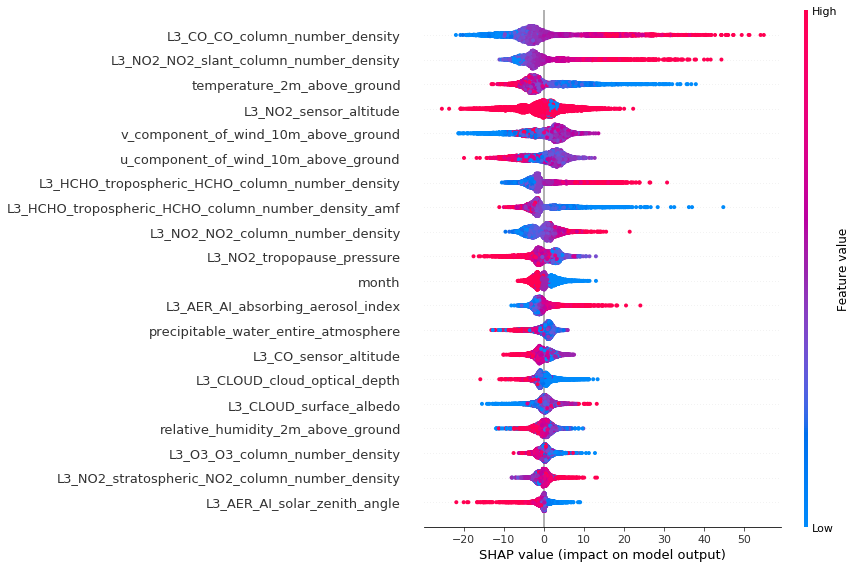

In [224]:
shap.summary_plot(shap_values, X_val)

The shap summary plot above shows the 30 most important features.
For each feature a distribution is plotted on how the train samples influence the model outcome. 
The more red the dots, the higher the feature value, the more blue the lower the feature value.

In [412]:
#xgb_pred = grid_xgb.predict(test)
predictions = lgb_model.predict(test, num_iteration=lgb_model.best_iteration)
#rf_preds = model.predict(test)

In [413]:
sub['Place_ID X Date'] = ids
sub['target'] = predictions
sub.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,49.041099
1,0OS9LVX X 2020-01-03,38.700280
2,0OS9LVX X 2020-01-04,35.563110
3,0OS9LVX X 2020-01-05,37.528619
4,0OS9LVX X 2020-01-06,35.320019


In [414]:
lgbm_score = lgb_model.best_score['valid_1']['rmse']
lgbm_score

30.100936904984415

In [415]:
#%mkdir ./submissions
sub.to_csv(f'./submissions/sub_lgb{np.round(lgbm_score, 4)}', index=False) #sub 32.69 (early_stop_rd:100; md:11,lr:0.05)#drop place-id #L3_AI_sensor_altitude
#sub.to_csv(f'./submissions/sub_rf_{np.round(np.mean(scores), 4)}.csv', index=False)
#sub.to_csv(f'./submissions/sub_xgb{np.round(err, 4)}', index=False)